# Exploratory Circuit Analysis on Brain-Aligned Models

In [260]:
import sys

In [24]:
sys.path.append("/BRAIN/circuit-alignment/work/circuit-brain-prune")

In [25]:
import torch

import numpy as np
import circuit_brain.utils as utils
from circuit_brain.dproc import fMRIDataset
from circuit_brain.model import BrainAlignedLMModel, patching

In [268]:
from circuit_brain import visual

In [48]:
from tqdm import tqdm_notebook

tqdm = tqdm_notebook

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [239]:
das = fMRIDataset.get_dataset("das", "../data/DS_data")
hp = fMRIDataset.get_dataset("hp", "../data/HP_data", window_size=20, remove_format_chars=True, remove_punc_spacing=True)

In [28]:
model = BrainAlignedLMModel("gpt2-small")

/BRAIN/circuit-alignment/work/miniconda3/envs/ca-dgx1/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


In [29]:
for k, test_idx, train_idx in hp.kfold(5,5): break

There are 1211 fMRI measurements available. Splitting 5 folds means roughly 242 measurements / fold, and 1035 words / fold.


In [30]:
train_idx = train_idx[:500]

In [250]:
# only use the 3rd subject – since it generally has high brain alignment
contexts = hp.fmri_contexts
subjectm = hp[2]
base = das.supp_sents

train_fmri, test_fmri = subjectm[train_idx], subjectm[test_idx]
train_fmri, test_fmri = torch.from_numpy(train_fmri).float(), torch.from_numpy(test_fmri).float()

In [251]:
# tokenize all together to make sure that they are padded to the same length
tokens = model.to_tokens(np.concatenate([contexts, base[:len(train_idx)]]))
train_toks, test_toks = tokens[train_idx], tokens[test_idx]
corr_toks = tokens[len(contexts):]

In [242]:
_, clean_cache = model.run_with_cache(train_toks)
_, corrp_cache = model.run_with_cache(corr_toks)

/BRAIN/circuit-alignment/work/miniconda3/envs/ca-dgx1/lib/python3.12/site-packages/rich/live.py:231: UserWarning:

install "ipywidgets" for Jupyter support

In [252]:
train_repr, test_repr = model.hidden_repr(train_toks), model.hidden_repr(test_toks)
corrp_repr = model.hidden_repr(corr_toks)

In [253]:
pca = utils.PCA(n_components=130)

train_tt = train_repr.transpose(1,0)
test_tt = test_repr.transpose(1,0)
corr_tt = corrp_repr.transpose(1,0)

s = train_tt.shape[1] * train_tt.shape[2]

In [254]:
test_tt.shape

torch.Size([237, 13, 768])

In [255]:
train_tt.shape

torch.Size([500, 13, 768])

In [256]:
corr_tt.shape

torch.Size([500, 13, 768])

In [257]:
ridge_cv = utils.RidgeCV(n_splits=5, lams=[10 ** i for i in range(6,10)])

baseline = ridge_cv.fit(pca.fit_transform(train_tt.reshape(-1,s)), train_fmri)
baseline_r2 = ridge_cv.score(pca.transform(test_tt.reshape(-1,s)), test_fmri).cpu().item()
corrupted = ridge_cv.fit(pca.fit_transform(corr_tt.reshape(-1,s)), train_fmri)
corrupted_r2 = ridge_cv.score(pca.transform(test_tt.reshape(-1,s)), test_fmri).cpu().item()

In [258]:
print(baseline_r2, corrupted_r2)

0.002055578399449587 -0.0003036911366507411


In [259]:
def alignment_metric(logits, cache, train_fmri=train_fmri, test_fmri=test_fmri):
    repr = model.resid_post(cache) 
    repr = repr.transpose(1,0)
    # normalize across token dimension
    repr = (repr - repr.mean(axis=0)) / repr.std(axis=0)
    s = repr.shape[1] * repr.shape[2]
    repr = repr.reshape(-1,s).to("cuda")
    diff = ridge_cv.fit(pca.fit_transform(repr.reshape(-1,s)), train_fmri)
    diff_r2 = ridge_cv.score(pca.transform(test_tt.reshape(-1,s)), test_fmri).cpu().item()
    return (diff_r2 - corrupted_r2) / (baseline_r2 - corrupted_r2)

In [270]:
from importlib import reload

In [50]:
attn_head_out_all_pos_act_patch_results = patching.get_act_patch_attn_head_out_all_pos(model, corr_toks, clean_cache, alignment_metric, batch_size=64)

  1%|█▉                                                                                                                                                                                                                                                                                     | 1/144 [00:07<18:01,  7.56s/it]

-0.0008193975081667304



  1%|███▉                                                                                                                                                                                                                                                                                   | 2/144 [00:15<19:03,  8.05s/it]

-0.0007766906637698412



  2%|█████▊                                                                                                                                                                                                                                                                                 | 3/144 [00:23<18:24,  7.83s/it]

-0.0007064374512992799



  3%|███████▊                                                                                                                                                                                                                                                                               | 4/144 [00:31<18:03,  7.74s/it]

-0.0006990047986619174



  3%|█████████▋                                                                                                                                                                                                                                                                             | 5/144 [00:38<17:51,  7.71s/it]

-0.0006748074665665627



  4%|███████████▋                                                                                                                                                                                                                                                                           | 6/144 [00:46<17:37,  7.66s/it]

-0.000770611921325326



  5%|█████████████▌                                                                                                                                                                                                                                                                         | 7/144 [00:54<17:30,  7.67s/it]

-0.000755712331738323



  6%|███████████████▌                                                                                                                                                                                                                                                                       | 8/144 [01:01<17:28,  7.71s/it]

-0.0006394206429831684



  6%|█████████████████▍                                                                                                                                                                                                                                                                     | 9/144 [01:09<17:06,  7.61s/it]

-0.0007709635538049042



  7%|███████████████████▎                                                                                                                                                                                                                                                                  | 10/144 [01:16<16:32,  7.41s/it]

-0.0007016180898062885



  8%|█████████████████████▏                                                                                                                                                                                                                                                                | 11/144 [01:23<16:07,  7.28s/it]

-0.00037288572639226913



  8%|███████████████████████▏                                                                                                                                                                                                                                                              | 12/144 [01:30<15:51,  7.21s/it]

-0.0007520608487538993



  9%|█████████████████████████                                                                                                                                                                                                                                                             | 13/144 [01:37<15:43,  7.20s/it]

-0.0007373624248430133



 10%|███████████████████████████                                                                                                                                                                                                                                                           | 14/144 [01:45<16:16,  7.51s/it]

-0.0006574314320459962



 10%|████████████████████████████▉                                                                                                                                                                                                                                                         | 15/144 [01:52<15:57,  7.42s/it]

-0.0007704936433583498



 11%|██████████████████████████████▉                                                                                                                                                                                                                                                       | 16/144 [01:59<15:34,  7.30s/it]

-0.0007520999060943723



 12%|████████████████████████████████▊                                                                                                                                                                                                                                                     | 17/144 [02:07<15:25,  7.29s/it]

-0.0008024470880627632



 12%|██████████████████████████████████▊                                                                                                                                                                                                                                                   | 18/144 [02:14<15:12,  7.24s/it]

-0.0007872171700000763



 13%|████████████████████████████████████▋                                                                                                                                                                                                                                                 | 19/144 [02:21<15:09,  7.28s/it]

-0.000709305691998452



 14%|██████████████████████████████████████▌                                                                                                                                                                                                                                               | 20/144 [02:28<14:53,  7.21s/it]

-0.0007849328103475273



 15%|████████████████████████████████████████▌                                                                                                                                                                                                                                             | 21/144 [02:35<14:42,  7.18s/it]

-0.0008319493499584496



 15%|██████████████████████████████████████████▍                                                                                                                                                                                                                                           | 22/144 [02:42<14:29,  7.12s/it]

-0.0007595636416226625



 16%|████████████████████████████████████████████▍                                                                                                                                                                                                                                         | 23/144 [02:49<14:19,  7.11s/it]

-0.0007663094438612461



 17%|██████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 24/144 [02:56<14:10,  7.09s/it]

-0.000763686140999198



 17%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                     | 25/144 [03:03<13:59,  7.05s/it]

-0.0006931425887160003



 18%|██████████████████████████████████████████████████▏                                                                                                                                                                                                                                   | 26/144 [03:10<13:52,  7.05s/it]

-0.0007425592048093677



 19%|████████████████████████████████████████████████████▏                                                                                                                                                                                                                                 | 27/144 [03:17<13:44,  7.05s/it]

-0.0007248847396112978



 19%|██████████████████████████████████████████████████████                                                                                                                                                                                                                                | 28/144 [03:24<13:35,  7.03s/it]

-0.0007125187548808753



 20%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 29/144 [03:32<13:38,  7.12s/it]

-0.0007253256626427174



 21%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                                                            | 30/144 [03:39<13:30,  7.11s/it]

-0.0007104527321644127



 22%|███████████████████████████████████████████████████████████▊                                                                                                                                                                                                                          | 31/144 [03:46<13:20,  7.09s/it]

-0.0007689176709391177



 22%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 32/144 [03:53<13:12,  7.07s/it]

-0.0007523584645241499



 23%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                      | 33/144 [04:00<13:05,  7.07s/it]

-0.0007545524276793003



 24%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                    | 34/144 [04:07<12:56,  7.06s/it]

-0.0007279956480488181



 24%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                  | 35/144 [04:14<12:50,  7.07s/it]

-0.0006810787599533796



 25%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                | 36/144 [04:21<12:45,  7.08s/it]

-0.0007496931939385831



 26%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                              | 37/144 [04:28<12:39,  7.10s/it]

-0.0007344139739871025



 26%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                            | 38/144 [04:35<12:31,  7.09s/it]

-0.0007368139922618866



 27%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 39/144 [04:43<12:39,  7.23s/it]

-0.000721931632142514



 28%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                        | 40/144 [04:50<12:27,  7.19s/it]

-0.000745614874176681



 28%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                      | 41/144 [04:57<12:16,  7.16s/it]

-0.000753191125113517



 29%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                     | 42/144 [05:05<12:23,  7.29s/it]

-0.0007495659519918263



 30%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                   | 43/144 [05:12<12:11,  7.24s/it]

-0.0007326221093535423



 31%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                 | 44/144 [05:19<12:03,  7.23s/it]

-0.0007359538576565683



 31%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                               | 45/144 [05:26<11:59,  7.26s/it]

-0.0007327812490984797



 32%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 46/144 [05:35<12:18,  7.53s/it]

-0.0007269774796441197



 33%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 47/144 [05:43<12:35,  7.79s/it]

-0.0007455767481587827



 33%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                         | 48/144 [05:51<12:44,  7.96s/it]

-0.0007184413261711597



 34%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 49/144 [06:00<12:58,  8.19s/it]

-0.0007288760971277952



 35%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 50/144 [06:08<12:56,  8.26s/it]

-0.0007321694283746183



 35%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 51/144 [06:17<12:51,  8.29s/it]

-0.0007182444678619504



 36%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                 | 52/144 [06:24<12:08,  7.92s/it]

-0.0007254618685692549



 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                               | 53/144 [06:31<11:39,  7.69s/it]

-0.0007829911191947758



 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 54/144 [06:38<11:16,  7.52s/it]

-0.0007280581048689783



 38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                           | 55/144 [06:47<11:46,  7.93s/it]

-0.0007538786740042269



 39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                          | 56/144 [06:55<11:27,  7.81s/it]

-0.0007859739125706255



 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 57/144 [07:02<10:59,  7.58s/it]

-0.0007161861285567284



 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                      | 58/144 [07:09<10:35,  7.39s/it]

-0.000737491063773632



 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                    | 59/144 [07:16<10:19,  7.29s/it]

-0.0007732488447800279



 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                  | 60/144 [07:23<10:12,  7.29s/it]

-0.0006779944524168968



 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                | 61/144 [07:30<10:03,  7.27s/it]

-0.0007488740375265479



 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                              | 62/144 [07:37<09:53,  7.24s/it]

-0.0007356365094892681



 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 63/144 [07:44<09:44,  7.21s/it]

-0.0007516470504924655



 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 64/144 [07:52<09:38,  7.24s/it]

-0.0007710964418947697



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 65/144 [07:59<09:38,  7.32s/it]

-0.0007035008165985346



 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 66/144 [08:06<09:24,  7.24s/it]

-0.0007445722003467381



 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 67/144 [08:13<09:12,  7.17s/it]

-0.0007258589030243456



 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 68/144 [08:20<09:00,  7.12s/it]

-0.0007367196376435459



 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 69/144 [08:27<08:50,  7.07s/it]

-0.0007333628600463271



 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 70/144 [08:35<08:48,  7.14s/it]

-0.0007154688937589526



 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 71/144 [08:42<08:37,  7.09s/it]

-0.0007181044784374535



 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 72/144 [08:49<08:30,  7.09s/it]

-0.0007841812912374735



 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 73/144 [08:56<08:22,  7.08s/it]

-0.0007115805638022721



 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 74/144 [09:03<08:12,  7.03s/it]

-0.0007395197753794491



 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 75/144 [09:10<08:02,  6.99s/it]

-0.0007310878136195242



 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 76/144 [09:16<07:54,  6.98s/it]

-0.0007247503381222486



 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 77/144 [09:24<07:50,  7.02s/it]

-0.0007072965963743627



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 78/144 [09:31<07:42,  7.01s/it]

-0.0007102721137925982



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 79/144 [09:38<07:34,  6.99s/it]

-0.0008392448653467



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 80/144 [09:45<07:31,  7.06s/it]

-0.0007243831059895456



 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 81/144 [09:52<07:23,  7.05s/it]

-0.0007468448020517826



 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 82/144 [09:59<07:15,  7.02s/it]

-0.0007367702783085406



 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 83/144 [10:06<07:06,  7.00s/it]

-0.0007149719167500734



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 84/144 [10:13<06:58,  6.98s/it]

-0.00071458809543401



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 85/144 [10:20<06:51,  6.97s/it]

-0.000750770210288465



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 86/144 [10:27<06:46,  7.01s/it]

-0.0007301091682165861



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 87/144 [10:34<06:43,  7.08s/it]

-0.0007397076115012169



 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 88/144 [10:41<06:39,  7.14s/it]

-0.0007573301554657519



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 89/144 [10:48<06:32,  7.13s/it]

-0.000727222126442939



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 90/144 [10:55<06:24,  7.12s/it]

-0.0007424532086588442



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 91/144 [11:03<06:18,  7.14s/it]

-0.0007398632005788386



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 92/144 [11:10<06:12,  7.16s/it]

-0.0007279601413756609



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 93/144 [11:18<06:21,  7.47s/it]

-0.0007325267652049661



 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 94/144 [11:25<06:07,  7.35s/it]

-0.000739059061743319



 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 95/144 [11:32<05:56,  7.27s/it]

-0.0007387914811260998



 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 96/144 [11:39<05:45,  7.20s/it]

-0.0007271636859513819



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 97/144 [11:46<05:36,  7.15s/it]

-0.0007263079169206321



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 98/144 [11:53<05:26,  7.11s/it]

-0.0007327572093345225



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 99/144 [12:00<05:18,  7.08s/it]

-0.0007065576501190662



 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 100/144 [12:07<05:13,  7.12s/it]

-0.0007591567118652165



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 101/144 [12:15<05:07,  7.16s/it]

-0.0007143064867705107



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 102/144 [12:22<04:58,  7.10s/it]

-0.0007094461470842361



 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 103/144 [12:29<04:49,  7.06s/it]

-0.0007597677176818252



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 104/144 [12:36<04:41,  7.04s/it]

-0.0007211339543573558



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 105/144 [12:43<04:34,  7.04s/it]

-0.0006869630888104439



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 106/144 [12:50<04:27,  7.04s/it]

-0.0007757662679068744



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 107/144 [12:57<04:19,  7.02s/it]

-0.0007710750214755535



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 108/144 [13:04<04:12,  7.01s/it]

-0.0007053649169392884



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 109/144 [13:11<04:04,  7.00s/it]

-0.0007547781569883227



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 110/144 [13:18<03:57,  6.98s/it]

-0.0007352778338827193



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 111/144 [13:25<03:52,  7.06s/it]

-0.0007278096163645387



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 112/144 [13:32<03:44,  7.02s/it]

-0.0006845428724773228



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 113/144 [13:39<03:36,  7.00s/it]

-0.0007118044304661453



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 114/144 [13:46<03:29,  6.98s/it]

-0.000719298841431737



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 115/144 [13:53<03:22,  6.98s/it]

-0.0007403269992209971



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 116/144 [14:00<03:16,  7.01s/it]

-0.0007123437826521695



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 117/144 [14:07<03:09,  7.04s/it]

-0.0006555814761668444



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 118/144 [14:14<03:07,  7.21s/it]

-0.0007339477306231856



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 119/144 [14:22<02:59,  7.19s/it]

-0.0007356497808359563



 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 120/144 [14:28<02:50,  7.11s/it]

-0.0007254031952470541



 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 121/144 [14:36<02:43,  7.11s/it]

-0.0007384413038380444



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 122/144 [14:43<02:35,  7.07s/it]

-0.0007217783713713288



 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 123/144 [14:49<02:27,  7.02s/it]

-0.0008141880389302969



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 124/144 [14:56<02:20,  7.01s/it]

-0.0007187669980339706



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 125/144 [15:03<02:12,  6.99s/it]

-0.0007088395650498569



 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 126/144 [15:11<02:07,  7.09s/it]

-0.0007294144597835839



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 127/144 [15:18<02:00,  7.08s/it]

-0.0007438280736096203



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 128/144 [15:25<01:53,  7.07s/it]

-0.0007267965702340007



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 129/144 [15:32<01:45,  7.06s/it]

-0.000740644580218941



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 130/144 [15:39<01:39,  7.11s/it]

-0.0007384650525636971



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 131/144 [15:46<01:32,  7.11s/it]

-0.0007706272299401462



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 132/144 [15:54<01:26,  7.21s/it]

-0.0007317351410165429



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 133/144 [16:01<01:19,  7.21s/it]

-0.0007181234541349113



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 134/144 [16:08<01:12,  7.21s/it]

-0.0007456637686118484



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 135/144 [16:16<01:06,  7.42s/it]

-0.0007416302687488496



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 136/144 [16:23<00:58,  7.37s/it]

-0.0007360769668594003



 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 137/144 [16:30<00:50,  7.23s/it]

-0.0006954643176868558



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 138/144 [16:38<00:44,  7.36s/it]

-0.0007363925105892122



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 139/144 [16:45<00:36,  7.37s/it]

-0.000749480735976249



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 140/144 [16:52<00:28,  7.21s/it]

-0.0007456210441887379



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 141/144 [16:59<00:21,  7.11s/it]

-0.0008149417117238045



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 142/144 [17:06<00:14,  7.08s/it]

-0.0007226802408695221



 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 143/144 [17:13<00:07,  7.20s/it]

-0.0007236202945932746



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [17:21<00:00,  7.23s/it]

-0.0007319719297811389


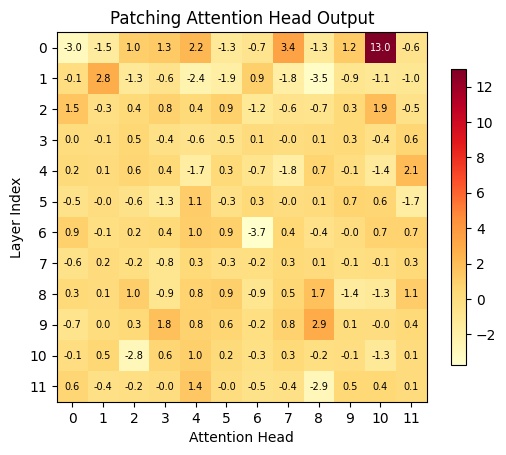

In [207]:
import matplotlib.pyplot as plt

vfmt = lambda x: f"{x*100:.1f}"



threshold = im.norm(attn_head_out_all_pos_act_patch_results.max().cpu().item())/2

im = plt.imshow(attn_head_out_all_pos_act_patch_results.cpu().numpy() * 100, cmap="YlOrRd")
for i in range(len(attn_head_out_all_pos_act_patch_results)):
    for j in range(len(attn_head_out_all_pos_act_patch_results[0])):
        val = attn_head_out_all_pos_act_patch_results[i,j]
        im.axes.text(
            j,
            i,
            vfmt(val.cpu().item()),
            fontsize=7,
            ha="center",
            va="center",
            color="black" if val < threshold else "white"
        )

n_layers, n_heads = attn_head_out_all_pos_act_patch_results.shape
plt.title("Patching Attention Head Output")
plt.ylabel("Layer Index")
plt.xlabel("Attention Head")
plt.xticks(np.arange(n_heads), labels=np.arange(n_heads))
plt.yticks(np.arange(n_layers), labels=np.arange(n_layers))
plt.colorbar(im, shrink=0.8)
plt.savefig("../figures/attn_head_out_all_gpt2_small.pdf")

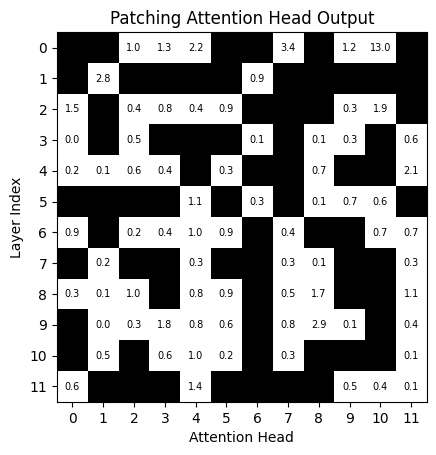

In [208]:
import matplotlib.pyplot as plt

vfmt = lambda x: f"{x*100:.1f}"

threshold = im.norm(attn_head_out_all_pos_act_patch_results.max().cpu().item())/2

im = plt.imshow(attn_head_out_all_pos_act_patch_results.cpu().numpy() > 0, cmap="grey")
for i in range(len(attn_head_out_all_pos_act_patch_results)):
    for j in range(len(attn_head_out_all_pos_act_patch_results[0])):
        val = attn_head_out_all_pos_act_patch_results[i,j]
        im.axes.text(
            j,
            i,
            vfmt(val.cpu().item()),
            fontsize=7,
            ha="center",
            va="center",
            color="black"
        )

n_layers, n_heads = attn_head_out_all_pos_act_patch_results.shape
plt.title("Patching Attention Head Output")
plt.ylabel("Layer Index")
plt.xlabel("Attention Head")
plt.xticks(np.arange(n_heads), labels=np.arange(n_heads))
plt.yticks(np.arange(n_layers), labels=np.arange(n_layers))
# plt.colorbar(im, shrink=0.8)
plt.savefig("../figures/attn_head_pruned_gpt2_small.pdf")

In [113]:
every_head_all_pos_act_patch_result = patching.get_act_patch_attn_head_all_pos_every(model, corr_toks, clean_cache, alignment_metric, batch_size=128)

batch-size 128


  1%|█▉                                                                                                                                                                                                                                                                                     | 1/144 [00:05<12:39,  5.31s/it]

-0.0008193975081667304



  1%|███▉                                                                                                                                                                                                                                                                                   | 2/144 [00:11<13:16,  5.61s/it]

-0.0007766906637698412



  2%|█████▊                                                                                                                                                                                                                                                                                 | 3/144 [00:16<13:21,  5.68s/it]

-0.0007064374512992799



  3%|███████▊                                                                                                                                                                                                                                                                               | 4/144 [00:22<13:23,  5.74s/it]

-0.0006990047986619174



  3%|█████████▋                                                                                                                                                                                                                                                                             | 5/144 [00:28<13:22,  5.78s/it]

-0.0006748074665665627



  4%|███████████▋                                                                                                                                                                                                                                                                           | 6/144 [00:34<13:16,  5.77s/it]

-0.000770611921325326



  5%|█████████████▌                                                                                                                                                                                                                                                                         | 7/144 [00:40<13:09,  5.76s/it]

-0.000755712331738323



  6%|███████████████▌                                                                                                                                                                                                                                                                       | 8/144 [00:45<13:06,  5.78s/it]

-0.0006394206429831684



  6%|█████████████████▍                                                                                                                                                                                                                                                                     | 9/144 [00:51<13:01,  5.79s/it]

-0.0007709635538049042



  7%|███████████████████▎                                                                                                                                                                                                                                                                  | 10/144 [00:57<12:59,  5.81s/it]

-0.0007016180898062885



  8%|█████████████████████▏                                                                                                                                                                                                                                                                | 11/144 [01:03<12:55,  5.83s/it]

-0.00037288572639226913



  8%|███████████████████████▏                                                                                                                                                                                                                                                              | 12/144 [01:09<12:52,  5.85s/it]

-0.0007520608487538993



  9%|█████████████████████████                                                                                                                                                                                                                                                             | 13/144 [01:15<12:47,  5.86s/it]

-0.0007373624248430133



 10%|███████████████████████████                                                                                                                                                                                                                                                           | 14/144 [01:21<12:41,  5.86s/it]

-0.0006574314320459962



 10%|████████████████████████████▉                                                                                                                                                                                                                                                         | 15/144 [01:26<12:33,  5.84s/it]

-0.0007704936433583498



 11%|██████████████████████████████▉                                                                                                                                                                                                                                                       | 16/144 [01:32<12:24,  5.82s/it]

-0.0007520999060943723



 12%|████████████████████████████████▊                                                                                                                                                                                                                                                     | 17/144 [01:38<12:16,  5.80s/it]

-0.0008024470880627632



 12%|██████████████████████████████████▊                                                                                                                                                                                                                                                   | 18/144 [01:44<12:12,  5.81s/it]

-0.0007872171700000763



 13%|████████████████████████████████████▋                                                                                                                                                                                                                                                 | 19/144 [01:50<12:05,  5.80s/it]

-0.000709305691998452



 14%|██████████████████████████████████████▌                                                                                                                                                                                                                                               | 20/144 [01:55<12:00,  5.81s/it]

-0.0007849328103475273



 15%|████████████████████████████████████████▌                                                                                                                                                                                                                                             | 21/144 [02:01<11:58,  5.84s/it]

-0.0008319493499584496



 15%|██████████████████████████████████████████▍                                                                                                                                                                                                                                           | 22/144 [02:07<11:54,  5.86s/it]

-0.0007595636416226625



 16%|████████████████████████████████████████████▍                                                                                                                                                                                                                                         | 23/144 [02:13<11:49,  5.86s/it]

-0.0007663094438612461



 17%|██████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 24/144 [02:19<11:43,  5.87s/it]

-0.000763686140999198



 17%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                     | 25/144 [02:26<12:24,  6.25s/it]

-0.0006931425887160003



 18%|██████████████████████████████████████████████████▏                                                                                                                                                                                                                                   | 26/144 [02:31<11:48,  6.01s/it]

-0.0007425592048093677



 19%|████████████████████████████████████████████████████▏                                                                                                                                                                                                                                 | 27/144 [02:37<11:22,  5.83s/it]

-0.0007248847396112978



 19%|██████████████████████████████████████████████████████                                                                                                                                                                                                                                | 28/144 [02:42<11:01,  5.70s/it]

-0.0007125187548808753



 20%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 29/144 [02:48<10:39,  5.56s/it]

-0.0007253256626427174



 21%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                                                            | 30/144 [02:53<10:20,  5.44s/it]

-0.0007104527321644127



 22%|███████████████████████████████████████████████████████████▊                                                                                                                                                                                                                          | 31/144 [02:58<10:09,  5.40s/it]

-0.0007689176709391177



 22%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 32/144 [03:04<10:08,  5.44s/it]

-0.0007523584645241499



 23%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                      | 33/144 [03:09<10:04,  5.45s/it]

-0.0007545524276793003



 24%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                    | 34/144 [03:15<10:02,  5.48s/it]

-0.0007279956480488181



 24%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                  | 35/144 [03:20<10:00,  5.51s/it]

-0.0006810787599533796



 25%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                | 36/144 [03:26<09:53,  5.49s/it]

-0.0007496931939385831



 26%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                              | 37/144 [03:31<09:45,  5.48s/it]

-0.0007344139739871025



 26%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                            | 38/144 [03:36<09:35,  5.43s/it]

-0.0007368139922618866



 27%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 39/144 [03:42<09:30,  5.44s/it]

-0.000721931632142514



 28%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                        | 40/144 [03:47<09:24,  5.43s/it]

-0.000745614874176681



 28%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                      | 41/144 [03:53<09:18,  5.42s/it]

-0.000753191125113517



 29%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                     | 42/144 [03:58<09:13,  5.43s/it]

-0.0007495659519918263



 30%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                   | 43/144 [04:03<09:07,  5.42s/it]

-0.0007326221093535423



 31%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                 | 44/144 [04:09<09:04,  5.44s/it]

-0.0007359538576565683



 31%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                               | 45/144 [04:14<09:00,  5.46s/it]

-0.0007327812490984797



 32%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 46/144 [04:20<08:51,  5.42s/it]

-0.0007269774796441197



 33%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 47/144 [04:25<08:39,  5.36s/it]

-0.0007455767481587827



 33%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                         | 48/144 [04:30<08:35,  5.37s/it]

-0.0007184413261711597



 34%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 49/144 [04:36<08:29,  5.36s/it]

-0.0007288760971277952



 35%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 50/144 [04:41<08:24,  5.37s/it]

-0.0007321694283746183



 35%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 51/144 [04:46<08:18,  5.36s/it]

-0.0007182444678619504



 36%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                 | 52/144 [04:52<08:12,  5.35s/it]

-0.0007254618685692549



 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                               | 53/144 [04:57<08:06,  5.35s/it]

-0.0007829911191947758



 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 54/144 [05:02<08:01,  5.35s/it]

-0.0007280581048689783



 38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                           | 55/144 [05:08<07:57,  5.37s/it]

-0.0007538786740042269



 39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                          | 56/144 [05:13<07:54,  5.39s/it]

-0.0007859739125706255



 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 57/144 [05:19<07:48,  5.39s/it]

-0.0007161861285567284



 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                      | 58/144 [05:24<07:40,  5.35s/it]

-0.000737491063773632



 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                    | 59/144 [05:30<07:38,  5.40s/it]

-0.0007732488447800279



 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                  | 60/144 [05:35<07:31,  5.38s/it]

-0.0006779944524168968



 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                | 61/144 [05:40<07:26,  5.37s/it]

-0.0007488740375265479



 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                              | 62/144 [05:46<07:20,  5.38s/it]

-0.0007356365094892681



 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 63/144 [05:51<07:14,  5.37s/it]

-0.0007516470504924655



 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 64/144 [05:56<07:09,  5.37s/it]

-0.0007710964418947697



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 65/144 [06:02<07:05,  5.38s/it]

-0.0007035008165985346



 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 66/144 [06:07<07:04,  5.44s/it]

-0.0007445722003467381



 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 67/144 [06:13<06:59,  5.45s/it]

-0.0007258589030243456



 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 68/144 [06:18<06:54,  5.45s/it]

-0.0007367196376435459



 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 69/144 [06:24<06:48,  5.45s/it]

-0.0007333628600463271



 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 70/144 [06:29<06:42,  5.43s/it]

-0.0007154688937589526



 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 71/144 [06:34<06:35,  5.42s/it]

-0.0007181044784374535



 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 72/144 [06:40<06:28,  5.39s/it]

-0.0007841812912374735



 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 73/144 [06:45<06:21,  5.38s/it]

-0.0007115805638022721



 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 74/144 [06:51<06:17,  5.39s/it]

-0.0007395197753794491



 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 75/144 [06:56<06:10,  5.37s/it]

-0.0007310878136195242



 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 76/144 [07:01<06:04,  5.36s/it]

-0.0007247503381222486



 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 77/144 [07:07<05:59,  5.37s/it]

-0.0007072965963743627



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 78/144 [07:12<05:53,  5.36s/it]

-0.0007102721137925982



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 79/144 [07:17<05:47,  5.35s/it]

-0.0008392448653467



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 80/144 [07:23<05:42,  5.35s/it]

-0.0007243831059895456



 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 81/144 [07:28<05:36,  5.34s/it]

-0.0007468448020517826



 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 82/144 [07:33<05:31,  5.34s/it]

-0.0007367702783085406



 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 83/144 [07:39<05:26,  5.36s/it]

-0.0007149719167500734



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 84/144 [07:44<05:21,  5.36s/it]

-0.00071458809543401



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 85/144 [07:49<05:16,  5.37s/it]

-0.000750770210288465



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 86/144 [07:55<05:15,  5.45s/it]

-0.0007301091682165861



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 87/144 [08:00<05:08,  5.42s/it]

-0.0007397076115012169



 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 88/144 [08:06<05:03,  5.42s/it]

-0.0007573301554657519



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 89/144 [08:11<04:57,  5.41s/it]

-0.000727222126442939



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 90/144 [08:17<04:54,  5.45s/it]

-0.0007424532086588442



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 91/144 [08:22<04:49,  5.46s/it]

-0.0007398632005788386



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 92/144 [08:28<04:50,  5.58s/it]

-0.0007279601413756609



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 93/144 [08:34<04:42,  5.54s/it]

-0.0007325267652049661



 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 94/144 [08:40<04:43,  5.67s/it]

-0.000739059061743319



 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 95/144 [08:45<04:34,  5.60s/it]

-0.0007387914811260998



 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 96/144 [08:50<04:26,  5.55s/it]

-0.0007271636859513819



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 97/144 [08:56<04:19,  5.51s/it]

-0.0007263079169206321



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 98/144 [09:01<04:12,  5.48s/it]

-0.0007327572093345225



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 99/144 [09:07<04:10,  5.58s/it]

-0.0007065576501190662



 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 100/144 [09:14<04:21,  5.95s/it]

-0.0007591567118652165



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 101/144 [09:20<04:24,  6.15s/it]

-0.0007143064867705107



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 102/144 [09:26<04:09,  5.94s/it]

-0.0007094461470842361



 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 103/144 [09:31<03:58,  5.81s/it]

-0.0007597677176818252



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 104/144 [09:37<03:48,  5.72s/it]

-0.0007211339543573558



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 105/144 [09:42<03:39,  5.64s/it]

-0.0006869630888104439



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 106/144 [09:48<03:36,  5.70s/it]

-0.0007757662679068744



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 107/144 [09:54<03:29,  5.65s/it]

-0.0007710750214755535



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 108/144 [09:59<03:21,  5.59s/it]

-0.0007053649169392884



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 109/144 [10:05<03:13,  5.53s/it]

-0.0007547781569883227



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 110/144 [10:10<03:06,  5.48s/it]

-0.0007352778338827193



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 111/144 [10:15<02:59,  5.45s/it]

-0.0007278096163645387



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 112/144 [10:21<02:53,  5.44s/it]

-0.0006845428724773228



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 113/144 [10:26<02:48,  5.42s/it]

-0.0007118044304661453



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 114/144 [10:32<02:42,  5.41s/it]

-0.000719298841431737



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 115/144 [10:37<02:37,  5.42s/it]

-0.0007403269992209971



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 116/144 [10:42<02:31,  5.42s/it]

-0.0007123437826521695



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 117/144 [10:48<02:26,  5.44s/it]

-0.0006555814761668444



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 118/144 [10:53<02:21,  5.45s/it]

-0.0007339477306231856



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 119/144 [10:59<02:16,  5.46s/it]

-0.0007356497808359563



 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 120/144 [11:05<02:15,  5.64s/it]

-0.0007254031952470541



 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 121/144 [11:11<02:10,  5.66s/it]

-0.0007384413038380444



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 122/144 [11:16<02:04,  5.64s/it]

-0.0007217783713713288



 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 123/144 [11:22<01:57,  5.60s/it]

-0.0008141880389302969



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 124/144 [11:27<01:51,  5.57s/it]

-0.0007187669980339706



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 125/144 [11:33<01:46,  5.60s/it]

-0.0007088395650498569



 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 126/144 [11:38<01:39,  5.53s/it]

-0.0007294144597835839



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 127/144 [11:44<01:33,  5.49s/it]

-0.0007438280736096203



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 128/144 [11:49<01:28,  5.51s/it]

-0.0007267965702340007



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 129/144 [11:55<01:22,  5.49s/it]

-0.000740644580218941



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 130/144 [12:00<01:16,  5.46s/it]

-0.0007384650525636971



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 131/144 [12:05<01:10,  5.42s/it]

-0.0007706272299401462



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 132/144 [12:11<01:04,  5.37s/it]

-0.0007317351410165429



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 133/144 [12:16<00:58,  5.35s/it]

-0.0007181234541349113



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 134/144 [12:21<00:53,  5.34s/it]

-0.0007456637686118484



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 135/144 [12:27<00:48,  5.33s/it]

-0.0007416302687488496



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 136/144 [12:32<00:42,  5.35s/it]

-0.0007360769668594003



 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 137/144 [12:37<00:37,  5.36s/it]

-0.0006954643176868558



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 138/144 [12:43<00:32,  5.36s/it]

-0.0007363925105892122



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 139/144 [12:48<00:26,  5.36s/it]

-0.000749480735976249



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 140/144 [12:53<00:21,  5.36s/it]

-0.0007456210441887379



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 141/144 [12:59<00:16,  5.36s/it]

-0.0008149417117238045



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 142/144 [13:04<00:10,  5.37s/it]

-0.0007226802408695221



 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 143/144 [13:10<00:05,  5.37s/it]

-0.0007236202945932746



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [13:15<00:00,  5.52s/it]

-0.0007319719297811389
batch-size 128



  1%|█▉                                                                                                                                                                                                                                                                                     | 1/144 [00:05<13:52,  5.82s/it]

-0.0007363317417912185



  1%|███▉                                                                                                                                                                                                                                                                                   | 2/144 [00:11<13:13,  5.59s/it]

-0.0008422576356679201



  2%|█████▊                                                                                                                                                                                                                                                                                 | 3/144 [00:16<12:54,  5.49s/it]

-0.0007354679401032627



  3%|███████▊                                                                                                                                                                                                                                                                               | 4/144 [00:21<12:40,  5.43s/it]

-0.0007289329660125077



  3%|█████████▋                                                                                                                                                                                                                                                                             | 5/144 [00:27<12:30,  5.40s/it]

-0.0007391917752102017



  4%|███████████▋                                                                                                                                                                                                                                                                           | 6/144 [00:32<12:21,  5.38s/it]

-0.0008287547389045358



  5%|█████████████▌                                                                                                                                                                                                                                                                         | 7/144 [00:38<12:19,  5.40s/it]

-0.0007428239332512021



  6%|███████████████▌                                                                                                                                                                                                                                                                       | 8/144 [00:43<12:21,  5.45s/it]

-0.0007502518128603697



  6%|█████████████████▍                                                                                                                                                                                                                                                                     | 9/144 [00:49<12:17,  5.46s/it]

-0.0007281187572516501



  7%|███████████████████▎                                                                                                                                                                                                                                                                  | 10/144 [00:54<12:10,  5.45s/it]

-0.0007323592435568571



  8%|█████████████████████▏                                                                                                                                                                                                                                                                | 11/144 [01:00<12:04,  5.45s/it]

-0.0007319863070733845



  8%|███████████████████████▏                                                                                                                                                                                                                                                              | 12/144 [01:05<11:56,  5.43s/it]

-0.0007216028752736747



  9%|█████████████████████████                                                                                                                                                                                                                                                             | 13/144 [01:10<11:49,  5.41s/it]

-0.0007331583765335381



 10%|███████████████████████████                                                                                                                                                                                                                                                           | 14/144 [01:16<11:41,  5.39s/it]

-0.0007395408465526998



 10%|████████████████████████████▉                                                                                                                                                                                                                                                         | 15/144 [01:21<11:33,  5.38s/it]

-0.0007348845829255879



 11%|██████████████████████████████▉                                                                                                                                                                                                                                                       | 16/144 [01:26<11:28,  5.38s/it]

-0.0007416809676215053



 12%|████████████████████████████████▊                                                                                                                                                                                                                                                     | 17/144 [01:32<11:21,  5.36s/it]

-0.0007384481723420322



 12%|██████████████████████████████████▊                                                                                                                                                                                                                                                   | 18/144 [01:37<11:15,  5.36s/it]

-0.0007506467518396676



 13%|████████████████████████████████████▋                                                                                                                                                                                                                                                 | 19/144 [01:43<11:28,  5.51s/it]

-0.0007448103278875351



 14%|██████████████████████████████████████▌                                                                                                                                                                                                                                               | 20/144 [01:48<11:19,  5.48s/it]

-0.0007379873422905803



 15%|████████████████████████████████████████▌                                                                                                                                                                                                                                             | 21/144 [01:54<11:11,  5.46s/it]

-0.0007197068189270794



 15%|██████████████████████████████████████████▍                                                                                                                                                                                                                                           | 22/144 [01:59<11:08,  5.48s/it]

-0.0007355620036832988



 16%|████████████████████████████████████████████▍                                                                                                                                                                                                                                         | 23/144 [02:05<11:05,  5.50s/it]

-0.0007370858802460134



 17%|██████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 24/144 [02:10<10:54,  5.45s/it]

-0.0007396766450256109



 17%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                     | 25/144 [02:15<10:45,  5.42s/it]

-0.0007523225503973663



 18%|██████████████████████████████████████████████████▏                                                                                                                                                                                                                                   | 26/144 [02:21<10:35,  5.39s/it]

-0.0007701479480601847



 19%|████████████████████████████████████████████████████▏                                                                                                                                                                                                                                 | 27/144 [02:26<10:29,  5.38s/it]

-0.0007246037712320685



 19%|██████████████████████████████████████████████████████                                                                                                                                                                                                                                | 28/144 [02:31<10:23,  5.38s/it]

-0.0007411842234432697



 20%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 29/144 [02:37<10:22,  5.41s/it]

-0.0007275755633600056



 21%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                                                            | 30/144 [02:42<10:17,  5.42s/it]

-0.0007375397835858166



 22%|███████████████████████████████████████████████████████████▊                                                                                                                                                                                                                          | 31/144 [02:48<10:14,  5.44s/it]

-0.0007451872806996107



 22%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 32/144 [02:54<10:21,  5.55s/it]

-0.0007381491595879197



 23%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                      | 33/144 [02:59<10:14,  5.54s/it]

-0.0007334242691285908



 24%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                    | 34/144 [03:05<10:03,  5.49s/it]

-0.0007470875279977918



 24%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                  | 35/144 [03:10<09:52,  5.44s/it]

-0.0007336768903769553



 25%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                | 36/144 [03:15<09:43,  5.40s/it]

-0.0007260703714564443



 26%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                              | 37/144 [03:21<09:37,  5.40s/it]

-0.0007384477648884058



 26%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                            | 38/144 [03:26<09:31,  5.39s/it]

-0.0007601941470056772



 27%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 39/144 [03:31<09:25,  5.38s/it]

-0.0007391535327769816



 28%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                        | 40/144 [03:37<09:18,  5.37s/it]

-0.0007438405882567167



 28%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                      | 41/144 [03:42<09:06,  5.31s/it]

-0.0008037704392336309



 29%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                     | 42/144 [03:47<08:56,  5.26s/it]

-0.0007374000269919634



 30%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                   | 43/144 [03:52<08:52,  5.27s/it]

-0.0007432372076436877



 31%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                 | 44/144 [03:58<08:51,  5.31s/it]

-0.00074387202039361



 31%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                               | 45/144 [04:03<08:47,  5.33s/it]

-0.000744541990570724



 32%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 46/144 [04:09<08:48,  5.39s/it]

-0.0007313564419746399



 33%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 47/144 [04:14<08:45,  5.42s/it]

-0.0007327296189032495



 33%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                         | 48/144 [04:20<08:51,  5.54s/it]

-0.0007399492315016687



 34%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 49/144 [04:26<09:09,  5.78s/it]

-0.0007424505311064422



 35%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 50/144 [04:32<08:50,  5.64s/it]

-0.000734427769202739



 35%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 51/144 [04:37<08:36,  5.55s/it]

-0.0007743241149000823



 36%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                 | 52/144 [04:42<08:26,  5.51s/it]

-0.0007501936051994562



 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                               | 53/144 [04:48<08:16,  5.46s/it]

-0.0007324710604734719



 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 54/144 [04:53<08:08,  5.42s/it]

-0.0007594018243253231



 38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                           | 55/144 [04:58<07:59,  5.39s/it]

-0.0007066751131787896



 39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                          | 56/144 [05:04<07:52,  5.37s/it]

-0.0007400467293336987



 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 57/144 [05:09<07:46,  5.36s/it]

-0.0007200348773039877



 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                      | 58/144 [05:14<07:39,  5.34s/it]

-0.000746757083106786



 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                    | 59/144 [05:20<07:32,  5.32s/it]

-0.0007324853795580566



 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                  | 60/144 [05:25<07:24,  5.30s/it]

-0.0007265269523486495



 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                | 61/144 [05:30<07:21,  5.32s/it]

-0.0007344346959143877



 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                              | 62/144 [05:36<07:17,  5.34s/it]

-0.0007369791273958981



 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 63/144 [05:41<07:16,  5.39s/it]

-0.0007401569164358079



 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 64/144 [05:47<07:13,  5.42s/it]

-0.0007285979227162898



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 65/144 [05:52<07:06,  5.40s/it]

-0.0007356993155553937



 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 66/144 [05:57<07:01,  5.40s/it]

-0.0007315711700357497



 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 67/144 [06:03<06:57,  5.42s/it]

-0.0007362052565440536



 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 68/144 [06:08<06:53,  5.45s/it]

-0.0007520593353547156



 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 69/144 [06:14<06:44,  5.39s/it]

-0.0007465193630196154



 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 70/144 [06:19<06:38,  5.38s/it]

-0.0007612816989421844



 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 71/144 [06:25<06:41,  5.50s/it]

-0.0007273603114299476



 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 72/144 [06:31<06:48,  5.68s/it]

-0.0007418715977109969



 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 73/144 [06:37<06:51,  5.79s/it]

-0.0007614339119754732



 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 74/144 [06:42<06:38,  5.69s/it]

-0.0007315275142900646



 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 75/144 [06:48<06:36,  5.74s/it]

-0.000852116965688765



 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 76/144 [06:54<06:23,  5.64s/it]

-0.0007520587532781065



 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 77/144 [07:00<06:28,  5.80s/it]

-0.0007439136388711631



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 78/144 [07:05<06:14,  5.68s/it]

-0.0007491447031497955



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 79/144 [07:10<06:02,  5.57s/it]

-0.0007196275400929153



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 80/144 [07:16<05:53,  5.52s/it]

-0.0007493094890378416



 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 81/144 [07:21<05:46,  5.50s/it]

-0.0007403356139548123



 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 82/144 [07:27<05:38,  5.46s/it]

-0.0007354003028012812



 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 83/144 [07:32<05:30,  5.42s/it]

-0.000746763835195452



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 84/144 [07:37<05:23,  5.38s/it]

-0.0007449960103258491



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 85/144 [07:43<05:17,  5.38s/it]

-0.0007512365700677037



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 86/144 [07:48<05:11,  5.37s/it]

-0.0007469995180144906



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 87/144 [07:53<05:05,  5.37s/it]

-0.0007397553417831659



 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 88/144 [07:59<05:10,  5.55s/it]

-0.0007055642199702561



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 89/144 [08:05<05:02,  5.49s/it]

-0.0007784496410749853



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 90/144 [08:10<04:53,  5.44s/it]

-0.0007682029390707612



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 91/144 [08:16<04:49,  5.46s/it]

-0.0007731412770226598



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 92/144 [08:21<04:46,  5.51s/it]

-0.0007436810992658138



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 93/144 [08:27<04:42,  5.53s/it]

-0.0007471861317753792



 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 94/144 [08:32<04:37,  5.55s/it]

-0.0007422696216963232



 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 95/144 [08:38<04:30,  5.52s/it]

-0.0007377745350822806



 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 96/144 [08:43<04:23,  5.49s/it]

-0.0007451046258211136



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 97/144 [08:49<04:16,  5.45s/it]

-0.0007368494989350438



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 98/144 [08:55<04:22,  5.71s/it]

-0.0007429317338392138



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 99/144 [09:00<04:08,  5.53s/it]

-0.0007484570960514247



 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 100/144 [09:05<03:57,  5.41s/it]

-0.0007307326304726303



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 101/144 [09:10<03:50,  5.36s/it]

-0.000738635950256139



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 102/144 [09:16<03:44,  5.35s/it]

-0.0007449932163581252



 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 103/144 [09:21<03:40,  5.38s/it]

-0.0007312163943424821



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 104/144 [09:27<03:37,  5.43s/it]

-0.0007455201703123748



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 105/144 [09:32<03:33,  5.47s/it]

-0.0007371564861387014



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 106/144 [09:38<03:31,  5.56s/it]

-0.0007482251967303455



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 107/144 [09:43<03:23,  5.49s/it]

-0.0007439771434292197



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 108/144 [09:49<03:16,  5.45s/it]

-0.000766901473980397



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 109/144 [09:54<03:09,  5.42s/it]

-0.0007375854765996337



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 110/144 [09:59<03:02,  5.38s/it]

-0.0007422815542668104



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 111/144 [10:05<02:56,  5.35s/it]

-0.0007342714816331863



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 112/144 [10:10<02:51,  5.34s/it]

-0.0007346547208726406



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 113/144 [10:15<02:44,  5.31s/it]

-0.0007304365281015635



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 114/144 [10:20<02:38,  5.29s/it]

-0.0007506292313337326



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 115/144 [10:26<02:33,  5.28s/it]

-0.0007492853328585625



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 116/144 [10:31<02:27,  5.28s/it]

-0.0007612198824062943



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 117/144 [10:36<02:22,  5.29s/it]

-0.0007196238730102777



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 118/144 [10:42<02:17,  5.31s/it]

-0.0007179128006100655



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 119/144 [10:47<02:12,  5.29s/it]

-0.0007300294819287956



 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 120/144 [10:52<02:06,  5.27s/it]

-0.0007391663966700435



 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 121/144 [10:57<02:01,  5.26s/it]

-0.0007309172069653869



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 122/144 [11:03<01:55,  5.27s/it]

-0.0007320872973650694



 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 123/144 [11:08<01:51,  5.30s/it]

-0.0007321172743104398



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 124/144 [11:13<01:46,  5.32s/it]

-0.0007353665423579514



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 125/144 [11:19<01:40,  5.31s/it]

-0.0007449720287695527



 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 126/144 [11:24<01:35,  5.31s/it]

-0.0007185791037045419



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 127/144 [11:29<01:30,  5.30s/it]

-0.0007401848561130464



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 128/144 [11:34<01:24,  5.27s/it]

-0.000749050232116133



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 129/144 [11:40<01:18,  5.26s/it]

-0.0007355363923124969



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 130/144 [11:45<01:13,  5.25s/it]

-0.0007214423967525363



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 131/144 [11:50<01:08,  5.25s/it]

-0.0006884923204779625



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 132/144 [11:56<01:03,  5.30s/it]

-0.0007382006151601672



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 133/144 [12:01<00:58,  5.35s/it]

-0.0007316733244806528



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 134/144 [12:06<00:53,  5.37s/it]

-0.0007363056647591293



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 135/144 [12:12<00:48,  5.39s/it]

-0.0007321512675844133



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 136/144 [12:17<00:43,  5.38s/it]

-0.0007419661269523203



 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 137/144 [12:23<00:37,  5.34s/it]

-0.0007362411124631763



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 138/144 [12:28<00:31,  5.31s/it]

-0.0007345189806073904



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 139/144 [12:33<00:26,  5.28s/it]

-0.0007087066769599915



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 140/144 [12:38<00:21,  5.27s/it]

-0.0007359865121543407



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 141/144 [12:43<00:15,  5.27s/it]

-0.0007358342409133911



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 142/144 [12:49<00:10,  5.27s/it]

-0.0007269839406944811



 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 143/144 [12:54<00:05,  5.26s/it]

-0.0007552325841970742



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [12:59<00:00,  5.42s/it]

-0.0007345752674154937
batch-size 128



  1%|█▉                                                                                                                                                                                                                                                                                     | 1/144 [00:05<13:06,  5.50s/it]

-0.0007498146733269095



  1%|███▉                                                                                                                                                                                                                                                                                   | 2/144 [00:10<12:44,  5.38s/it]

-0.0007483736262656748



  2%|█████▊                                                                                                                                                                                                                                                                                 | 3/144 [00:16<12:31,  5.33s/it]

-0.0007240132545121014



  3%|███████▊                                                                                                                                                                                                                                                                               | 4/144 [00:21<12:21,  5.30s/it]

-0.0007269134512171149



  3%|█████████▋                                                                                                                                                                                                                                                                             | 5/144 [00:26<12:14,  5.28s/it]

-0.0007332165259867907



  4%|███████████▋                                                                                                                                                                                                                                                                           | 6/144 [00:31<12:11,  5.30s/it]

-0.000741965661291033



  5%|█████████████▌                                                                                                                                                                                                                                                                         | 7/144 [00:37<12:10,  5.33s/it]

-0.0007321915472857654



  6%|███████████████▌                                                                                                                                                                                                                                                                       | 8/144 [00:42<12:07,  5.35s/it]

-0.0007484518573619425



  6%|█████████████████▍                                                                                                                                                                                                                                                                     | 9/144 [00:49<12:42,  5.65s/it]

-0.0007252503419294953



  7%|███████████████████▎                                                                                                                                                                                                                                                                  | 10/144 [00:54<12:44,  5.71s/it]

-0.0007143585826270282



  8%|█████████████████████▏                                                                                                                                                                                                                                                                | 11/144 [01:00<12:32,  5.66s/it]

-0.0006858864217065275



  8%|███████████████████████▏                                                                                                                                                                                                                                                              | 12/144 [01:05<12:19,  5.60s/it]

-0.0007647059974260628



  9%|█████████████████████████                                                                                                                                                                                                                                                             | 13/144 [01:11<12:24,  5.68s/it]

-0.0007164529524743557



 10%|███████████████████████████                                                                                                                                                                                                                                                           | 14/144 [01:17<12:29,  5.77s/it]

-0.0007484578527510166



 10%|████████████████████████████▉                                                                                                                                                                                                                                                         | 15/144 [01:23<12:27,  5.79s/it]

-0.0007390754763036966



 11%|██████████████████████████████▉                                                                                                                                                                                                                                                       | 16/144 [01:29<12:10,  5.70s/it]

-0.0007342686876654625



 12%|████████████████████████████████▊                                                                                                                                                                                                                                                     | 17/144 [01:34<11:53,  5.62s/it]

-0.0007314893882721663



 12%|██████████████████████████████████▊                                                                                                                                                                                                                                                   | 18/144 [01:39<11:36,  5.53s/it]

-0.0007476712926290929



 13%|████████████████████████████████████▋                                                                                                                                                                                                                                                 | 19/144 [01:45<11:22,  5.46s/it]

-0.0007438212051056325



 14%|██████████████████████████████████████▌                                                                                                                                                                                                                                               | 20/144 [01:50<11:11,  5.42s/it]

-0.0007354313274845481



 15%|████████████████████████████████████████▌                                                                                                                                                                                                                                             | 21/144 [01:55<11:01,  5.38s/it]

-0.0007696326356381178



 15%|██████████████████████████████████████████▍                                                                                                                                                                                                                                           | 22/144 [02:01<10:55,  5.37s/it]

-0.0007489135023206472



 16%|████████████████████████████████████████████▍                                                                                                                                                                                                                                         | 23/144 [02:06<10:46,  5.35s/it]

-0.0007321303710341454



 17%|██████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 24/144 [02:11<10:39,  5.33s/it]

-0.0007459892076440156



 17%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                     | 25/144 [02:16<10:33,  5.33s/it]

-0.0007374759879894555



 18%|██████████████████████████████████████████████████▏                                                                                                                                                                                                                                   | 26/144 [02:22<10:29,  5.34s/it]

-0.0007254931260831654



 19%|████████████████████████████████████████████████████▏                                                                                                                                                                                                                                 | 27/144 [02:27<10:22,  5.32s/it]

-0.0007116986089386046



 19%|██████████████████████████████████████████████████████                                                                                                                                                                                                                                | 28/144 [02:32<10:15,  5.31s/it]

-0.000712672364898026



 20%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 29/144 [02:38<10:10,  5.31s/it]

-0.0007292133523151278



 21%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                                                            | 30/144 [02:43<10:03,  5.30s/it]

-0.0007268598419614136



 22%|███████████████████████████████████████████████████████████▊                                                                                                                                                                                                                          | 31/144 [02:48<09:55,  5.27s/it]

-0.000743999844416976



 22%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 32/144 [02:53<09:47,  5.25s/it]

-0.0007312660454772413



 23%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                      | 33/144 [02:59<09:42,  5.25s/it]

-0.0007433912251144648



 24%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                    | 34/144 [03:04<09:37,  5.25s/it]

-0.0007431766716763377



 24%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                  | 35/144 [03:09<09:33,  5.26s/it]

-0.0007287540938705206



 25%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                | 36/144 [03:14<09:28,  5.27s/it]

-0.0007479289197362959



 26%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                              | 37/144 [03:20<09:25,  5.28s/it]

-0.0007338022696785629



 26%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                            | 38/144 [03:25<09:28,  5.36s/it]

-0.0007260189158841968



 27%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 39/144 [03:31<09:23,  5.36s/it]

-0.0007348143844865263



 28%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                        | 40/144 [03:36<09:15,  5.34s/it]

-0.0007327184430323541



 28%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                      | 41/144 [03:41<09:07,  5.32s/it]

-0.0007212649215944111



 29%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                     | 42/144 [03:47<09:02,  5.31s/it]

-0.0007521852385252714



 30%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                   | 43/144 [03:52<08:55,  5.31s/it]

-0.0007445589290000498



 31%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                 | 44/144 [03:57<08:51,  5.32s/it]

-0.000745006778743118



 31%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                               | 45/144 [04:02<08:45,  5.31s/it]

-0.0007451333804056048



 32%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 46/144 [04:08<08:39,  5.30s/it]

-0.0007338811410591006



 33%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 47/144 [04:13<08:31,  5.28s/it]

-0.0007571289897896349



 33%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                         | 48/144 [04:18<08:25,  5.26s/it]

-0.0007413169369101524



 34%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 49/144 [04:23<08:20,  5.27s/it]

-0.0007453128346242011



 35%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 50/144 [04:29<08:18,  5.31s/it]

-0.0007396392174996436



 35%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 51/144 [04:34<08:14,  5.31s/it]

-0.0007390140672214329



 36%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                 | 52/144 [04:39<08:09,  5.32s/it]

-0.0007404042989946902



 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                               | 53/144 [04:45<08:03,  5.32s/it]

-0.0007481590146198869



 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 54/144 [04:50<07:59,  5.33s/it]

-0.0007365802302956581



 38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                           | 55/144 [04:56<07:56,  5.35s/it]

-0.0007455844897776842



 39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                          | 56/144 [05:01<07:54,  5.39s/it]

-0.0007335858535952866



 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 57/144 [05:07<07:50,  5.41s/it]

-0.0007430310943163931



 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                      | 58/144 [05:12<07:45,  5.41s/it]

-0.0007415428408421576



 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                    | 59/144 [05:17<07:41,  5.43s/it]

-0.0007371344254352152



 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                  | 60/144 [05:23<07:33,  5.40s/it]

-0.0007347208447754383



 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                | 61/144 [05:28<07:25,  5.36s/it]

-0.0007423335337080061



 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                              | 62/144 [05:33<07:17,  5.34s/it]

-0.0007366430945694447



 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 63/144 [05:39<07:10,  5.32s/it]

-0.0007364711491391063



 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 64/144 [05:44<07:03,  5.30s/it]

-0.0007382595795206726



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 65/144 [05:49<06:58,  5.29s/it]

-0.0007332638488151133



 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 66/144 [05:54<06:52,  5.29s/it]

-0.0007362436736002564



 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 67/144 [06:00<06:49,  5.31s/it]

-0.0007321628509089351



 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 68/144 [06:05<06:46,  5.35s/it]

-0.0007380681927315891



 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 69/144 [06:11<06:41,  5.35s/it]

-0.0007390330429188907



 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 70/144 [06:16<06:34,  5.33s/it]

-0.0007305475301109254



 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 71/144 [06:21<06:27,  5.31s/it]

-0.0007328918436542153



 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 72/144 [06:28<06:52,  5.73s/it]

-0.000767091172747314



 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 73/144 [06:33<06:38,  5.61s/it]

-0.0007277060067281127



 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 74/144 [06:39<06:28,  5.54s/it]

-0.0007378815789707005



 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 75/144 [06:44<06:28,  5.63s/it]

-0.0007230615592561662



 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 76/144 [06:50<06:16,  5.54s/it]

-0.0007360246381722391



 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 77/144 [06:55<06:06,  5.47s/it]

-0.0007439140463247895



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 78/144 [07:00<06:00,  5.46s/it]

-0.0007295924006029963



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 79/144 [07:06<05:53,  5.44s/it]

-0.0007880800985731184



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 80/144 [07:11<05:46,  5.41s/it]

-0.0007134889019653201



 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 81/144 [07:16<05:37,  5.36s/it]

-0.0007419913308694959



 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 82/144 [07:22<05:30,  5.33s/it]

-0.0007359730661846697



 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 83/144 [07:27<05:23,  5.31s/it]

-0.0007361335447058082



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 84/144 [07:33<05:26,  5.45s/it]

-0.0007333490066230297



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 85/144 [07:38<05:18,  5.40s/it]

-0.0007329215295612812



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 86/144 [07:43<05:11,  5.38s/it]

-0.0007348895305767655



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 87/144 [07:49<05:04,  5.34s/it]

-0.0007429911056533456



 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 88/144 [07:54<04:58,  5.33s/it]

-0.000744874938391149



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 89/144 [07:59<04:55,  5.38s/it]

-0.0007314716349355876



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 90/144 [08:05<04:50,  5.38s/it]

-0.0007383780321106315



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 91/144 [08:10<04:44,  5.37s/it]

-0.0007356362184509635



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 92/144 [08:15<04:38,  5.36s/it]

-0.0007334245019592345



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 93/144 [08:21<04:32,  5.35s/it]

-0.0007426678785122931



 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 94/144 [08:26<04:27,  5.34s/it]

-0.0007369530503638089



 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 95/144 [08:31<04:21,  5.34s/it]

-0.000735256471671164



 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 96/144 [08:37<04:15,  5.33s/it]

-0.00073325599078089



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 97/144 [08:42<04:11,  5.35s/it]

-0.0007448652177117765



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 98/144 [08:48<04:07,  5.38s/it]

-0.0007350262021645904



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 99/144 [08:53<04:00,  5.35s/it]

-0.0007460405468009412



 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 100/144 [08:58<03:54,  5.33s/it]

-0.000745453464332968



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 101/144 [09:03<03:47,  5.29s/it]

-0.0007336043636314571



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 102/144 [09:09<03:43,  5.32s/it]

-0.0007318274001590908



 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 103/144 [09:14<03:38,  5.34s/it]

-0.0007327275816351175



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 104/144 [09:19<03:33,  5.33s/it]

-0.0007337512215599418



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 105/144 [09:25<03:27,  5.31s/it]

-0.00073679891647771



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 106/144 [09:30<03:24,  5.38s/it]

-0.0007434164290316403



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 107/144 [09:36<03:19,  5.38s/it]

-0.0007360288291238248



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 108/144 [09:41<03:12,  5.36s/it]

-0.0007223979919217527



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 109/144 [09:46<03:07,  5.34s/it]

-0.0007319444557651877



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 110/144 [09:52<03:02,  5.35s/it]

-0.0007362482720054686



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 111/144 [09:57<02:58,  5.42s/it]

-0.0007372507243417203



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 112/144 [10:03<02:53,  5.44s/it]

-0.000742521951906383



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 113/144 [10:08<02:47,  5.42s/it]

-0.000739375245757401



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 114/144 [10:13<02:41,  5.38s/it]

-0.0007193193887360394



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 115/144 [10:19<02:35,  5.36s/it]

-0.0007349943625740707



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 116/144 [10:24<02:29,  5.34s/it]

-0.0007318772259168327



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 117/144 [10:29<02:23,  5.33s/it]

-0.000742575095500797



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 118/144 [10:34<02:18,  5.33s/it]

-0.0007374724955298007



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 119/144 [10:40<02:12,  5.31s/it]

-0.0007374142296612263



 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 120/144 [10:45<02:07,  5.30s/it]

-0.0007300722063519061



 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 121/144 [10:50<02:01,  5.30s/it]

-0.0007355865091085434



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 122/144 [10:56<01:56,  5.30s/it]

-0.0007345373160205781



 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 123/144 [11:01<01:51,  5.32s/it]

-0.000744188146200031



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 124/144 [11:06<01:46,  5.31s/it]

-0.0007381417672149837



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 125/144 [11:12<01:40,  5.30s/it]

-0.0007205788278952241



 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 126/144 [11:17<01:35,  5.28s/it]

-0.000740376824978739



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 127/144 [11:22<01:29,  5.29s/it]

-0.0007343504694290459



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 128/144 [11:27<01:24,  5.28s/it]

-0.0007271000649780035



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 129/144 [11:33<01:19,  5.29s/it]

-0.0007336109410971403



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 130/144 [11:38<01:14,  5.29s/it]

-0.000745138677302748



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 131/144 [11:43<01:09,  5.32s/it]

-0.00076324149267748



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 132/144 [11:49<01:04,  5.34s/it]

-0.0007334933616220951



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 133/144 [11:54<00:58,  5.32s/it]

-0.0007143967668525875



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 134/144 [11:59<00:53,  5.33s/it]

-0.0007450518314726651



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 135/144 [12:05<00:48,  5.34s/it]

-0.0007408586679957807



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 136/144 [12:10<00:43,  5.38s/it]

-0.0007432190468534827



 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 137/144 [12:16<00:37,  5.38s/it]

-0.0007076689507812262



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 138/144 [12:21<00:32,  5.36s/it]

-0.0007403948693536222



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 139/144 [12:26<00:26,  5.32s/it]

-0.0007474315352737904



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 140/144 [12:31<00:21,  5.32s/it]

-0.0007354984991252422



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 141/144 [12:37<00:15,  5.31s/it]

-0.0007078793714754283



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 142/144 [12:42<00:10,  5.29s/it]

-0.0007394591229967773



 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 143/144 [12:47<00:05,  5.28s/it]

-0.0007192990742623806



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [12:52<00:00,  5.37s/it]

-0.0007309185457415879
batch-size 128



  1%|█▉                                                                                                                                                                                                                                                                                     | 1/144 [00:05<13:31,  5.67s/it]

-0.0008685667999088764



  1%|███▉                                                                                                                                                                                                                                                                                   | 2/144 [00:11<13:20,  5.64s/it]

-0.0008109877817332745



  2%|█████▊                                                                                                                                                                                                                                                                                 | 3/144 [00:16<13:03,  5.56s/it]

-0.0007370927487500012



  3%|███████▊                                                                                                                                                                                                                                                                               | 4/144 [00:22<12:51,  5.51s/it]

-0.0007015186711214483



  3%|█████████▋                                                                                                                                                                                                                                                                             | 5/144 [00:27<12:38,  5.45s/it]

-0.0006771328626200557



  4%|███████████▋                                                                                                                                                                                                                                                                           | 6/144 [00:32<12:27,  5.42s/it]

-0.0007631462649442255



  5%|█████████████▌                                                                                                                                                                                                                                                                         | 7/144 [00:38<12:17,  5.38s/it]

-0.0007146458374336362



  6%|███████████████▌                                                                                                                                                                                                                                                                       | 8/144 [00:43<12:08,  5.36s/it]

-0.0006250322330743074



  6%|█████████████████▍                                                                                                                                                                                                                                                                     | 9/144 [00:49<12:35,  5.60s/it]

-0.000742539472412318



  7%|███████████████████▎                                                                                                                                                                                                                                                                  | 10/144 [00:54<12:18,  5.51s/it]

-0.0008107151952572167



  8%|█████████████████████▏                                                                                                                                                                                                                                                                | 11/144 [01:00<12:04,  5.45s/it]

-0.0002716351009439677



  8%|███████████████████████▏                                                                                                                                                                                                                                                              | 12/144 [01:05<12:04,  5.49s/it]

-0.000770281651057303



  9%|█████████████████████████                                                                                                                                                                                                                                                             | 13/144 [01:11<11:56,  5.47s/it]

-0.0007285614847205579



 10%|███████████████████████████                                                                                                                                                                                                                                                           | 14/144 [01:16<11:45,  5.43s/it]

-0.0006612742436118424



 10%|████████████████████████████▉                                                                                                                                                                                                                                                         | 15/144 [01:21<11:35,  5.40s/it]

-0.0007631444605067372



 11%|██████████████████████████████▉                                                                                                                                                                                                                                                       | 16/144 [01:27<11:22,  5.33s/it]

-0.0007458195905201137



 12%|████████████████████████████████▊                                                                                                                                                                                                                                                     | 17/144 [01:32<11:17,  5.33s/it]

-0.0008072970667853951



 12%|██████████████████████████████████▊                                                                                                                                                                                                                                                   | 18/144 [01:37<11:16,  5.37s/it]

-0.0007845823420211673



 13%|████████████████████████████████████▋                                                                                                                                                                                                                                                 | 19/144 [01:43<11:12,  5.38s/it]

-0.000734178174752742



 14%|██████████████████████████████████████▌                                                                                                                                                                                                                                               | 20/144 [01:48<11:07,  5.38s/it]

-0.0007633768836967647



 15%|████████████████████████████████████████▌                                                                                                                                                                                                                                             | 21/144 [01:54<11:13,  5.47s/it]

-0.0008333064033649862



 15%|██████████████████████████████████████████▍                                                                                                                                                                                                                                           | 22/144 [02:00<11:17,  5.55s/it]

-0.0007663345895707607



 16%|████████████████████████████████████████████▍                                                                                                                                                                                                                                         | 23/144 [02:05<10:59,  5.45s/it]

-0.0007706386968493462



 17%|██████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 24/144 [02:10<10:51,  5.43s/it]

-0.0007895657909102738



 17%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                     | 25/144 [02:15<10:40,  5.39s/it]

-0.0007037610048428178



 18%|██████████████████████████████████████████████████▏                                                                                                                                                                                                                                   | 26/144 [02:21<10:31,  5.35s/it]

-0.0007099592476151884



 19%|████████████████████████████████████████████████████▏                                                                                                                                                                                                                                 | 27/144 [02:26<10:25,  5.34s/it]

-0.0007365544443018734



 19%|██████████████████████████████████████████████████████                                                                                                                                                                                                                                | 28/144 [02:31<10:19,  5.34s/it]

-0.0007179504027590156



 20%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 29/144 [02:37<10:13,  5.34s/it]

-0.0007357748108915985



 21%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                                                            | 30/144 [02:42<10:08,  5.34s/it]

-0.0007017296156845987



 22%|███████████████████████████████████████████████████████████▊                                                                                                                                                                                                                          | 31/144 [02:47<10:02,  5.33s/it]

-0.0007717474363744259



 22%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 32/144 [02:53<09:57,  5.34s/it]

-0.0007560361991636455



 23%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                      | 33/144 [02:58<09:51,  5.33s/it]

-0.0007807954680174589



 24%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                    | 34/144 [03:03<09:44,  5.32s/it]

-0.0007220731931738555



 24%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                  | 35/144 [03:09<09:41,  5.33s/it]

-0.0007145039853639901



 25%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                | 36/144 [03:14<09:35,  5.33s/it]

-0.0007533451425842941



 26%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                              | 37/144 [03:19<09:30,  5.33s/it]

-0.0007334810798056424



 26%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                            | 38/144 [03:25<09:26,  5.34s/it]

-0.0007360207382589579



 27%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 39/144 [03:30<09:25,  5.39s/it]

-0.0007257840479724109



 28%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                        | 40/144 [03:36<09:20,  5.38s/it]

-0.0007387545192614198



 28%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                      | 41/144 [03:41<09:13,  5.37s/it]

-0.0007514742319472134



 29%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                     | 42/144 [03:46<09:06,  5.36s/it]

-0.0007266278844326735



 30%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                   | 43/144 [03:52<08:58,  5.34s/it]

-0.0007400002214126289



 31%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                 | 44/144 [03:57<08:51,  5.32s/it]

-0.000737493799533695



 31%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                               | 45/144 [04:02<08:46,  5.31s/it]

-0.000738905044272542



 32%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 46/144 [04:07<08:40,  5.31s/it]

-0.0007299766293726861



 33%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 47/144 [04:13<08:32,  5.29s/it]

-0.0007527084089815617



 33%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                         | 48/144 [04:19<08:52,  5.54s/it]

-0.0007204512367025018



 34%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 49/144 [04:24<08:36,  5.44s/it]

-0.0007384619093500078



 35%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 50/144 [04:29<08:27,  5.40s/it]

-0.0007357691647484899



 35%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 51/144 [04:35<08:19,  5.37s/it]

-0.0007441808120347559



 36%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                 | 52/144 [04:40<08:13,  5.36s/it]

-0.0007223111460916698



 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                               | 53/144 [04:45<08:05,  5.34s/it]

-0.0007817555451765656



 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 54/144 [04:50<07:56,  5.30s/it]

-0.0007445311057381332



 38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                           | 55/144 [04:56<07:49,  5.27s/it]

-0.0007651097839698195



 39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                          | 56/144 [05:01<07:42,  5.26s/it]

-0.0007997223292477429



 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 57/144 [05:06<07:37,  5.26s/it]

-0.0007199200917966664



 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                      | 58/144 [05:11<07:29,  5.22s/it]

-0.0007385304779745638



 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                    | 59/144 [05:16<07:22,  5.21s/it]

-0.000749440398067236



 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                  | 60/144 [05:22<07:16,  5.20s/it]

-0.0006821387796662748



 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                | 61/144 [05:27<07:11,  5.19s/it]

-0.0007542789098806679



 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                              | 62/144 [05:32<07:05,  5.19s/it]

-0.0007320578442886472



 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 63/144 [05:37<07:00,  5.19s/it]

-0.0007398543530143797



 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 64/144 [05:42<06:54,  5.19s/it]

-0.000750454084482044



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 65/144 [05:48<06:50,  5.20s/it]

-0.0007163873524405062



 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 66/144 [05:53<06:45,  5.20s/it]

-0.0007484497036784887



 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 67/144 [05:58<06:40,  5.20s/it]

-0.0007231265772134066



 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 68/144 [06:03<06:35,  5.20s/it]

-0.0007346443017013371



 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 69/144 [06:08<06:30,  5.21s/it]

-0.0007389943348243833



 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 70/144 [06:14<06:26,  5.22s/it]

-0.000718893832527101



 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 71/144 [06:19<06:24,  5.27s/it]

-0.0007199249230325222



 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 72/144 [06:24<06:18,  5.26s/it]

-0.0008010533056221902



 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 73/144 [06:30<06:13,  5.26s/it]

-0.0007147241267375648



 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 74/144 [06:35<06:07,  5.26s/it]

-0.0007430975674651563



 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 75/144 [06:40<06:01,  5.23s/it]

-0.0007280073477886617



 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 76/144 [06:45<05:55,  5.23s/it]

-0.0007358198054134846



 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 77/144 [06:50<05:50,  5.23s/it]

-0.000724904821254313



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 78/144 [06:56<05:44,  5.22s/it]

-0.0007257002871483564



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 79/144 [07:01<05:49,  5.37s/it]

-0.0009044355247169733



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 80/144 [07:07<05:40,  5.33s/it]

-0.0007092875894159079



 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 81/144 [07:12<05:33,  5.29s/it]

-0.0007431092672049999



 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 82/144 [07:17<05:26,  5.27s/it]

-0.0007345809717662632



 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 83/144 [07:22<05:20,  5.25s/it]

-0.000726369908079505



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 84/144 [07:27<05:12,  5.21s/it]

-0.0007276088581420481



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 85/144 [07:33<05:06,  5.20s/it]

-0.0007376200519502163



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 86/144 [07:38<05:01,  5.20s/it]

-0.0007327779312618077



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 87/144 [07:43<04:57,  5.22s/it]

-0.000707061670254916



 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 88/144 [07:48<04:53,  5.23s/it]

-0.000752266205381602



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 89/144 [07:54<04:49,  5.26s/it]

-0.0007258570403791964



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 90/144 [07:59<04:41,  5.21s/it]

-0.0007338188006542623



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 91/144 [08:04<04:34,  5.18s/it]

-0.0007528146379627287



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 92/144 [08:09<04:29,  5.19s/it]

-0.0007208153838291764



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 93/144 [08:14<04:25,  5.20s/it]

-0.0007448659744113684



 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 94/144 [08:19<04:19,  5.20s/it]

-0.0007315974798984826



 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 95/144 [08:25<04:14,  5.19s/it]

-0.0007337845163419843



 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 96/144 [08:30<04:09,  5.21s/it]

-0.0007181387627497315



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 97/144 [08:35<04:05,  5.22s/it]

-0.0007548104040324688



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 98/144 [08:40<04:01,  5.24s/it]

-0.0007298373966477811



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 99/144 [08:46<03:56,  5.25s/it]

-0.0007018707692623138



 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 100/144 [08:51<03:49,  5.22s/it]

-0.000752364459913224



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 101/144 [08:56<03:44,  5.22s/it]

-0.0007211168413050473



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 102/144 [09:01<03:39,  5.22s/it]

-0.0007168136653490365



 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 103/144 [09:06<03:33,  5.22s/it]

-0.0007695403764955699



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 104/144 [09:12<03:28,  5.22s/it]

-0.0007212093332782388



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 105/144 [09:17<03:23,  5.22s/it]

-0.0007139064837247133



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 106/144 [09:22<03:18,  5.22s/it]

-0.0007749501965008676



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 107/144 [09:27<03:13,  5.22s/it]

-0.0008481026161462069



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 108/144 [09:32<03:07,  5.20s/it]

-0.0007314896211028099



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 109/144 [09:38<03:01,  5.19s/it]

-0.0007382856565527618



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 110/144 [09:43<02:56,  5.19s/it]

-0.000734369270503521



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 111/144 [09:48<02:51,  5.19s/it]

-0.0007252811337821186



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 112/144 [09:53<02:45,  5.18s/it]

-0.0006778975366614759



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 113/144 [09:58<02:40,  5.17s/it]

-0.0007290958892554045



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 114/144 [10:04<02:35,  5.19s/it]

-0.0008597009000368416



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 115/144 [10:09<02:30,  5.21s/it]

-0.0007331413216888905



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 116/144 [10:14<02:25,  5.20s/it]

-0.0007110227597877383



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 117/144 [10:19<02:20,  5.20s/it]

-0.0007397846202366054



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 118/144 [10:24<02:14,  5.17s/it]

-0.0007407966768369079



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 119/144 [10:29<02:09,  5.18s/it]

-0.0007438445463776588



 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 120/144 [10:35<02:03,  5.16s/it]

-0.0006555354339070618



 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 121/144 [10:40<01:58,  5.17s/it]

-0.0007332717650569975



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 122/144 [10:45<01:54,  5.20s/it]

-0.0007280030404217541



 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 123/144 [10:50<01:49,  5.21s/it]

-0.0008154553943313658



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 124/144 [10:56<01:44,  5.22s/it]

-0.0007425654912367463



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 125/144 [11:01<01:39,  5.23s/it]

-0.0006430971552617848



 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 126/144 [11:06<01:34,  5.24s/it]

-0.0007248780457302928



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 127/144 [11:11<01:29,  5.24s/it]

-0.0007345008198171854



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 128/144 [11:17<01:23,  5.25s/it]

-0.0007143809925764799



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 129/144 [11:22<01:19,  5.27s/it]

-0.0007456793100573123



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 130/144 [11:27<01:13,  5.27s/it]

-0.0007470042910426855



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 131/144 [11:32<01:08,  5.23s/it]

-0.0008051681215874851



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 132/144 [11:37<01:02,  5.18s/it]

-0.0007194830686785281



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 133/144 [11:43<00:56,  5.18s/it]

-0.0007142780814319849



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 134/144 [11:48<00:52,  5.21s/it]

-0.0007433113059960306



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 135/144 [11:53<00:47,  5.23s/it]

-0.0007519664941355586



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 136/144 [11:58<00:41,  5.24s/it]

-0.0007393246633000672



 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 137/144 [12:04<00:36,  5.26s/it]

-0.0007167468429543078



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 138/144 [12:09<00:31,  5.20s/it]

-0.0007285961764864624



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 139/144 [12:14<00:26,  5.22s/it]

-0.0007553576142527163



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 140/144 [12:19<00:20,  5.24s/it]

-0.0007455097511410713



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 141/144 [12:25<00:15,  5.25s/it]

-0.0007888361578807235



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 142/144 [12:30<00:10,  5.24s/it]

-0.0007252453360706568



 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 143/144 [12:35<00:05,  5.25s/it]

-0.0007019027252681553



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [12:40<00:00,  5.28s/it]

-0.000730382336769253
batch-size 128



  1%|█▉                                                                                                                                                                                                                                                                                     | 1/144 [00:05<12:52,  5.40s/it]

-0.0007427511736750603



  1%|███▉                                                                                                                                                                                                                                                                                   | 2/144 [00:10<12:33,  5.31s/it]

-0.0007333772373385727



  2%|█████▊                                                                                                                                                                                                                                                                                 | 3/144 [00:15<12:24,  5.28s/it]

-0.0007283565355464816



  3%|███████▊                                                                                                                                                                                                                                                                               | 4/144 [00:21<12:17,  5.27s/it]

-0.0007282604929059744



  3%|█████████▋                                                                                                                                                                                                                                                                             | 5/144 [00:26<12:41,  5.48s/it]

-0.0007315725670196116



  4%|███████████▋                                                                                                                                                                                                                                                                           | 6/144 [00:32<12:23,  5.39s/it]

-0.0007261498249135911



  5%|█████████████▌                                                                                                                                                                                                                                                                         | 7/144 [00:37<12:14,  5.36s/it]

-0.0007319371798075736



  6%|███████████████▌                                                                                                                                                                                                                                                                       | 8/144 [00:42<12:03,  5.32s/it]

-0.0007440627086907625



  6%|█████████████████▍                                                                                                                                                                                                                                                                     | 9/144 [00:47<11:53,  5.29s/it]

-0.0007308918284252286



  7%|███████████████████▎                                                                                                                                                                                                                                                                  | 10/144 [00:53<11:45,  5.26s/it]

-0.0007122469833120704



  8%|█████████████████████▏                                                                                                                                                                                                                                                                | 11/144 [00:58<11:39,  5.26s/it]

-0.0007244638982228935



  8%|███████████████████████▏                                                                                                                                                                                                                                                              | 12/144 [01:03<11:31,  5.24s/it]

-0.0007631114567629993



  9%|█████████████████████████                                                                                                                                                                                                                                                             | 13/144 [01:08<11:27,  5.25s/it]

-0.0007245837477967143



 10%|███████████████████████████                                                                                                                                                                                                                                                           | 14/144 [01:14<11:20,  5.23s/it]

-0.0007418727036565542



 10%|████████████████████████████▉                                                                                                                                                                                                                                                         | 15/144 [01:19<11:13,  5.22s/it]

-0.000738584145437926



 11%|██████████████████████████████▉                                                                                                                                                                                                                                                       | 16/144 [01:24<11:11,  5.24s/it]

-0.0007418232853524387



 12%|████████████████████████████████▊                                                                                                                                                                                                                                                     | 17/144 [01:29<11:06,  5.24s/it]

-0.0007350462838076055



 12%|██████████████████████████████████▊                                                                                                                                                                                                                                                   | 18/144 [01:35<11:03,  5.26s/it]

-0.0007434483268298209



 13%|████████████████████████████████████▋                                                                                                                                                                                                                                                 | 19/144 [01:40<10:57,  5.26s/it]

-0.0007478141342289746



 14%|██████████████████████████████████████▌                                                                                                                                                                                                                                               | 20/144 [01:45<10:52,  5.26s/it]

-0.0007335532573051751



 15%|████████████████████████████████████████▌                                                                                                                                                                                                                                             | 21/144 [01:50<10:47,  5.26s/it]

-0.0007486532558687031



 15%|██████████████████████████████████████████▍                                                                                                                                                                                                                                           | 22/144 [01:56<10:43,  5.28s/it]

-0.0007335498812608421



 16%|████████████████████████████████████████████▍                                                                                                                                                                                                                                         | 23/144 [02:01<10:38,  5.28s/it]

-0.0007343137403950095



 17%|██████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 24/144 [02:06<10:32,  5.27s/it]

-0.000737544905859977



 17%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                     | 25/144 [02:12<10:26,  5.27s/it]

-0.0007454152218997478



 18%|██████████████████████████████████████████████████▏                                                                                                                                                                                                                                   | 26/144 [02:17<10:17,  5.24s/it]

-0.0007356390706263483



 19%|████████████████████████████████████████████████████▏                                                                                                                                                                                                                                 | 27/144 [02:22<10:14,  5.26s/it]

-0.0007354510598815978



 19%|██████████████████████████████████████████████████████                                                                                                                                                                                                                                | 28/144 [02:27<10:06,  5.23s/it]

-0.0007291728397831321



 20%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 29/144 [02:32<09:59,  5.21s/it]

-0.0007218283717520535



 21%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                                                            | 30/144 [02:38<09:53,  5.20s/it]

-0.0007293800008483231



 22%|███████████████████████████████████████████████████████████▊                                                                                                                                                                                                                          | 31/144 [02:43<09:46,  5.19s/it]

-0.0007545063854195178



 22%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 32/144 [02:48<09:40,  5.19s/it]

-0.0007335304981097579



 23%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                      | 33/144 [02:53<09:35,  5.19s/it]

-0.0007429980323649943



 24%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                    | 34/144 [02:58<09:31,  5.19s/it]

-0.0007384313503280282



 24%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                  | 35/144 [03:03<09:25,  5.19s/it]

-0.0007339764852076769



 25%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                | 36/144 [03:09<09:19,  5.18s/it]

-0.0007400229224003851



 26%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                              | 37/144 [03:14<09:13,  5.17s/it]

-0.0007380716851912439



 26%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                            | 38/144 [03:19<09:06,  5.16s/it]

-0.0007649321923963726



 27%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 39/144 [03:24<09:00,  5.15s/it]

-0.0007356628775596619



 28%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                        | 40/144 [03:29<08:55,  5.15s/it]

-0.0007330145454034209



 28%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                      | 41/144 [03:34<08:49,  5.15s/it]

-0.0007408164092339575



 29%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                     | 42/144 [03:39<08:45,  5.15s/it]

-0.0007419590256176889



 30%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                   | 43/144 [03:45<08:38,  5.14s/it]

-0.0007371820393018425



 31%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                 | 44/144 [03:50<08:31,  5.12s/it]

-0.0007466943352483213



 31%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                               | 45/144 [03:55<08:36,  5.21s/it]

-0.0007372993277385831



 32%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 46/144 [04:00<08:33,  5.24s/it]

-0.0007219503750093281



 33%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 47/144 [04:06<08:28,  5.24s/it]

-0.0007432083948515356



 33%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                         | 48/144 [04:11<08:20,  5.22s/it]

-0.0007389268139377236



 34%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 49/144 [04:16<08:19,  5.25s/it]

-0.000739509065169841



 35%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 50/144 [04:21<08:10,  5.22s/it]

-0.0007394530694000423



 35%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 51/144 [04:26<08:02,  5.19s/it]

-0.0007559281075373292



 36%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                 | 52/144 [04:31<07:54,  5.16s/it]

-0.0007497988408431411



 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                               | 53/144 [04:37<07:47,  5.14s/it]

-0.0007468045223504305



 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 54/144 [04:42<07:42,  5.13s/it]

-0.0007459562621079385



 38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                           | 55/144 [04:47<07:34,  5.11s/it]

-0.000723260163795203



 39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                          | 56/144 [04:52<07:33,  5.15s/it]

-0.0007327450439333916



 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 57/144 [04:57<07:30,  5.18s/it]

-0.0007428010576404631



 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                      | 58/144 [05:02<07:27,  5.20s/it]

-0.0007415650761686265



 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                    | 59/144 [05:08<07:24,  5.23s/it]

-0.0007373997359536588



 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                  | 60/144 [05:13<07:20,  5.24s/it]

-0.0007345661288127303



 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                | 61/144 [05:18<07:13,  5.22s/it]

-0.0007412495906464756



 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                              | 62/144 [05:23<07:09,  5.24s/it]

-0.0007367029320448637



 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 63/144 [05:29<07:03,  5.23s/it]

-0.0007321125012822449



 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 64/144 [05:34<06:59,  5.25s/it]

-0.0007378252339549363



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 65/144 [05:39<06:52,  5.22s/it]

-0.0007248643669299781



 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 66/144 [05:44<06:46,  5.21s/it]

-0.0007319306023418903



 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 67/144 [05:50<06:41,  5.22s/it]

-0.0007338532013818622



 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 68/144 [05:55<06:36,  5.21s/it]

-0.0007359254523180425



 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 69/144 [06:00<06:29,  5.20s/it]

-0.0007327661733143032



 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 70/144 [06:05<06:25,  5.21s/it]

-0.0007290716748684645



 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 71/144 [06:10<06:18,  5.19s/it]

-0.0007285214378498495



 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 72/144 [06:15<06:13,  5.19s/it]

-0.0007533878670074046



 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 73/144 [06:21<06:07,  5.18s/it]

-0.0007340043666772544



 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 74/144 [06:26<06:00,  5.15s/it]

-0.0007401618058793247



 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 75/144 [06:31<05:54,  5.13s/it]

-0.0007432661950588226



 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 76/144 [06:36<05:48,  5.12s/it]

-0.0007439277251251042



 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 77/144 [06:41<05:41,  5.10s/it]

-0.0007458152249455452



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 78/144 [06:46<05:35,  5.08s/it]

-0.0007367542129941285



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 79/144 [06:52<05:40,  5.23s/it]

-0.0007668094476684928



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 80/144 [06:57<05:31,  5.18s/it]

-0.000746820296626538



 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 81/144 [07:02<05:24,  5.15s/it]

-0.0007379318703897297



 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 82/144 [07:07<05:17,  5.12s/it]

-0.0007350270752795041



 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 83/144 [07:12<05:12,  5.12s/it]

-0.0007468582480214536



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 84/144 [07:17<05:05,  5.09s/it]

-0.0007346485508605838



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 85/144 [07:22<05:01,  5.12s/it]

-0.0007423827773891389



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 86/144 [07:27<04:57,  5.13s/it]

-0.0007335154805332422



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 87/144 [07:32<04:54,  5.17s/it]

-0.0007427508244290948



 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 88/144 [07:38<04:51,  5.20s/it]

-0.0007368810474872589



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 89/144 [07:43<04:45,  5.18s/it]

-0.000737723836209625



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 90/144 [07:48<04:38,  5.16s/it]

-0.0007322896271944046



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 91/144 [07:53<04:31,  5.12s/it]

-0.0007537733763456345



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 92/144 [07:58<04:27,  5.14s/it]

-0.0007324774633161724



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 93/144 [08:03<04:24,  5.18s/it]

-0.000737099617253989



 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 94/144 [08:09<04:20,  5.20s/it]

-0.0007338612922467291



 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 95/144 [08:14<04:13,  5.18s/it]

-0.0007356503047049046



 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 96/144 [08:19<04:07,  5.15s/it]

-0.0007335913833230734



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 97/144 [08:24<04:00,  5.12s/it]

-0.0007371785468421876



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 98/144 [08:29<03:55,  5.12s/it]

-0.0007356591522693634



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 99/144 [08:34<03:51,  5.15s/it]

-0.0007554249605163932



 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 100/144 [08:39<03:46,  5.15s/it]

-0.000725057499948889



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 101/144 [08:45<03:40,  5.12s/it]

-0.0007345160702243447



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 102/144 [08:50<03:35,  5.13s/it]

-0.0007319715223275125



 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 103/144 [08:55<03:28,  5.09s/it]

-0.0007248679758049548



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 104/144 [09:00<03:22,  5.06s/it]

-0.0007340534357354045



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 105/144 [09:05<03:17,  5.05s/it]

-0.0007311152876354754



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 106/144 [09:10<03:11,  5.05s/it]

-0.000745651253964752



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 107/144 [09:15<03:05,  5.02s/it]

-0.0007474141893908381



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 108/144 [09:20<03:00,  5.01s/it]

-0.0007188175804913044



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 109/144 [09:25<02:55,  5.01s/it]

-0.0007308362401090562



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 110/144 [09:30<02:50,  5.01s/it]

-0.000733918568585068



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 111/144 [09:35<02:45,  5.01s/it]

-0.000737055903300643



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 112/144 [09:40<02:39,  4.97s/it]

-0.0007393314735963941



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 113/144 [09:45<02:34,  4.97s/it]

-0.0007344697951339185



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 114/144 [09:50<02:29,  4.98s/it]

-0.0007200345280580223



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 115/144 [09:54<02:23,  4.96s/it]

-0.0007412762497551739



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 116/144 [10:00<02:19,  4.98s/it]

-0.0007375410641543567



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 117/144 [10:05<02:14,  5.00s/it]

-0.0007489389390684664



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 118/144 [10:10<02:10,  5.01s/it]

-0.0007318175630643964



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 119/144 [10:15<02:05,  5.03s/it]

-0.0007380321039818227



 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 120/144 [10:20<02:00,  5.03s/it]

-0.0007361276657320559



 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 121/144 [10:26<02:06,  5.50s/it]

-0.0007261183927766979



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 122/144 [10:33<02:06,  5.74s/it]

-0.0007303966558538377



 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 123/144 [10:39<02:04,  5.91s/it]

-0.000741712108720094



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 124/144 [10:45<02:00,  6.01s/it]

-0.0007342952885665



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 125/144 [10:51<01:55,  6.09s/it]

-0.0007465308299288154



 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 126/144 [10:58<01:50,  6.14s/it]

-0.0007346338825300336



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 127/144 [11:04<01:44,  6.16s/it]

-0.0007358576986007392



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 128/144 [11:10<01:38,  6.17s/it]

-0.0007338295108638704



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 129/144 [11:16<01:32,  6.20s/it]

-0.0007371540414169431



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 130/144 [11:23<01:27,  6.23s/it]

-0.0007305838516913354



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 131/144 [11:29<01:21,  6.24s/it]

-0.0007101476658135653



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 132/144 [11:35<01:13,  6.10s/it]

-0.0007410754333250225



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 133/144 [11:40<01:02,  5.72s/it]

-0.0007192374323494732



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 134/144 [11:44<00:54,  5.45s/it]

-0.0007426190422847867



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 135/144 [11:49<00:47,  5.27s/it]

-0.0007291035144589841



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 136/144 [11:54<00:41,  5.15s/it]

-0.0007408276433125138



 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 137/144 [11:59<00:35,  5.07s/it]

-0.0007259498815983534



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 138/144 [12:04<00:30,  5.03s/it]

-0.0007383667398244143



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 139/144 [12:10<00:27,  5.42s/it]

-0.000722950731869787



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 140/144 [12:15<00:20,  5.25s/it]

-0.0007378417649306357



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 141/144 [12:21<00:16,  5.53s/it]

-0.0007039585034362972



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 142/144 [12:28<00:11,  5.78s/it]

-0.0007310405489988625



 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 143/144 [12:34<00:05,  5.94s/it]

-0.0007418078603222966



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [12:40<00:00,  5.28s/it]

-0.0007484240341000259


In [115]:
every_head_all_pos_act_patch_result.shape

torch.Size([5, 12, 12])

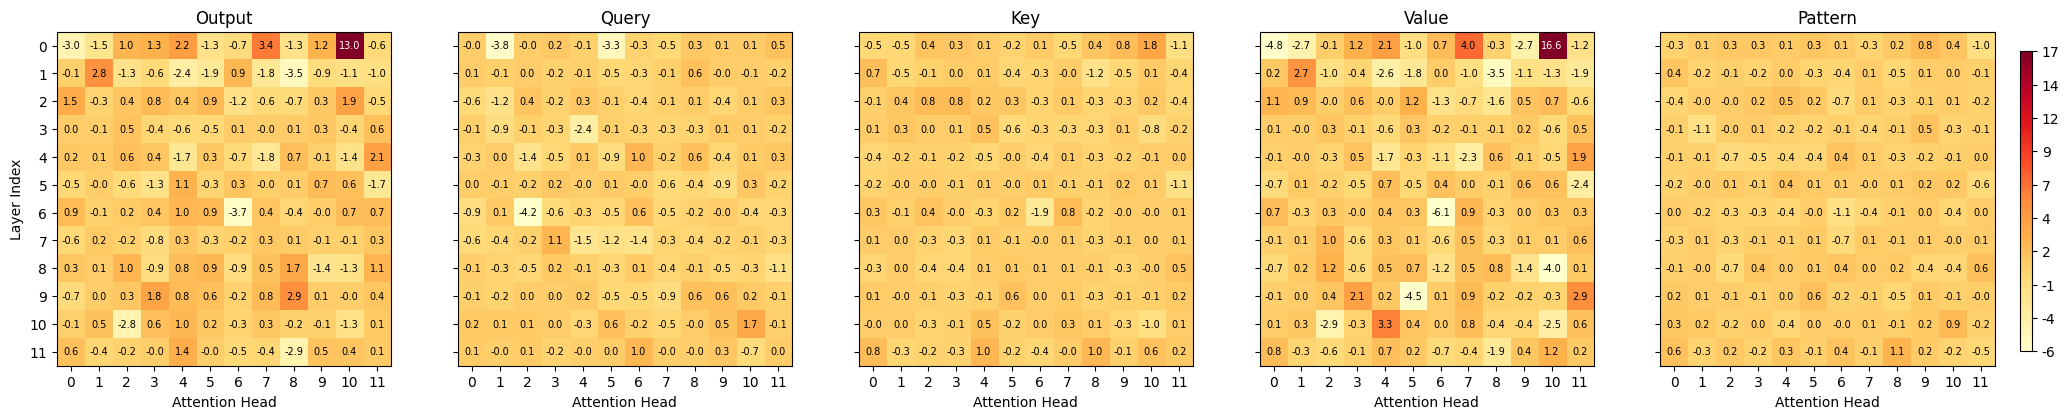

In [199]:
p = every_head_all_pos_act_patch_result * 100
vmin, vmax = -4, 10
mi, ma = p.min().cpu().item(), p.max().cpu().item()
fig, ax = plt.subplots(1,5, figsize=(25,5), sharey=True)
titles = ["Output", "Query", "Key", "Value", "Pattern"]
for i in range(len(ax)):
    n_layers = every_head_all_pos_act_patch_result[i].shape[0]
    n_heads = every_head_all_pos_act_patch_result[i].shape[1]
    im = ax[i].imshow(every_head_all_pos_act_patch_result[i].cpu().numpy()*100,cmap="YlOrRd",vmin=vmin, vmax=vmax)
    thresh = 0.06
    ax[i].set_yticks(range(0,n_layers), range(0,n_layers))
    ax[i].set_xticks(range(0,n_heads), range(0,n_heads))
    ax[i].set_xlabel("Attention Head")
    for j in range(len(every_head_all_pos_act_patch_result[i])):
        for k in range(len(every_head_all_pos_act_patch_result[i][j])):
            val = every_head_all_pos_act_patch_result[i][k][j]
            im.axes.text(j,k,vfmt(val),fontsize=7,ha="center",va="center",color="black" if val < thresh else "white")
    ax[i].set_title(titles[i])
ax[0].set_ylabel("Layer Index")
cb_ax = fig.add_axes([0.91, 0.19, 0.005, 0.6])
cbar=fig.colorbar(im,cax=cb_ax)
cbar.set_ticks(np.linspace(-4,10,10))
cbar.set_ticklabels([int(v) for v in np.round(np.linspace(mi,ma,10))])
plt.savefig("../figures/attn_head_breakdown_all_gpt2_small.pdf")

In [209]:
# patch the mlps
every_block_result = patching.get_act_patch_block_every(model, corr_toks, clean_cache, alignment_metric, batch_size=128)

batch-size 128


  0%|▎                                                                                                                                                                                        | 1/540 [00:05<45:08,  5.03s/it]

-0.0007353792316280305



  0%|▋                                                                                                                                                                                        | 2/540 [00:09<43:40,  4.87s/it]

-0.0011978242546319962



  1%|█                                                                                                                                                                                        | 3/540 [00:14<43:16,  4.84s/it]

-0.0007365490309894085



  1%|█▎                                                                                                                                                                                       | 4/540 [00:19<42:58,  4.81s/it]

-0.0003435570397414267



  1%|█▋                                                                                                                                                                                       | 5/540 [00:24<42:39,  4.78s/it]

-0.0004883802612312138



  1%|██                                                                                                                                                                                       | 6/540 [00:28<42:28,  4.77s/it]

-0.0009132062550634146



  1%|██▍                                                                                                                                                                                      | 7/540 [00:33<42:20,  4.77s/it]

-0.0008661759202368557



  1%|██▋                                                                                                                                                                                      | 8/540 [00:38<42:10,  4.76s/it]

-0.0005579383578151464



  2%|███                                                                                                                                                                                      | 9/540 [00:43<43:22,  4.90s/it]

-0.0005720285116694868



  2%|███▍                                                                                                                                                                                    | 10/540 [00:48<42:49,  4.85s/it]

-0.000535686849616468



  2%|███▋                                                                                                                                                                                    | 11/540 [00:53<42:26,  4.81s/it]

-0.0006378583493642509



  2%|████                                                                                                                                                                                    | 12/540 [00:57<42:07,  4.79s/it]

-0.0004660762788262218



  2%|████▍                                                                                                                                                                                   | 13/540 [01:02<41:52,  4.77s/it]

-0.000585614237934351



  3%|████▊                                                                                                                                                                                   | 14/540 [01:07<41:41,  4.76s/it]

-0.0006211833679117262



  3%|█████                                                                                                                                                                                   | 15/540 [01:12<41:47,  4.78s/it]

-0.000902887899428606



  3%|█████▍                                                                                                                                                                                  | 16/540 [01:16<41:42,  4.78s/it]

-0.0005821370868943632



  3%|█████▊                                                                                                                                                                                  | 17/540 [01:21<41:36,  4.77s/it]

-0.000753846310544759



  3%|██████▏                                                                                                                                                                                 | 18/540 [01:26<41:25,  4.76s/it]

-0.0005869506858289242



  4%|██████▍                                                                                                                                                                                 | 19/540 [01:31<41:16,  4.75s/it]

-0.0006409143679775298



  4%|██████▊                                                                                                                                                                                 | 20/540 [01:35<41:10,  4.75s/it]

-0.0008524951408617198



  4%|███████▏                                                                                                                                                                                | 21/540 [01:40<41:02,  4.75s/it]

-0.0007272069924511015



  4%|███████▍                                                                                                                                                                                | 22/540 [01:45<40:53,  4.74s/it]

-0.0006539489259012043



  4%|███████▊                                                                                                                                                                                | 23/540 [01:49<40:45,  4.73s/it]

-0.0007519085193052888



  4%|████████▏                                                                                                                                                                               | 24/540 [01:55<42:29,  4.94s/it]

-0.000896271551027894



  5%|████████▌                                                                                                                                                                               | 25/540 [02:00<41:52,  4.88s/it]

-0.0007363389013335109



  5%|████████▊                                                                                                                                                                               | 26/540 [02:04<41:24,  4.83s/it]

-0.0007320840959437191



  5%|█████████▏                                                                                                                                                                              | 27/540 [02:09<41:06,  4.81s/it]

-0.0005563682643696666



  5%|█████████▌                                                                                                                                                                              | 28/540 [02:14<40:54,  4.79s/it]

-0.0006518493755720556



  5%|█████████▉                                                                                                                                                                              | 29/540 [02:19<40:47,  4.79s/it]

-0.0005046706646680832



  6%|██████████▏                                                                                                                                                                             | 30/540 [02:23<40:33,  4.77s/it]

-0.0005080472910776734



  6%|██████████▌                                                                                                                                                                             | 31/540 [02:28<40:24,  4.76s/it]

-0.0006149674882180989



  6%|██████████▉                                                                                                                                                                             | 32/540 [02:33<40:11,  4.75s/it]

-0.0006101708859205246



  6%|███████████▏                                                                                                                                                                            | 33/540 [02:38<40:08,  4.75s/it]

-0.0006067751673981547



  6%|███████████▌                                                                                                                                                                            | 34/540 [02:42<40:09,  4.76s/it]

-0.0006518584559671581



  6%|███████████▉                                                                                                                                                                            | 35/540 [02:47<40:11,  4.78s/it]

-0.0007089200662449002



  7%|████████████▎                                                                                                                                                                           | 36/540 [02:52<40:19,  4.80s/it]

-0.0007128710276447237



  7%|████████████▌                                                                                                                                                                           | 37/540 [02:57<40:36,  4.84s/it]

-0.0007301395526155829



  7%|████████████▉                                                                                                                                                                           | 38/540 [03:02<40:23,  4.83s/it]

-0.0007321849698200822



  7%|█████████████▎                                                                                                                                                                          | 39/540 [03:06<40:01,  4.79s/it]

-0.0007353792316280305



  7%|█████████████▋                                                                                                                                                                          | 40/540 [03:11<39:47,  4.77s/it]

-0.0007353792316280305



  8%|█████████████▉                                                                                                                                                                          | 41/540 [03:16<39:36,  4.76s/it]

-0.0007353792316280305



  8%|██████████████▎                                                                                                                                                                         | 42/540 [03:21<39:32,  4.76s/it]

-0.0007353792316280305



  8%|██████████████▋                                                                                                                                                                         | 43/540 [03:25<39:28,  4.76s/it]

-0.0007353792316280305



  8%|██████████████▉                                                                                                                                                                         | 44/540 [03:30<39:31,  4.78s/it]

-0.0007353792316280305



  8%|███████████████▎                                                                                                                                                                        | 45/540 [03:35<39:31,  4.79s/it]

-0.0007353792316280305



  9%|███████████████▋                                                                                                                                                                        | 46/540 [03:40<39:22,  4.78s/it]

-0.0007353650871664286



  9%|████████████████                                                                                                                                                                        | 47/540 [03:45<39:08,  4.76s/it]

-0.0011561053106561303



  9%|████████████████▎                                                                                                                                                                       | 48/540 [03:49<38:57,  4.75s/it]

-0.0007950513972900808



  9%|████████████████▋                                                                                                                                                                       | 49/540 [03:54<38:55,  4.76s/it]

-0.0003962107584811747



  9%|█████████████████                                                                                                                                                                       | 50/540 [03:59<39:03,  4.78s/it]

-0.0005450368043966591



  9%|█████████████████▍                                                                                                                                                                      | 51/540 [04:04<38:57,  4.78s/it]

-0.000918734644073993



 10%|█████████████████▋                                                                                                                                                                      | 52/540 [04:08<38:52,  4.78s/it]

-0.0008076374069787562



 10%|██████████████████                                                                                                                                                                      | 53/540 [04:13<38:47,  4.78s/it]

-0.0006291171885095537



 10%|██████████████████▍                                                                                                                                                                     | 54/540 [04:18<38:39,  4.77s/it]

-0.0006027029012329876



 10%|██████████████████▋                                                                                                                                                                     | 55/540 [04:23<38:34,  4.77s/it]

-0.0005685962387360632



 10%|███████████████████                                                                                                                                                                     | 56/540 [04:28<38:24,  4.76s/it]

-0.0006455944967456162



 11%|███████████████████▍                                                                                                                                                                    | 57/540 [04:32<38:15,  4.75s/it]

-0.0004667155153583735



 11%|███████████████████▊                                                                                                                                                                    | 58/540 [04:37<38:06,  4.74s/it]

-0.0006559888715855777



 11%|████████████████████                                                                                                                                                                    | 59/540 [04:42<38:02,  4.74s/it]

-0.0006292645703069866



 11%|████████████████████▍                                                                                                                                                                   | 60/540 [04:46<38:00,  4.75s/it]

-0.000943224411457777



 11%|████████████████████▊                                                                                                                                                                   | 61/540 [04:51<37:58,  4.76s/it]

-0.0005474190693348646



 11%|█████████████████████▏                                                                                                                                                                  | 62/540 [04:56<38:02,  4.77s/it]

-0.0007816705037839711



 12%|█████████████████████▍                                                                                                                                                                  | 63/540 [05:01<38:01,  4.78s/it]

-0.0005550730274990201



 12%|█████████████████████▊                                                                                                                                                                  | 64/540 [05:06<37:50,  4.77s/it]

-0.00065224728314206



 12%|██████████████████████▏                                                                                                                                                                 | 65/540 [05:10<37:42,  4.76s/it]

-0.000834175618365407



 12%|██████████████████████▍                                                                                                                                                                 | 66/540 [05:15<37:29,  4.75s/it]

-0.0007525316323153675



 12%|██████████████████████▊                                                                                                                                                                 | 67/540 [05:20<37:22,  4.74s/it]

-0.0007124363910406828



 13%|███████████████████████▏                                                                                                                                                                | 68/540 [05:25<37:15,  4.74s/it]

-0.000738899689167738



 13%|███████████████████████▌                                                                                                                                                                | 69/540 [05:29<37:05,  4.72s/it]

-0.0008790274732746184



 13%|███████████████████████▊                                                                                                                                                                | 70/540 [05:34<37:05,  4.73s/it]

-0.0007621131953783333



 13%|████████████████████████▏                                                                                                                                                               | 71/540 [05:39<37:02,  4.74s/it]

-0.0006636651232838631



 13%|████████████████████████▌                                                                                                                                                               | 72/540 [05:43<36:57,  4.74s/it]

-0.0005361651419661939



 14%|████████████████████████▊                                                                                                                                                               | 73/540 [05:48<36:47,  4.73s/it]

-0.0006268106517381966



 14%|█████████████████████████▏                                                                                                                                                              | 74/540 [05:53<36:47,  4.74s/it]

-0.000514273764565587



 14%|█████████████████████████▌                                                                                                                                                              | 75/540 [05:58<36:44,  4.74s/it]

-0.0005113831139169633



 14%|█████████████████████████▉                                                                                                                                                              | 76/540 [06:02<36:32,  4.73s/it]

-0.0005651865503750741



 14%|██████████████████████████▏                                                                                                                                                             | 77/540 [06:07<36:30,  4.73s/it]

-0.0005817683995701373



 14%|██████████████████████████▌                                                                                                                                                             | 78/540 [06:12<36:24,  4.73s/it]

-0.0005291185225360096



 15%|██████████████████████████▉                                                                                                                                                             | 79/540 [06:17<36:18,  4.73s/it]

-0.00064563361229375



 15%|███████████████████████████▎                                                                                                                                                            | 80/540 [06:21<36:11,  4.72s/it]

-0.0007161544053815305



 15%|███████████████████████████▌                                                                                                                                                            | 81/540 [06:26<36:08,  4.72s/it]

-0.000705854850821197



 15%|███████████████████████████▉                                                                                                                                                            | 82/540 [06:31<36:05,  4.73s/it]

-0.0007272915099747479



 15%|████████████████████████████▎                                                                                                                                                           | 83/540 [06:35<35:57,  4.72s/it]

-0.0007309538777917624



 16%|████████████████████████████▌                                                                                                                                                           | 84/540 [06:40<35:53,  4.72s/it]

-0.0007335373084060848



 16%|████████████████████████████▉                                                                                                                                                           | 85/540 [06:45<35:59,  4.75s/it]

-0.0007338557625189424



 16%|█████████████████████████████▎                                                                                                                                                          | 86/540 [06:50<35:47,  4.73s/it]

-0.0007340511656366289



 16%|█████████████████████████████▋                                                                                                                                                          | 87/540 [06:55<36:01,  4.77s/it]

-0.000734037603251636



 16%|█████████████████████████████▉                                                                                                                                                          | 88/540 [06:59<35:52,  4.76s/it]

-0.0007351007661782205



 16%|██████████████████████████████▎                                                                                                                                                         | 89/540 [07:04<35:41,  4.75s/it]

-0.0007350555970333517



 17%|██████████████████████████████▋                                                                                                                                                         | 90/540 [07:09<35:37,  4.75s/it]

-0.0007355536217801273



 17%|███████████████████████████████                                                                                                                                                         | 91/540 [07:13<35:33,  4.75s/it]

-0.0007353877881541848



 17%|███████████████████████████████▎                                                                                                                                                        | 92/540 [07:18<35:24,  4.74s/it]

-0.001027101301588118



 17%|███████████████████████████████▋                                                                                                                                                        | 93/540 [07:23<35:21,  4.75s/it]

-0.0008012616890482605



 17%|████████████████████████████████                                                                                                                                                        | 94/540 [07:28<35:45,  4.81s/it]

-0.0004364659253042191



 18%|████████████████████████████████▎                                                                                                                                                       | 95/540 [07:33<35:26,  4.78s/it]

-0.0005408610450103879



 18%|████████████████████████████████▋                                                                                                                                                       | 96/540 [07:37<35:10,  4.75s/it]

-0.0008628093055449426



 18%|█████████████████████████████████                                                                                                                                                       | 97/540 [07:42<34:57,  4.74s/it]

-0.0007672858191654086



 18%|█████████████████████████████████▍                                                                                                                                                      | 98/540 [07:47<34:49,  4.73s/it]

-0.0006330213509500027



 18%|█████████████████████████████████▋                                                                                                                                                      | 99/540 [07:51<34:46,  4.73s/it]

-0.0005859323428012431



 19%|█████████████████████████████████▉                                                                                                                                                     | 100/540 [07:58<37:55,  5.17s/it]

-0.0005998176638968289



 19%|██████████████████████████████████▏                                                                                                                                                    | 101/540 [08:04<39:56,  5.46s/it]

-0.0006782609852962196



 19%|██████████████████████████████████▌                                                                                                                                                    | 102/540 [08:10<41:28,  5.68s/it]

-0.0005126641481183469



 19%|██████████████████████████████████▉                                                                                                                                                    | 103/540 [08:16<42:36,  5.85s/it]

-0.0006385544547811151



 19%|███████████████████████████████████▏                                                                                                                                                   | 104/540 [08:22<43:14,  5.95s/it]

-0.000629827962256968



 19%|███████████████████████████████████▌                                                                                                                                                   | 105/540 [08:29<43:39,  6.02s/it]

-0.0009061277960427105



 20%|███████████████████████████████████▉                                                                                                                                                   | 106/540 [08:35<43:48,  6.06s/it]

-0.0006114508141763508



 20%|████████████████████████████████████▎                                                                                                                                                  | 107/540 [08:41<43:51,  6.08s/it]

-0.0007591053727082908



 20%|████████████████████████████████████▌                                                                                                                                                  | 108/540 [08:47<43:56,  6.10s/it]

-0.000616688746958971



 20%|████████████████████████████████████▉                                                                                                                                                  | 109/540 [08:53<43:58,  6.12s/it]

-0.0006462152814492583



 20%|█████████████████████████████████████▎                                                                                                                                                 | 110/540 [08:59<43:53,  6.12s/it]

-0.0008253291016444564



 21%|█████████████████████████████████████▌                                                                                                                                                 | 111/540 [09:05<43:50,  6.13s/it]

-0.0007293387898243964



 21%|█████████████████████████████████████▉                                                                                                                                                 | 112/540 [09:12<43:39,  6.12s/it]

-0.0006861978326924145



 21%|██████████████████████████████████████▎                                                                                                                                                | 113/540 [09:17<42:35,  5.99s/it]

-0.0007647123420611024



 21%|██████████████████████████████████████▋                                                                                                                                                | 114/540 [09:22<39:56,  5.63s/it]

-0.0008891906472854316



 21%|██████████████████████████████████████▉                                                                                                                                                | 115/540 [09:27<38:06,  5.38s/it]

-0.0007304633618332446



 21%|███████████████████████████████████████▎                                                                                                                                               | 116/540 [09:32<36:40,  5.19s/it]

-0.0007129509467631578



 22%|███████████████████████████████████████▋                                                                                                                                               | 117/540 [09:36<35:34,  5.05s/it]

-0.0006096047582104802



 22%|███████████████████████████████████████▉                                                                                                                                               | 118/540 [09:41<35:01,  4.98s/it]

-0.0006386117311194539



 22%|████████████████████████████████████████▎                                                                                                                                              | 119/540 [09:46<34:34,  4.93s/it]

-0.0006006296025589108



 22%|████████████████████████████████████████▋                                                                                                                                              | 120/540 [09:51<34:12,  4.89s/it]

-0.0005621802993118763



 22%|█████████████████████████████████████████                                                                                                                                              | 121/540 [09:56<34:02,  4.88s/it]

-0.0006174901500344276



 23%|█████████████████████████████████████████▎                                                                                                                                             | 122/540 [10:00<33:44,  4.84s/it]

-0.0006455773836933076



 23%|█████████████████████████████████████████▋                                                                                                                                             | 123/540 [10:05<33:22,  4.80s/it]

-0.0006298529333434999



 23%|██████████████████████████████████████████                                                                                                                                             | 124/540 [10:10<33:06,  4.77s/it]

-0.0006729334127157927



 23%|██████████████████████████████████████████▎                                                                                                                                            | 125/540 [10:14<32:54,  4.76s/it]

-0.0007236249512061477



 23%|██████████████████████████████████████████▋                                                                                                                                            | 126/540 [10:19<32:51,  4.76s/it]

-0.0007214692304842174



 24%|███████████████████████████████████████████                                                                                                                                            | 127/540 [10:24<32:40,  4.75s/it]

-0.0007329524960368872



 24%|███████████████████████████████████████████▍                                                                                                                                           | 128/540 [10:29<32:36,  4.75s/it]

-0.0007355696288868785



 24%|███████████████████████████████████████████▋                                                                                                                                           | 129/540 [10:33<32:28,  4.74s/it]

-0.0007388280355371535



 24%|████████████████████████████████████████████                                                                                                                                           | 130/540 [10:38<32:31,  4.76s/it]

-0.000739680603146553



 24%|████████████████████████████████████████████▍                                                                                                                                          | 131/540 [10:43<32:29,  4.77s/it]

-0.000739811104722321



 24%|████████████████████████████████████████████▋                                                                                                                                          | 132/540 [10:48<32:22,  4.76s/it]

-0.000740066752769053



 25%|█████████████████████████████████████████████                                                                                                                                          | 133/540 [10:53<32:22,  4.77s/it]

-0.0007410538964904845



 25%|█████████████████████████████████████████████▍                                                                                                                                         | 134/540 [10:57<32:23,  4.79s/it]

-0.0007412511040456593



 25%|█████████████████████████████████████████████▊                                                                                                                                         | 135/540 [11:02<32:19,  4.79s/it]

-0.0007415226427838206



 25%|██████████████████████████████████████████████                                                                                                                                         | 136/540 [11:07<32:15,  4.79s/it]

-0.0007353986729867756



 25%|██████████████████████████████████████████████▍                                                                                                                                        | 137/540 [11:12<32:06,  4.78s/it]

-0.0009720894740894437



 26%|██████████████████████████████████████████████▊                                                                                                                                        | 138/540 [11:16<31:57,  4.77s/it]

-0.0007331565720960498



 26%|███████████████████████████████████████████████                                                                                                                                        | 139/540 [11:21<31:50,  4.77s/it]

-0.0005295758019201458



 26%|███████████████████████████████████████████████▍                                                                                                                                       | 140/540 [11:26<31:45,  4.76s/it]

-0.0005713328719139099



 26%|███████████████████████████████████████████████▊                                                                                                                                       | 141/540 [11:31<31:35,  4.75s/it]

-0.0007974377367645502



 26%|████████████████████████████████████████████████                                                                                                                                       | 142/540 [11:35<31:27,  4.74s/it]

-0.0007498976774513721



 26%|████████████████████████████████████████████████▍                                                                                                                                      | 143/540 [11:40<31:20,  4.74s/it]

-0.000675440183840692



 27%|████████████████████████████████████████████████▊                                                                                                                                      | 144/540 [11:45<31:15,  4.74s/it]

-0.0006114086718298495



 27%|█████████████████████████████████████████████████▏                                                                                                                                     | 145/540 [11:50<31:12,  4.74s/it]

-0.0006030741496942937



 27%|█████████████████████████████████████████████████▍                                                                                                                                     | 146/540 [11:54<31:12,  4.75s/it]

-0.0006633130833506584



 27%|█████████████████████████████████████████████████▊                                                                                                                                     | 147/540 [11:59<31:16,  4.78s/it]

-0.0005331194843165576



 27%|██████████████████████████████████████████████████▏                                                                                                                                    | 148/540 [12:04<31:09,  4.77s/it]

-0.0005833162576891482



 28%|██████████████████████████████████████████████████▍                                                                                                                                    | 149/540 [12:09<30:59,  4.76s/it]

-0.0005995885585434735



 28%|██████████████████████████████████████████████████▊                                                                                                                                    | 150/540 [12:13<30:53,  4.75s/it]

-0.000847184332087636



 28%|███████████████████████████████████████████████████▏                                                                                                                                   | 151/540 [12:18<30:43,  4.74s/it]

-0.0006329817697405815



 28%|███████████████████████████████████████████████████▌                                                                                                                                   | 152/540 [12:23<30:38,  4.74s/it]

-0.0006787428283132613



 28%|███████████████████████████████████████████████████▊                                                                                                                                   | 153/540 [12:28<30:27,  4.72s/it]

-0.0006371346535161138



 29%|████████████████████████████████████████████████████▏                                                                                                                                  | 154/540 [12:32<30:17,  4.71s/it]

-0.000667356769554317



 29%|████████████████████████████████████████████████████▌                                                                                                                                  | 155/540 [12:37<30:17,  4.72s/it]

-0.0008305698283948004



 29%|████████████████████████████████████████████████████▊                                                                                                                                  | 156/540 [12:42<30:12,  4.72s/it]

-0.000716984795872122



 29%|█████████████████████████████████████████████████████▏                                                                                                                                 | 157/540 [12:46<30:10,  4.73s/it]

-0.0007274383096955717



 29%|█████████████████████████████████████████████████████▌                                                                                                                                 | 158/540 [12:51<30:03,  4.72s/it]

-0.0007554566254839301



 29%|█████████████████████████████████████████████████████▉                                                                                                                                 | 159/540 [12:56<30:08,  4.75s/it]

-0.0008506464073434472



 30%|██████████████████████████████████████████████████████▏                                                                                                                                | 160/540 [13:01<30:03,  4.75s/it]

-0.0007967090932652354



 30%|██████████████████████████████████████████████████████▌                                                                                                                                | 161/540 [13:05<29:55,  4.74s/it]

-0.0007379653980024159



 30%|██████████████████████████████████████████████████████▉                                                                                                                                | 162/540 [13:10<29:44,  4.72s/it]

-0.0006528912927024066



 30%|███████████████████████████████████████████████████████▏                                                                                                                               | 163/540 [13:15<29:37,  4.72s/it]

-0.0006487048813141882



 30%|███████████████████████████████████████████████████████▌                                                                                                                               | 164/540 [13:20<29:29,  4.71s/it]

-0.0006254299078136683



 31%|███████████████████████████████████████████████████████▉                                                                                                                               | 165/540 [13:24<29:20,  4.69s/it]

-0.0005754947196692228



 31%|████████████████████████████████████████████████████████▎                                                                                                                              | 166/540 [13:29<29:27,  4.72s/it]

-0.0006220832583494484



 31%|████████████████████████████████████████████████████████▌                                                                                                                              | 167/540 [13:34<29:13,  4.70s/it]

-0.0006523169577121735



 31%|████████████████████████████████████████████████████████▉                                                                                                                              | 168/540 [13:38<29:09,  4.70s/it]

-0.0006426867330446839



 31%|█████████████████████████████████████████████████████████▎                                                                                                                             | 169/540 [13:43<29:06,  4.71s/it]

-0.0006692834431305528



 31%|█████████████████████████████████████████████████████████▌                                                                                                                             | 170/540 [13:48<29:06,  4.72s/it]

-0.0007225190638564527



 32%|█████████████████████████████████████████████████████████▉                                                                                                                             | 171/540 [13:53<29:04,  4.73s/it]

-0.0007210908806882799



 32%|██████████████████████████████████████████████████████████▎                                                                                                                            | 172/540 [13:57<29:11,  4.76s/it]

-0.0007287092739716172



 32%|██████████████████████████████████████████████████████████▋                                                                                                                            | 173/540 [14:02<29:04,  4.75s/it]

-0.0007322639576159418



 32%|██████████████████████████████████████████████████████████▉                                                                                                                            | 174/540 [14:07<28:51,  4.73s/it]

-0.0007355005363933742



 32%|███████████████████████████████████████████████████████████▎                                                                                                                           | 175/540 [14:12<28:43,  4.72s/it]

-0.0007367149228230119



 33%|███████████████████████████████████████████████████████████▋                                                                                                                           | 176/540 [14:16<28:35,  4.71s/it]

-0.0007375697023235261



 33%|███████████████████████████████████████████████████████████▉                                                                                                                           | 177/540 [14:21<28:27,  4.70s/it]

-0.0007379481103271246



 33%|████████████████████████████████████████████████████████████▎                                                                                                                          | 178/540 [14:26<28:23,  4.70s/it]

-0.000738967617508024



 33%|████████████████████████████████████████████████████████████▋                                                                                                                          | 179/540 [14:30<28:22,  4.72s/it]

-0.000739561568479985



 33%|█████████████████████████████████████████████████████████████                                                                                                                          | 180/540 [14:35<28:16,  4.71s/it]

-0.000740091665647924



 34%|█████████████████████████████████████████████████████████████▎                                                                                                                         | 181/540 [14:40<28:14,  4.72s/it]

-0.0007353932014666498



 34%|█████████████████████████████████████████████████████████████▋                                                                                                                         | 182/540 [14:45<28:13,  4.73s/it]

-0.0009146983502432704



 34%|██████████████████████████████████████████████████████████████                                                                                                                         | 183/540 [14:49<28:15,  4.75s/it]

-0.0007649670587852597



 34%|██████████████████████████████████████████████████████████████▎                                                                                                                        | 184/540 [14:54<28:16,  4.77s/it]

-0.0005695756990462542



 34%|██████████████████████████████████████████████████████████████▋                                                                                                                        | 185/540 [14:59<28:10,  4.76s/it]

-0.0006107985391281545



 34%|███████████████████████████████████████████████████████████████                                                                                                                        | 186/540 [15:04<28:01,  4.75s/it]

-0.0007231399649754167



 35%|███████████████████████████████████████████████████████████████▎                                                                                                                       | 187/540 [15:08<27:50,  4.73s/it]

-0.0007607651641592383



 35%|███████████████████████████████████████████████████████████████▋                                                                                                                       | 188/540 [15:13<27:45,  4.73s/it]

-0.0006681826198473573



 35%|████████████████████████████████████████████████████████████████                                                                                                                       | 189/540 [15:18<27:39,  4.73s/it]

-0.0006313218618743122



 35%|████████████████████████████████████████████████████████████████▍                                                                                                                      | 190/540 [15:22<27:33,  4.73s/it]

-0.000613225856795907



 35%|████████████████████████████████████████████████████████████████▋                                                                                                                      | 191/540 [15:27<27:32,  4.73s/it]

-0.0006665968685410917



 36%|█████████████████████████████████████████████████████████████████                                                                                                                      | 192/540 [15:32<27:27,  4.73s/it]

-0.0005499367252923548



 36%|█████████████████████████████████████████████████████████████████▍                                                                                                                     | 193/540 [15:37<27:29,  4.75s/it]

-0.0006481306627392769



 36%|█████████████████████████████████████████████████████████████████▋                                                                                                                     | 194/540 [15:43<30:11,  5.24s/it]

-0.0006112830014899373



 36%|██████████████████████████████████████████████████████████████████                                                                                                                     | 195/540 [15:48<29:17,  5.10s/it]

-0.0007882838253863156



 36%|██████████████████████████████████████████████████████████████████▍                                                                                                                    | 196/540 [15:53<28:46,  5.02s/it]

-0.0006307518924586475



 36%|██████████████████████████████████████████████████████████████████▊                                                                                                                    | 197/540 [15:57<28:13,  4.94s/it]

-0.0006963644409552217



 37%|███████████████████████████████████████████████████████████████████                                                                                                                    | 198/540 [16:02<27:51,  4.89s/it]

-0.000605993380304426



 37%|███████████████████████████████████████████████████████████████████▍                                                                                                                   | 199/540 [16:07<27:30,  4.84s/it]

-0.0006487036007456481



 37%|███████████████████████████████████████████████████████████████████▊                                                                                                                   | 200/540 [16:12<27:12,  4.80s/it]

-0.0007967606070451438



 37%|████████████████████████████████████████████████████████████████████                                                                                                                   | 201/540 [16:16<26:57,  4.77s/it]

-0.0007466532988473773



 37%|████████████████████████████████████████████████████████████████████▍                                                                                                                  | 202/540 [16:21<26:50,  4.76s/it]

-0.0006464432226493955



 38%|████████████████████████████████████████████████████████████████████▊                                                                                                                  | 203/540 [16:26<26:49,  4.78s/it]

-0.000713042332790792



 38%|█████████████████████████████████████████████████████████████████████▏                                                                                                                 | 204/540 [16:31<26:42,  4.77s/it]

-0.0008448794251307845



 38%|█████████████████████████████████████████████████████████████████████▍                                                                                                                 | 205/540 [16:35<26:35,  4.76s/it]

-0.0007606362923979759



 38%|█████████████████████████████████████████████████████████████████████▊                                                                                                                 | 206/540 [16:40<26:24,  4.74s/it]

-0.0008026824798434973



 38%|██████████████████████████████████████████████████████████████████████▏                                                                                                                | 207/540 [16:45<26:17,  4.74s/it]

-0.0006669805734418333



 39%|██████████████████████████████████████████████████████████████████████▍                                                                                                                | 208/540 [16:50<26:12,  4.74s/it]

-0.0006839385605417192



 39%|██████████████████████████████████████████████████████████████████████▊                                                                                                                | 209/540 [16:54<26:08,  4.74s/it]

-0.0006563209462910891



 39%|███████████████████████████████████████████████████████████████████████▏                                                                                                               | 210/540 [16:59<26:03,  4.74s/it]

-0.0006309344316832721



 39%|███████████████████████████████████████████████████████████████████████▌                                                                                                               | 211/540 [17:04<25:59,  4.74s/it]

-0.0006730930181220174



 39%|███████████████████████████████████████████████████████████████████████▊                                                                                                               | 212/540 [17:09<25:56,  4.74s/it]

-0.0006945172790437937



 39%|████████████████████████████████████████████████████████████████████████▏                                                                                                              | 213/540 [17:13<26:03,  4.78s/it]

-0.0006770218606106937



 40%|████████████████████████████████████████████████████████████████████████▌                                                                                                              | 214/540 [17:18<26:01,  4.79s/it]

-0.0007004823419265449



 40%|████████████████████████████████████████████████████████████████████████▊                                                                                                              | 215/540 [17:23<26:03,  4.81s/it]

-0.0007301987498067319



 40%|█████████████████████████████████████████████████████████████████████████▏                                                                                                             | 216/540 [17:28<26:01,  4.82s/it]

-0.0007336546550504863



 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                             | 217/540 [17:33<25:52,  4.81s/it]

-0.000734072586055845



 40%|█████████████████████████████████████████████████████████████████████████▉                                                                                                             | 218/540 [17:38<25:56,  4.84s/it]

-0.0007364843622781336



 41%|██████████████████████████████████████████████████████████████████████████▏                                                                                                            | 219/540 [17:42<25:36,  4.79s/it]

-0.0007374640554189682



 41%|██████████████████████████████████████████████████████████████████████████▌                                                                                                            | 220/540 [17:47<25:23,  4.76s/it]

-0.0007378612062893808



 41%|██████████████████████████████████████████████████████████████████████████▉                                                                                                            | 221/540 [17:52<25:17,  4.76s/it]

-0.0007376012508757412



 41%|███████████████████████████████████████████████████████████████████████████▏                                                                                                           | 222/540 [17:57<25:25,  4.80s/it]

-0.0007374359993264079



 41%|███████████████████████████████████████████████████████████████████████████▌                                                                                                           | 223/540 [18:01<25:18,  4.79s/it]

-0.0007373184780590236



 41%|███████████████████████████████████████████████████████████████████████████▉                                                                                                           | 224/540 [18:06<25:09,  4.78s/it]

-0.0007374604465439916



 42%|████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 225/540 [18:11<25:20,  4.83s/it]

-0.0007372067775577307



 42%|████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 226/540 [18:16<25:19,  4.84s/it]

-0.0007353948894888163



 42%|████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 227/540 [18:21<25:15,  4.84s/it]

-0.0008763904334045947



 42%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 228/540 [18:26<24:58,  4.80s/it]

-0.0007870622212067246



 42%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 229/540 [18:30<24:45,  4.78s/it]

-0.000575619749724865



 43%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 230/540 [18:35<24:38,  4.77s/it]

-0.0006359649705700576



 43%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 231/540 [18:40<24:31,  4.76s/it]

-0.0007201156695373356



 43%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 232/540 [18:45<24:29,  4.77s/it]

-0.0007303939783014357



 43%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 233/540 [18:49<24:24,  4.77s/it]

-0.000649744994007051



 43%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 234/540 [18:54<24:19,  4.77s/it]

-0.0006531768012791872



 44%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 235/540 [18:59<24:08,  4.75s/it]

-0.000635267177131027



 44%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 236/540 [19:04<24:05,  4.76s/it]

-0.0006941108731552958



 44%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 237/540 [19:08<24:01,  4.76s/it]

-0.0005610114894807339



 44%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 238/540 [19:13<23:58,  4.76s/it]

-0.0005802690866403282



 44%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 239/540 [19:18<23:56,  4.77s/it]

-0.0006250531878322363



 44%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 240/540 [19:23<23:51,  4.77s/it]

-0.0007687403121963143



 45%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 241/540 [19:27<23:45,  4.77s/it]

-0.0006053842953406274



 45%|██████████████████████████████████████████████████████████████████████████████████                                                                                                     | 242/540 [19:32<23:47,  4.79s/it]

-0.0006878582062199712



 45%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 243/540 [19:37<23:47,  4.81s/it]

-0.0006527712102979422



 45%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 244/540 [19:42<23:38,  4.79s/it]

-0.0006764695863239467



 45%|███████████████████████████████████████████████████████████████████████████████████                                                                                                    | 245/540 [19:47<23:31,  4.79s/it]

-0.0007966949488036335



 46%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 246/540 [19:51<23:22,  4.77s/it]

-0.0007260184502229095



 46%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 247/540 [19:56<23:15,  4.76s/it]

-0.0006948970258235931



 46%|████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 248/540 [20:01<23:06,  4.75s/it]

-0.0007463623187504709



 46%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 249/540 [20:06<23:01,  4.75s/it]

-0.0008029220043681562



 46%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 250/540 [20:10<22:56,  4.75s/it]

-0.0007744176546111703



 46%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 251/540 [20:15<22:54,  4.75s/it]

-0.0007436592131853104



 47%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 252/540 [20:20<22:48,  4.75s/it]

-0.000681525154504925



 47%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 253/540 [20:25<22:40,  4.74s/it]

-0.0006916413549333811



 47%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 254/540 [20:29<22:33,  4.73s/it]

-0.0006669665453955531



 47%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 255/540 [20:34<22:26,  4.73s/it]

-0.0006606100359931588



 47%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 256/540 [20:39<22:21,  4.72s/it]

-0.0006717783398926258



 48%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                | 257/540 [20:43<22:18,  4.73s/it]

-0.000701625132933259



 48%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 258/540 [20:48<22:11,  4.72s/it]

-0.0006844131276011467



 48%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 259/540 [20:53<22:07,  4.72s/it]

-0.0007029236876405776



 48%|████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 260/540 [20:58<22:03,  4.73s/it]

-0.0007310918881557882



 48%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 261/540 [21:02<21:55,  4.72s/it]

-0.0007294099195860326



 49%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 262/540 [21:07<21:49,  4.71s/it]

-0.0007321300217881799



 49%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 263/540 [21:12<21:43,  4.71s/it]

-0.000734616129193455



 49%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 264/540 [21:16<21:41,  4.72s/it]

-0.0007359968149103224



 49%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 265/540 [21:21<21:39,  4.73s/it]

-0.000736016605515033



 49%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 266/540 [21:26<21:35,  4.73s/it]

-0.000736458576284349



 49%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 267/540 [21:31<21:29,  4.72s/it]

-0.0007366151548922062



 50%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 268/540 [21:35<21:26,  4.73s/it]

-0.0007371290703304112



 50%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 269/540 [21:40<21:20,  4.73s/it]

-0.0007372891996055841



 50%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 270/540 [21:45<21:16,  4.73s/it]

-0.0007373542757704854



 50%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 271/540 [21:50<21:12,  4.73s/it]

-0.0007353760302066803



 50%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 272/540 [21:54<21:07,  4.73s/it]

-0.000846599752549082



 51%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 273/540 [21:59<21:03,  4.73s/it]

-0.0007997763459570706



 51%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 274/540 [22:04<20:56,  4.72s/it]

-0.0005790513823740184



 51%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 275/540 [22:08<20:48,  4.71s/it]

-0.0006554137798957527



 51%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 276/540 [22:13<20:42,  4.70s/it]

-0.0007368799997493625



 51%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 277/540 [22:18<20:39,  4.71s/it]

-0.0007094424800015986



 51%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 278/540 [22:23<20:35,  4.72s/it]

-0.0006659012287855148



 52%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 279/540 [22:27<20:28,  4.71s/it]

-0.0006687223212793469



 52%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 280/540 [22:32<20:22,  4.70s/it]

-0.0006644561653956771



 52%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 281/540 [22:37<20:31,  4.76s/it]

-0.0007104833493940532



 52%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 282/540 [22:42<20:25,  4.75s/it]

-0.0005738374893553555



 52%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 283/540 [22:46<20:17,  4.74s/it]

-0.000608957780059427



 53%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 284/540 [22:51<20:11,  4.73s/it]

-0.0006494101253338158



 53%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 285/540 [22:56<20:06,  4.73s/it]

-0.0007457767496816814



 53%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 286/540 [23:00<19:59,  4.72s/it]

-0.0006196002359502017



 53%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 287/540 [23:05<19:53,  4.72s/it]

-0.000700502481777221



 53%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 288/540 [23:10<19:50,  4.72s/it]

-0.0006700745434500277



 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 289/540 [23:15<19:46,  4.73s/it]

-0.0006824524025432765



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 290/540 [23:19<19:43,  4.73s/it]

-0.000800536829046905



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 291/540 [23:24<19:39,  4.74s/it]

-0.0007295201066881418



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 292/540 [23:29<19:35,  4.74s/it]

-0.0007179938838817179



 54%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 293/540 [23:34<19:31,  4.74s/it]

-0.0007424670620821416



 54%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 294/540 [23:38<19:27,  4.75s/it]

-0.0007973713800311089



 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 295/540 [23:43<19:21,  4.74s/it]

-0.0007763675530441105



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 296/540 [23:48<19:13,  4.73s/it]

-0.0007509012939408422



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 297/540 [23:52<19:08,  4.73s/it]

-0.0007022799691185355



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 298/540 [23:57<19:07,  4.74s/it]

-0.0007138624205254018



 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 299/540 [24:02<18:59,  4.73s/it]

-0.0006791716441512108



 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 300/540 [24:07<19:05,  4.77s/it]

-0.0006946185603737831



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 301/540 [24:12<18:58,  4.76s/it]

-0.0007004220969974995



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 302/540 [24:16<18:51,  4.75s/it]

-0.0007163508562371135



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 303/540 [24:21<18:44,  4.75s/it]

-0.0007026069215498865



 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 304/540 [24:26<18:40,  4.75s/it]

-0.0007091427687555552



 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 305/540 [24:30<18:31,  4.73s/it]

-0.0007350394735112786



 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 306/540 [24:35<18:20,  4.70s/it]

-0.0007345514022745192



 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 307/540 [24:40<18:13,  4.69s/it]

-0.0007326831109821796



 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 308/540 [24:44<18:05,  4.68s/it]

-0.0007347391219809651



 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 309/540 [24:49<17:59,  4.67s/it]

-0.0007358966977335513



 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 310/540 [24:54<17:56,  4.68s/it]

-0.0007359579321928322



 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 311/540 [24:59<17:57,  4.71s/it]

-0.0007360265590250492



 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 312/540 [25:03<17:54,  4.71s/it]

-0.0007360310992226005



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 313/540 [25:08<17:52,  4.73s/it]

-0.0007364276680164039



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 314/540 [25:13<17:44,  4.71s/it]

-0.0007363036274909973



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 315/540 [25:17<17:39,  4.71s/it]

-0.0007362885517068207



 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 316/540 [25:22<17:34,  4.71s/it]

-0.000735401117708534



 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 317/540 [25:27<17:32,  4.72s/it]

-0.0008349243435077369



 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 318/540 [25:32<17:32,  4.74s/it]

-0.0007823226624168456



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 319/540 [25:36<17:28,  4.74s/it]

-0.0006044277688488364



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 320/540 [25:41<17:23,  4.74s/it]

-0.0006884567555971444



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 321/540 [25:46<17:21,  4.75s/it]

-0.0007552612805739045



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 322/540 [25:51<17:13,  4.74s/it]

-0.0006849666824564338



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 323/540 [25:55<17:08,  4.74s/it]

-0.0006741077522747219



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 324/540 [26:00<17:07,  4.76s/it]

-0.0007000375189818442



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 325/540 [26:05<17:04,  4.77s/it]

-0.0006900507141835988



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 326/540 [26:10<16:58,  4.76s/it]

-0.0007453608559444547



 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 327/540 [26:14<16:50,  4.74s/it]

-0.0005971639766357839



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 328/540 [26:19<16:43,  4.73s/it]

-0.0006304685957729816



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 329/540 [26:24<16:39,  4.74s/it]

-0.0006524547934532166



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 330/540 [26:29<16:32,  4.72s/it]

-0.0007152544567361474



 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 331/540 [26:33<16:27,  4.73s/it]

-0.000644517014734447



 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 332/540 [26:38<16:24,  4.73s/it]

-0.0007043963996693492



 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 333/540 [26:43<16:17,  4.72s/it]

-0.0006677275523543358



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 334/540 [26:47<16:12,  4.72s/it]

-0.0006905002519488335



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 335/540 [26:52<16:09,  4.73s/it]

-0.0007878578617237508



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 336/540 [26:57<16:05,  4.73s/it]

-0.000739462673664093



 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 337/540 [27:02<15:57,  4.72s/it]

-0.0007436181185767055



 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 338/540 [27:06<15:53,  4.72s/it]

-0.0007553959148935974



 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 339/540 [27:11<15:48,  4.72s/it]

-0.0007868224056437612



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 340/540 [27:16<15:42,  4.71s/it]

-0.0007530009606853127



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 341/540 [27:20<15:36,  4.71s/it]

-0.0007406194345094264



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 342/540 [27:25<15:30,  4.70s/it]

-0.0007177371880970895



 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 343/540 [27:30<15:25,  4.70s/it]

-0.0007246288005262613



 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 344/540 [27:35<15:26,  4.73s/it]

-0.0006817349349148571



 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 345/540 [27:39<15:26,  4.75s/it]

-0.0007058879709802568



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 346/540 [27:44<15:21,  4.75s/it]

-0.0007030244451016188



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 347/540 [27:49<15:14,  4.74s/it]

-0.0007218351820483804



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 348/540 [27:54<15:05,  4.72s/it]

-0.0007064325036481023



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 349/540 [27:58<14:59,  4.71s/it]

-0.0007163863047026098



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 350/540 [28:03<14:52,  4.70s/it]

-0.0007363068871200085



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 351/540 [28:08<14:48,  4.70s/it]

-0.000735290115699172



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 352/540 [28:12<14:43,  4.70s/it]

-0.0007332732784561813



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 353/540 [28:17<14:39,  4.70s/it]

-0.0007313254754990339



 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 354/540 [28:22<14:32,  4.69s/it]

-0.0007315673865377903



 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 355/540 [28:26<14:27,  4.69s/it]

-0.0007319362484849989



 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 356/540 [28:31<14:22,  4.69s/it]

-0.0007319513242691755



 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 357/540 [28:36<14:16,  4.68s/it]

-0.000732226821128279



 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 358/540 [28:40<14:13,  4.69s/it]

-0.0007328182691708207



 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 359/540 [28:45<14:09,  4.69s/it]

-0.0007329873624257743



 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 360/540 [28:50<14:02,  4.68s/it]

-0.0007337397546507418



 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 361/540 [28:55<14:00,  4.69s/it]

-0.0007355413981713355



 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 362/540 [28:59<13:54,  4.69s/it]

-0.0008149796049110591



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 363/540 [29:04<13:47,  4.68s/it]

-0.0007777686114422977



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 364/540 [29:09<13:43,  4.68s/it]

-0.0006216962938196957



 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 365/540 [29:13<13:38,  4.68s/it]

-0.0007013159338384867



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 366/540 [29:18<13:34,  4.68s/it]

-0.0007485022651962936



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 367/540 [29:23<13:28,  4.68s/it]

-0.0006679404759779572



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 368/540 [29:27<13:23,  4.67s/it]

-0.00068895478034392



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 369/540 [29:32<13:19,  4.67s/it]

-0.0007265435415320098



 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 370/540 [29:37<13:14,  4.67s/it]

-0.0007334503461606801



 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 371/540 [29:41<13:13,  4.70s/it]

-0.0007739342399872839



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 372/540 [29:46<13:09,  4.70s/it]

-0.0006223249365575612



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 373/540 [29:51<13:05,  4.71s/it]

-0.0006601185305044055



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 374/540 [29:55<13:01,  4.71s/it]

-0.0006891760276630521



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 375/540 [30:00<12:55,  4.70s/it]

-0.0007205851725302637



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 376/540 [30:05<12:50,  4.70s/it]

-0.0006736674113199115



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 377/540 [30:09<12:44,  4.69s/it]

-0.0007250461494550109



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 378/540 [30:14<12:40,  4.70s/it]

-0.0006853036466054618



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 379/540 [30:19<12:35,  4.70s/it]

-0.0006999981123954058



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 380/540 [30:24<12:30,  4.69s/it]

-0.00078030169242993



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 381/540 [30:28<12:27,  4.70s/it]

-0.0007504835375584662



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 382/540 [30:33<12:22,  4.70s/it]

-0.0007563538383692503



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 383/540 [30:38<12:18,  4.70s/it]

-0.000754646142013371



 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 384/540 [30:42<12:14,  4.71s/it]

-0.0007797347498126328



 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 385/540 [30:47<12:12,  4.73s/it]

-0.0007531539304181933



 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 386/540 [30:52<12:08,  4.73s/it]

-0.0007415543077513576



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 387/540 [30:57<12:03,  4.73s/it]

-0.0007380777387879789



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 388/540 [31:01<11:56,  4.71s/it]

-0.0007362947217188776



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 389/540 [31:06<11:50,  4.71s/it]

-0.0006932797259651124



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 390/540 [31:11<11:44,  4.69s/it]

-0.0007246710010804236



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 391/540 [31:17<12:54,  5.20s/it]

-0.000710042251739651



 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 392/540 [31:22<12:25,  5.04s/it]

-0.0007329036016017199



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 393/540 [31:26<12:04,  4.93s/it]

-0.0007186116999946535



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 394/540 [31:31<11:48,  4.85s/it]

-0.0007218457176350057



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 395/540 [31:36<11:35,  4.80s/it]

-0.0007371916435658932



 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 396/540 [31:40<11:25,  4.76s/it]

-0.0007356542046181858



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 397/540 [31:45<11:18,  4.74s/it]

-0.0007334058173000813



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 398/540 [31:50<11:13,  4.74s/it]

-0.000730609055608511



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 399/540 [31:55<11:07,  4.73s/it]

-0.000729803869035095



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 400/540 [31:59<11:02,  4.73s/it]

-0.0007298131240531802



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 401/540 [32:04<10:56,  4.72s/it]

-0.0007298987475223839



 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/540 [32:09<10:54,  4.74s/it]

-0.0007298687123693526



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 403/540 [32:13<10:48,  4.73s/it]

-0.0007304027094505727



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/540 [32:18<10:43,  4.73s/it]

-0.0007313771056942642



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 405/540 [32:23<10:38,  4.73s/it]

-0.0007321161683648825



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 406/540 [32:28<10:31,  4.71s/it]

-0.0007354146800935268



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 407/540 [32:32<10:27,  4.72s/it]

-0.0007975840708240867



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 408/540 [32:37<10:21,  4.71s/it]

-0.0007689138874411583



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 409/540 [32:42<10:17,  4.71s/it]

-0.0006550807738676667



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 410/540 [32:46<10:11,  4.71s/it]

-0.0007173746707849205



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 411/540 [32:51<10:06,  4.70s/it]

-0.000739929499104619



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 412/540 [32:56<10:03,  4.71s/it]

-0.0006544047500938177



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 413/540 [33:01<09:58,  4.71s/it]

-0.0006912567187100649



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 414/540 [33:05<09:51,  4.70s/it]

-0.0007464064401574433



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 415/540 [33:10<09:46,  4.69s/it]

-0.0007673231302760541



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 416/540 [33:15<09:41,  4.69s/it]

-0.0007974363397806883



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 417/540 [33:19<09:36,  4.68s/it]

-0.0006556006264872849



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 418/540 [33:24<09:31,  4.69s/it]

-0.0006881909794174135



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 419/540 [33:29<09:27,  4.69s/it]

-0.0006976394797675312



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 420/540 [33:33<09:22,  4.69s/it]

-0.0007318538264371455



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 421/540 [33:38<09:17,  4.69s/it]

-0.0006973164854571223



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 422/540 [33:43<09:13,  4.69s/it]

-0.0007393447449430823



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 423/540 [33:47<09:08,  4.68s/it]

-0.000691501481924206



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 424/540 [33:52<09:03,  4.68s/it]

-0.000708869774825871



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 425/540 [33:57<08:59,  4.69s/it]

-0.0007802028558216989



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 426/540 [34:02<08:55,  4.69s/it]

-0.0007579511730000377



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 427/540 [34:06<08:49,  4.69s/it]

-0.0007718910928815603



 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 428/540 [34:11<08:44,  4.68s/it]

-0.0007498079794459045



 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 429/540 [34:16<08:40,  4.69s/it]

-0.0007719027926214039



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 430/540 [34:20<08:34,  4.68s/it]

-0.000752272258978337



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 431/540 [34:25<08:28,  4.67s/it]

-0.0007508084527216852



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 432/540 [34:30<08:23,  4.66s/it]

-0.0007590905879624188



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 433/540 [34:34<08:18,  4.65s/it]

-0.0007462106877937913



 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 434/540 [34:39<08:14,  4.67s/it]

-0.0007109952275641263



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 435/540 [34:44<08:10,  4.67s/it]

-0.0007423225906677544



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 436/540 [34:48<08:05,  4.67s/it]

-0.0007218497921712697



 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 437/540 [34:53<08:00,  4.67s/it]

-0.000742951815482229



 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 438/540 [34:58<07:56,  4.67s/it]

-0.0007295588147826493



 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 439/540 [35:02<07:51,  4.67s/it]

-0.0007311973604373634



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 440/540 [35:07<07:50,  4.70s/it]

-0.0007405136129818857



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 441/540 [35:12<07:44,  4.69s/it]

-0.000737065973225981



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 442/540 [35:16<07:39,  4.69s/it]

-0.000733645458240062



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 443/540 [35:21<07:33,  4.68s/it]

-0.0007291224901564419



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 444/540 [35:26<07:28,  4.67s/it]

-0.0007271849317476153



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 445/540 [35:30<07:22,  4.66s/it]

-0.0007274587405845523



 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 446/540 [35:35<07:17,  4.66s/it]

-0.0007275870302692056



 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 447/540 [35:40<07:12,  4.66s/it]

-0.0007277686963789165



 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 448/540 [35:44<07:08,  4.66s/it]

-0.000728502927813679



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 449/540 [35:49<07:04,  4.66s/it]

-0.0007291127112694085



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 450/540 [35:54<07:00,  4.67s/it]

-0.0007293192902579904



 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 451/540 [35:58<06:56,  4.68s/it]

-0.0007353881374001503



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 452/540 [36:03<06:52,  4.69s/it]

-0.0007759347790852189



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 453/540 [36:08<06:47,  4.68s/it]

-0.0007686886237934232



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 454/540 [36:12<06:42,  4.68s/it]

-0.0006880643195472658



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 455/540 [36:17<06:36,  4.67s/it]

-0.0007209241739474237



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 456/540 [36:22<06:32,  4.67s/it]

-0.0007399485912173986



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 457/540 [36:26<06:28,  4.68s/it]

-0.0006504154880531132



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 458/540 [36:31<06:23,  4.67s/it]

-0.0007012372952885926



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 459/540 [36:36<06:19,  4.69s/it]

-0.0007589578162878752



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 460/540 [36:40<06:15,  4.69s/it]

-0.0007912102737464011



 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 461/540 [36:45<06:12,  4.71s/it]

-0.0008242299663834274



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 462/540 [36:50<06:07,  4.71s/it]

-0.0006825685268267989



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 463/540 [36:55<06:05,  4.74s/it]

-0.0007135191699489951



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 464/540 [36:59<05:59,  4.73s/it]

-0.0007015854935161769



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 465/540 [37:04<05:53,  4.72s/it]

-0.000734313449356705



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 466/540 [37:09<05:48,  4.71s/it]

-0.0007132491446100175



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 467/540 [37:13<05:42,  4.69s/it]

-0.0007587631116621196



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 468/540 [37:18<05:38,  4.70s/it]

-0.0006980436155572534



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 469/540 [37:23<05:33,  4.70s/it]

-0.0007142764516174793



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 470/540 [37:28<05:31,  4.73s/it]

-0.000775950844399631



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 471/540 [37:32<05:24,  4.71s/it]

-0.0007594109047204256



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 472/540 [37:37<05:19,  4.70s/it]

-0.0007886854582466185



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 473/540 [37:42<05:14,  4.69s/it]

-0.000739955750759691



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 474/540 [37:46<05:09,  4.68s/it]

-0.0007569866138510406



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 475/540 [37:51<05:04,  4.68s/it]

-0.0007480175700038671



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 476/540 [37:56<05:00,  4.69s/it]

-0.0007621823460794985



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 477/540 [38:00<04:54,  4.68s/it]

-0.0007845216314308345



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 478/540 [38:05<04:50,  4.69s/it]

-0.0007621612166985869



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 479/540 [38:10<04:46,  4.69s/it]

-0.0007243792642839253



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 480/540 [38:14<04:40,  4.67s/it]

-0.0007588383741676807



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 481/540 [38:19<04:35,  4.67s/it]

-0.0007308187196031213



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 482/540 [38:24<04:31,  4.68s/it]

-0.0007565435953438282



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 483/540 [38:28<04:25,  4.67s/it]

-0.0007383584161289036



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 484/540 [38:33<04:20,  4.66s/it]

-0.0007405106443911791



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 485/540 [38:38<04:16,  4.66s/it]

-0.0007413738640025258



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 486/540 [38:42<04:11,  4.65s/it]

-0.0007374170236289501



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 487/540 [38:47<04:07,  4.66s/it]

-0.0007321438752114773



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 488/540 [38:52<04:02,  4.67s/it]

-0.0007283146842382848



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 489/540 [38:56<03:59,  4.69s/it]

-0.0007258953992277384



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 490/540 [39:01<03:53,  4.67s/it]

-0.0007261348655447364



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 491/540 [39:06<03:48,  4.66s/it]

-0.000726565602235496



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 492/540 [39:10<03:43,  4.66s/it]

-0.0007271908107213676



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 493/540 [39:15<03:39,  4.67s/it]

-0.0007275076350197196



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 494/540 [39:20<03:34,  4.66s/it]

-0.0007279850542545319



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 495/540 [39:24<03:30,  4.67s/it]

-0.0007282135193236172



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 496/540 [39:29<03:25,  4.68s/it]

-0.0007353884284384549



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 497/540 [39:34<03:21,  4.68s/it]

-0.0007537465426139534



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 498/540 [39:38<03:16,  4.67s/it]

-0.0007599633536301553



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 499/540 [39:43<03:11,  4.67s/it]

-0.000712372362613678



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 500/540 [39:48<03:06,  4.65s/it]

-0.000727495236787945



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 501/540 [39:52<03:01,  4.66s/it]

-0.0007411435944959521



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 502/540 [39:57<02:57,  4.68s/it]

-0.0006607050308957696



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 503/540 [40:02<02:52,  4.67s/it]

-0.0007079101051203907



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 504/540 [40:06<02:48,  4.68s/it]

-0.0007665258599445224



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 505/540 [40:11<02:43,  4.68s/it]

-0.0008151661022566259



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 506/540 [40:16<02:39,  4.68s/it]

-0.0008474079077132046



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 507/540 [40:20<02:34,  4.67s/it]

-0.0007172533078119159



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 508/540 [40:25<02:29,  4.67s/it]

-0.0007608511950820684



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 509/540 [40:30<02:25,  4.68s/it]

-0.0007288521737791598



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 510/540 [40:35<02:20,  4.68s/it]

-0.0007378441514447331



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 511/540 [40:39<02:16,  4.70s/it]

-0.0007363138138316572



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 512/540 [40:44<02:11,  4.68s/it]

-0.0007877082680352032



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 513/540 [40:49<02:06,  4.69s/it]

-0.0007125255069695413



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 514/540 [40:53<02:01,  4.69s/it]

-0.000733694527298212



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 515/540 [40:58<01:57,  4.69s/it]

-0.0007877920870669186



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 516/540 [41:03<01:52,  4.68s/it]

-0.0007676740642637014



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 517/540 [41:07<01:47,  4.67s/it]

-0.0007949632126837969



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 518/540 [41:12<01:42,  4.65s/it]

-0.000737377384211868



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 519/540 [41:17<01:37,  4.66s/it]

-0.0007525014807470143



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 520/540 [41:21<01:32,  4.65s/it]

-0.0007460046326741576



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 521/540 [41:26<01:28,  4.64s/it]

-0.0007632419001311064



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 522/540 [41:31<01:23,  4.65s/it]

-0.0008053683559410274



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 523/540 [41:35<01:19,  4.65s/it]

-0.0007669675978831947



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 524/540 [41:40<01:14,  4.64s/it]

-0.0007337096030823886



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 525/540 [41:44<01:09,  4.65s/it]

-0.000778373796492815



 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 526/540 [41:49<01:05,  4.67s/it]

-0.0007373732514679432



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 527/540 [41:54<01:00,  4.68s/it]

-0.0007706250180490315



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 528/540 [41:59<00:56,  4.68s/it]

-0.0007468743133358657



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 529/540 [42:03<00:51,  4.68s/it]

-0.0007511890144087374



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 530/540 [42:08<00:46,  4.68s/it]

-0.0007486172253265977



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 531/540 [42:13<00:42,  4.67s/it]

-0.0007408049423247576



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 532/540 [42:17<00:37,  4.65s/it]

-0.0007335812551900744



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 533/540 [42:22<00:32,  4.71s/it]

-0.0007285947795026004



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 534/540 [42:27<00:28,  4.71s/it]

-0.0007262702565640211



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 535/540 [42:31<00:23,  4.67s/it]

-0.0007266484317369759



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 536/540 [42:36<00:18,  4.64s/it]

-0.0007269094930961728



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 537/540 [42:40<00:13,  4.63s/it]

-0.0007273131050169468



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 538/540 [42:45<00:09,  4.62s/it]

-0.0007277342374436557



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 539/540 [42:50<00:04,  4.62s/it]

-0.0007283544400706887



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 540/540 [42:54<00:00,  4.77s/it]

-0.000729008112102747
batch-size 128



  0%|▎                                                                                                                                                                                        | 1/540 [00:05<45:17,  5.04s/it]

-0.0007353930850513279



  0%|▋                                                                                                                                                                                        | 2/540 [00:09<42:58,  4.79s/it]

-0.0007455598679371178



  1%|█                                                                                                                                                                                        | 3/540 [00:14<42:09,  4.71s/it]

-0.0007412121631205082



  1%|█▎                                                                                                                                                                                       | 4/540 [00:18<41:42,  4.67s/it]

-0.0007348714279942214



  1%|█▋                                                                                                                                                                                       | 5/540 [00:23<41:26,  4.65s/it]

-0.000735545763745904



  1%|██                                                                                                                                                                                       | 6/540 [00:28<41:11,  4.63s/it]

-0.0007283182349056005



  1%|██▍                                                                                                                                                                                      | 7/540 [00:32<40:59,  4.61s/it]

-0.0007282372680492699



  1%|██▋                                                                                                                                                                                      | 8/540 [00:37<40:52,  4.61s/it]

-0.0007518642814829946



  2%|███                                                                                                                                                                                      | 9/540 [00:41<40:47,  4.61s/it]

-0.0007172325858846307



  2%|███▍                                                                                                                                                                                    | 10/540 [00:46<40:33,  4.59s/it]

-0.0007217900129035115



  2%|███▋                                                                                                                                                                                    | 11/540 [00:51<40:28,  4.59s/it]

-0.000714023073669523



  2%|████                                                                                                                                                                                    | 12/540 [00:55<40:21,  4.59s/it]

-0.0007310115615837276



  2%|████▍                                                                                                                                                                                   | 13/540 [01:00<40:30,  4.61s/it]

-0.0007216412341222167



  3%|████▊                                                                                                                                                                                   | 14/540 [01:04<40:19,  4.60s/it]

-0.0007228660397231579



  3%|█████                                                                                                                                                                                   | 15/540 [01:09<40:11,  4.59s/it]

-0.0007414444116875529



  3%|█████▍                                                                                                                                                                                  | 16/540 [01:14<40:14,  4.61s/it]

-0.000731875014025718



  3%|█████▊                                                                                                                                                                                  | 17/540 [01:18<40:12,  4.61s/it]

-0.0007340923766605556



  3%|██████▏                                                                                                                                                                                 | 18/540 [01:23<39:57,  4.59s/it]

-0.000740404415410012



  4%|██████▍                                                                                                                                                                                 | 19/540 [01:27<39:55,  4.60s/it]

-0.0007444005459547043



  4%|██████▊                                                                                                                                                                                 | 20/540 [01:32<39:42,  4.58s/it]

-0.0007461583591066301



  4%|███████▏                                                                                                                                                                                | 21/540 [01:36<39:33,  4.57s/it]

-0.0007608291925862432



  4%|███████▍                                                                                                                                                                                | 22/540 [01:41<39:26,  4.57s/it]

-0.0007514177123084664



  4%|███████▊                                                                                                                                                                                | 23/540 [01:46<39:33,  4.59s/it]

-0.0007428211392834783



  4%|████████▏                                                                                                                                                                               | 24/540 [01:50<39:29,  4.59s/it]

-0.0007584840059280396



  5%|████████▌                                                                                                                                                                               | 25/540 [01:55<39:28,  4.60s/it]

-0.0007511150906793773



  5%|████████▊                                                                                                                                                                               | 26/540 [01:59<39:29,  4.61s/it]

-0.0007248370093293488



  5%|█████████▏                                                                                                                                                                              | 27/540 [02:04<39:18,  4.60s/it]

-0.000725705293007195



  5%|█████████▌                                                                                                                                                                              | 28/540 [02:09<39:09,  4.59s/it]

-0.0007026937091723084



  5%|█████████▉                                                                                                                                                                              | 29/540 [02:13<39:07,  4.59s/it]

-0.0006998187745921314



  6%|██████████▏                                                                                                                                                                             | 30/540 [02:18<39:03,  4.59s/it]

-0.0006946308421902359



  6%|██████████▌                                                                                                                                                                             | 31/540 [02:22<39:09,  4.62s/it]

-0.0006959694437682629



  6%|██████████▉                                                                                                                                                                             | 32/540 [02:27<39:08,  4.62s/it]

-0.0007019131444394588



  6%|███████████▏                                                                                                                                                                            | 33/540 [02:32<39:03,  4.62s/it]

-0.0007104974356479943



  6%|███████████▌                                                                                                                                                                            | 34/540 [02:36<39:14,  4.65s/it]

-0.0007086730329319835



  6%|███████████▉                                                                                                                                                                            | 35/540 [02:41<39:11,  4.66s/it]

-0.0007230847841128707



  7%|████████████▎                                                                                                                                                                           | 36/540 [02:46<38:55,  4.63s/it]

-0.0007237867102958262



  7%|████████████▌                                                                                                                                                                           | 37/540 [02:50<38:55,  4.64s/it]

-0.0007327203638851643



  7%|████████████▉                                                                                                                                                                           | 38/540 [02:55<38:49,  4.64s/it]

-0.0007318666903302073



  7%|█████████████▎                                                                                                                                                                          | 39/540 [03:00<39:09,  4.69s/it]

-0.0007335486588999629



  7%|█████████████▋                                                                                                                                                                          | 40/540 [03:05<39:13,  4.71s/it]

-0.0007338373688980937



  8%|█████████████▉                                                                                                                                                                          | 41/540 [03:09<39:09,  4.71s/it]

-0.0007340764859691262



  8%|██████████████▎                                                                                                                                                                         | 42/540 [03:14<38:52,  4.68s/it]

-0.0007341274176724255



  8%|██████████████▋                                                                                                                                                                         | 43/540 [03:18<38:33,  4.66s/it]

-0.0007350133382715285



  8%|██████████████▉                                                                                                                                                                         | 44/540 [03:23<38:13,  4.62s/it]

-0.0007350420346483588



  8%|███████████████▎                                                                                                                                                                        | 45/540 [03:29<41:39,  5.05s/it]

-0.0007355742272920907



  9%|███████████████▋                                                                                                                                                                        | 46/540 [03:34<40:20,  4.90s/it]

-0.0007353787077590823



  9%|████████████████                                                                                                                                                                        | 47/540 [03:38<39:22,  4.79s/it]

-0.0007407105294987559



  9%|████████████████▎                                                                                                                                                                       | 48/540 [03:43<38:37,  4.71s/it]

-0.0007377187721431255



  9%|████████████████▋                                                                                                                                                                       | 49/540 [03:47<38:12,  4.67s/it]

-0.0007418865570798516



  9%|█████████████████                                                                                                                                                                       | 50/540 [03:52<37:46,  4.63s/it]

-0.0007330973166972399



  9%|█████████████████▍                                                                                                                                                                      | 51/540 [03:56<37:38,  4.62s/it]

-0.0007362012402154505



 10%|█████████████████▋                                                                                                                                                                      | 52/540 [04:01<37:31,  4.61s/it]

-0.0007310506771318614



 10%|██████████████████                                                                                                                                                                      | 53/540 [04:06<37:22,  4.60s/it]

-0.000744153861887753



 10%|██████████████████▍                                                                                                                                                                     | 54/540 [04:10<37:10,  4.59s/it]

-0.000735658104531467



 10%|██████████████████▋                                                                                                                                                                     | 55/540 [04:15<37:01,  4.58s/it]

-0.0007353982073254883



 10%|███████████████████                                                                                                                                                                     | 56/540 [04:19<37:03,  4.59s/it]

-0.0007359918672591448



 11%|███████████████████▍                                                                                                                                                                    | 57/540 [04:24<37:04,  4.61s/it]

-0.0007347474456764758



 11%|███████████████████▊                                                                                                                                                                    | 58/540 [04:29<37:00,  4.61s/it]

-0.0007350646192207932



 11%|████████████████████                                                                                                                                                                    | 59/540 [04:33<36:53,  4.60s/it]

-0.0007341228774748743



 11%|████████████████████▍                                                                                                                                                                   | 60/540 [04:38<36:44,  4.59s/it]

-0.0007334251422435045



 11%|████████████████████▊                                                                                                                                                                   | 61/540 [04:42<36:37,  4.59s/it]

-0.0007330738008022308



 11%|█████████████████████▏                                                                                                                                                                  | 62/540 [04:47<36:30,  4.58s/it]

-0.0007322978344745934



 12%|█████████████████████▍                                                                                                                                                                  | 63/540 [04:52<36:33,  4.60s/it]

-0.0007327489438466728



 12%|█████████████████████▊                                                                                                                                                                  | 64/540 [04:56<36:24,  4.59s/it]

-0.0007334231631830335



 12%|██████████████████████▏                                                                                                                                                                 | 65/540 [05:01<36:20,  4.59s/it]

-0.0007370386738330126



 12%|██████████████████████▍                                                                                                                                                                 | 66/540 [05:05<36:01,  4.56s/it]

-0.0007335412665270269



 12%|██████████████████████▊                                                                                                                                                                 | 67/540 [05:10<36:01,  4.57s/it]

-0.0007348057115450501



 13%|███████████████████████▏                                                                                                                                                                | 68/540 [05:14<35:50,  4.56s/it]

-0.0007370947278104722



 13%|███████████████████████▌                                                                                                                                                                | 69/540 [05:19<35:40,  4.55s/it]

-0.0007347785285674036



 13%|███████████████████████▊                                                                                                                                                                | 70/540 [05:23<35:31,  4.53s/it]

-0.0007377411238849163



 13%|████████████████████████▏                                                                                                                                                               | 71/540 [05:28<35:24,  4.53s/it]

-0.0007378635928034782



 13%|████████████████████████▌                                                                                                                                                               | 72/540 [05:32<35:22,  4.54s/it]

-0.0007371342508122325



 14%|████████████████████████▊                                                                                                                                                               | 73/540 [05:37<35:14,  4.53s/it]

-0.0007388085359707475



 14%|█████████████████████████▏                                                                                                                                                              | 74/540 [05:41<35:07,  4.52s/it]

-0.0007387286168523133



 14%|█████████████████████████▌                                                                                                                                                              | 75/540 [05:46<34:58,  4.51s/it]

-0.0007395531283691525



 14%|█████████████████████████▉                                                                                                                                                              | 76/540 [05:50<34:55,  4.52s/it]

-0.0007413664134219289



 14%|██████████████████████████▏                                                                                                                                                             | 77/540 [05:55<34:51,  4.52s/it]

-0.0007419698522426188



 14%|██████████████████████████▌                                                                                                                                                             | 78/540 [05:59<34:52,  4.53s/it]

-0.0007420216570608318



 15%|██████████████████████████▉                                                                                                                                                             | 79/540 [06:04<34:45,  4.52s/it]

-0.0007420667679980397



 15%|███████████████████████████▎                                                                                                                                                            | 80/540 [06:08<34:38,  4.52s/it]

-0.0007425445946864784



 15%|███████████████████████████▌                                                                                                                                                            | 81/540 [06:13<34:41,  4.53s/it]

-0.0007432854035869241



 15%|███████████████████████████▉                                                                                                                                                            | 82/540 [06:18<34:39,  4.54s/it]

-0.0007430741097778082



 15%|████████████████████████████▎                                                                                                                                                           | 83/540 [06:22<34:32,  4.54s/it]

-0.0007428491371683776



 16%|████████████████████████████▌                                                                                                                                                           | 84/540 [06:27<34:26,  4.53s/it]

-0.0007427448290400207



 16%|████████████████████████████▉                                                                                                                                                           | 85/540 [06:31<34:19,  4.53s/it]

-0.0007428606040775776



 16%|█████████████████████████████▎                                                                                                                                                          | 86/540 [06:36<34:12,  4.52s/it]

-0.0007421794580295682



 16%|█████████████████████████████▋                                                                                                                                                          | 87/540 [06:40<34:05,  4.52s/it]

-0.0007418252062052488



 16%|█████████████████████████████▉                                                                                                                                                          | 88/540 [06:45<33:59,  4.51s/it]

-0.0007415274740196764



 16%|██████████████████████████████▎                                                                                                                                                         | 89/540 [06:49<33:51,  4.50s/it]

-0.0007415881264023483



 17%|██████████████████████████████▋                                                                                                                                                         | 90/540 [06:54<33:49,  4.51s/it]

-0.0007413786370307207



 17%|███████████████████████████████                                                                                                                                                         | 91/540 [06:58<33:51,  4.52s/it]

-0.0007354019326157868



 17%|███████████████████████████████▎                                                                                                                                                        | 92/540 [07:03<33:45,  4.52s/it]

-0.0007380025344900787



 17%|███████████████████████████████▋                                                                                                                                                        | 93/540 [07:07<33:37,  4.51s/it]

-0.0007381751202046871



 17%|████████████████████████████████                                                                                                                                                        | 94/540 [07:12<33:28,  4.50s/it]

-0.0007450020057149231



 18%|████████████████████████████████▎                                                                                                                                                       | 95/540 [07:16<33:24,  4.50s/it]

-0.0007337817805819213



 18%|████████████████████████████████▋                                                                                                                                                       | 96/540 [07:21<33:19,  4.50s/it]

-0.0007240059203468263



 18%|█████████████████████████████████                                                                                                                                                       | 97/540 [07:25<33:19,  4.51s/it]

-0.0007393840933218598



 18%|█████████████████████████████████▍                                                                                                                                                      | 98/540 [07:30<33:17,  4.52s/it]

-0.0007332214154303074



 18%|█████████████████████████████████▋                                                                                                                                                      | 99/540 [07:34<33:13,  4.52s/it]

-0.0007323527242988348



 19%|█████████████████████████████████▉                                                                                                                                                     | 100/540 [07:39<33:06,  4.51s/it]

-0.0007287177140824497



 19%|██████████████████████████████████▏                                                                                                                                                    | 101/540 [07:43<32:55,  4.50s/it]

-0.0007337523275054991



 19%|██████████████████████████████████▌                                                                                                                                                    | 102/540 [07:48<32:52,  4.50s/it]

-0.0007310174987651408



 19%|██████████████████████████████████▉                                                                                                                                                    | 103/540 [07:52<32:43,  4.49s/it]

-0.0007256417884491384



 19%|███████████████████████████████████▏                                                                                                                                                   | 104/540 [07:57<32:44,  4.51s/it]

-0.000727210019249469



 19%|███████████████████████████████████▌                                                                                                                                                   | 105/540 [08:01<32:40,  4.51s/it]

-0.0007319399155676365



 20%|███████████████████████████████████▉                                                                                                                                                   | 106/540 [08:06<32:32,  4.50s/it]

-0.0007356070564128458



 20%|████████████████████████████████████▎                                                                                                                                                  | 107/540 [08:10<32:25,  4.49s/it]

-0.0007344059995375574



 20%|████████████████████████████████████▌                                                                                                                                                  | 108/540 [08:15<32:16,  4.48s/it]

-0.0007335758418776095



 20%|████████████████████████████████████▉                                                                                                                                                  | 109/540 [08:19<32:11,  4.48s/it]

-0.0007327060448005795



 20%|█████████████████████████████████████▎                                                                                                                                                 | 110/540 [08:24<32:04,  4.48s/it]

-0.0007327277562581003



 21%|█████████████████████████████████████▌                                                                                                                                                 | 111/540 [08:28<31:57,  4.47s/it]

-0.0007351998938247561



 21%|█████████████████████████████████████▉                                                                                                                                                 | 112/540 [08:33<31:50,  4.46s/it]

-0.0007332320092245936



 21%|██████████████████████████████████████▎                                                                                                                                                | 113/540 [08:37<31:44,  4.46s/it]

-0.0007383888005279005



 21%|██████████████████████████████████████▋                                                                                                                                                | 114/540 [08:42<31:42,  4.47s/it]

-0.0007355952984653413



 21%|██████████████████████████████████████▉                                                                                                                                                | 115/540 [08:46<31:39,  4.47s/it]

-0.0007364405901171267



 21%|███████████████████████████████████████▎                                                                                                                                               | 116/540 [08:51<31:37,  4.47s/it]

-0.0007349803927354515



 22%|███████████████████████████████████████▋                                                                                                                                               | 117/540 [08:55<31:33,  4.48s/it]

-0.0007321910234168172



 22%|███████████████████████████████████████▉                                                                                                                                               | 118/540 [09:00<31:40,  4.50s/it]

-0.0007336562848649919



 22%|████████████████████████████████████████▎                                                                                                                                              | 119/540 [09:04<31:36,  4.50s/it]

-0.0007322123274207115



 22%|████████████████████████████████████████▋                                                                                                                                              | 120/540 [09:09<31:27,  4.49s/it]

-0.0007313879323191941



 22%|█████████████████████████████████████████                                                                                                                                              | 121/540 [09:13<31:18,  4.48s/it]

-0.0007334879483096302



 23%|█████████████████████████████████████████▎                                                                                                                                             | 122/540 [09:17<31:16,  4.49s/it]

-0.0007313261739909649



 23%|█████████████████████████████████████████▋                                                                                                                                             | 123/540 [09:22<31:19,  4.51s/it]

-0.0007307311752811074



 23%|██████████████████████████████████████████                                                                                                                                             | 124/540 [09:27<31:17,  4.51s/it]

-0.0007309840875677764



 23%|██████████████████████████████████████████▎                                                                                                                                            | 125/540 [09:31<31:12,  4.51s/it]

-0.0007329349173232913



 23%|██████████████████████████████████████████▋                                                                                                                                            | 126/540 [09:36<31:04,  4.50s/it]

-0.0007332859095185995



 24%|███████████████████████████████████████████                                                                                                                                            | 127/540 [09:40<31:01,  4.51s/it]

-0.0007337561110034585



 24%|███████████████████████████████████████████▍                                                                                                                                           | 128/540 [09:45<30:57,  4.51s/it]

-0.0007341451128013432



 24%|███████████████████████████████████████████▋                                                                                                                                           | 129/540 [09:49<30:53,  4.51s/it]

-0.000734039640519768



 24%|████████████████████████████████████████████                                                                                                                                           | 130/540 [09:54<30:50,  4.51s/it]

-0.0007342467433772981



 24%|████████████████████████████████████████████▍                                                                                                                                          | 131/540 [09:58<30:48,  4.52s/it]

-0.0007347557111643255



 24%|████████████████████████████████████████████▋                                                                                                                                          | 132/540 [10:03<30:41,  4.51s/it]

-0.0007345448830164969



 25%|█████████████████████████████████████████████                                                                                                                                          | 133/540 [10:07<30:37,  4.51s/it]

-0.0007345434278249741



 25%|█████████████████████████████████████████████▍                                                                                                                                         | 134/540 [10:12<30:32,  4.51s/it]

-0.0007342852186411619



 25%|█████████████████████████████████████████████▊                                                                                                                                         | 135/540 [10:16<30:25,  4.51s/it]

-0.0007342127501033247



 25%|██████████████████████████████████████████████                                                                                                                                         | 136/540 [10:21<30:24,  4.52s/it]

-0.0007353994296863675



 25%|██████████████████████████████████████████████▍                                                                                                                                        | 137/540 [10:25<30:22,  4.52s/it]

-0.0007357191643677652



 26%|██████████████████████████████████████████████▊                                                                                                                                        | 138/540 [10:30<30:14,  4.51s/it]

-0.0007397859008051455



 26%|███████████████████████████████████████████████                                                                                                                                        | 139/540 [10:34<30:09,  4.51s/it]

-0.0007513141608797014



 26%|███████████████████████████████████████████████▍                                                                                                                                       | 140/540 [10:39<30:05,  4.51s/it]

-0.0007324727484956384



 26%|███████████████████████████████████████████████▊                                                                                                                                       | 141/540 [10:43<30:01,  4.51s/it]

-0.000722146884072572



 26%|████████████████████████████████████████████████                                                                                                                                       | 142/540 [10:48<29:57,  4.52s/it]

-0.0007445091032423079



 26%|████████████████████████████████████████████████▍                                                                                                                                      | 143/540 [10:52<29:48,  4.50s/it]

-0.0007333533139899373



 27%|████████████████████████████████████████████████▊                                                                                                                                      | 144/540 [10:57<29:47,  4.51s/it]

-0.0007329044165089726



 27%|█████████████████████████████████████████████████▏                                                                                                                                     | 145/540 [11:01<29:44,  4.52s/it]

-0.0007408711244352162



 27%|█████████████████████████████████████████████████▍                                                                                                                                     | 146/540 [11:06<29:42,  4.52s/it]

-0.000729845545720309



 27%|█████████████████████████████████████████████████▊                                                                                                                                     | 147/540 [11:10<29:36,  4.52s/it]

-0.0007313968380913138



 27%|██████████████████████████████████████████████████▏                                                                                                                                    | 148/540 [11:15<29:32,  4.52s/it]

-0.0007306808838620782



 28%|██████████████████████████████████████████████████▍                                                                                                                                    | 149/540 [11:19<29:32,  4.53s/it]

-0.0007319935248233378



 28%|██████████████████████████████████████████████████▊                                                                                                                                    | 150/540 [11:24<29:27,  4.53s/it]

-0.0007333214161917567



 28%|███████████████████████████████████████████████████▏                                                                                                                                   | 151/540 [11:29<29:23,  4.53s/it]

-0.0007338288123719394



 28%|███████████████████████████████████████████████████▌                                                                                                                                   | 152/540 [11:33<29:16,  4.53s/it]

-0.0007325159385800362



 28%|███████████████████████████████████████████████████▊                                                                                                                                   | 153/540 [11:38<29:06,  4.51s/it]

-0.0007366691716015339



 29%|████████████████████████████████████████████████████▏                                                                                                                                  | 154/540 [11:42<28:59,  4.51s/it]

-0.0007358468719758093



 29%|████████████████████████████████████████████████████▌                                                                                                                                  | 155/540 [11:47<28:53,  4.50s/it]

-0.0007344884797930717



 29%|████████████████████████████████████████████████████▊                                                                                                                                  | 156/540 [11:51<28:49,  4.50s/it]

-0.0007348725921474397



 29%|█████████████████████████████████████████████████████▏                                                                                                                                 | 157/540 [11:56<28:49,  4.52s/it]

-0.0007351753883995116



 29%|█████████████████████████████████████████████████████▌                                                                                                                                 | 158/540 [12:00<28:44,  4.52s/it]

-0.0007353726541623473



 29%|█████████████████████████████████████████████████████▉                                                                                                                                 | 159/540 [12:05<28:40,  4.52s/it]

-0.0007374401902779937



 30%|██████████████████████████████████████████████████████▏                                                                                                                                | 160/540 [12:09<28:36,  4.52s/it]

-0.0007383009069599211



 30%|██████████████████████████████████████████████████████▌                                                                                                                                | 161/540 [12:14<28:28,  4.51s/it]

-0.0007320328149944544



 30%|██████████████████████████████████████████████████████▉                                                                                                                                | 162/540 [12:18<28:21,  4.50s/it]

-0.0007332086679525673



 30%|███████████████████████████████████████████████████████▏                                                                                                                               | 163/540 [12:23<28:12,  4.49s/it]

-0.0007308885687962174



 30%|███████████████████████████████████████████████████████▌                                                                                                                               | 164/540 [12:27<28:06,  4.48s/it]

-0.0007298645796254277



 31%|███████████████████████████████████████████████████████▉                                                                                                                               | 165/540 [12:31<27:59,  4.48s/it]

-0.00073186622466892



 31%|████████████████████████████████████████████████████████▎                                                                                                                              | 166/540 [12:36<28:01,  4.49s/it]

-0.0007310560904443264



 31%|████████████████████████████████████████████████████████▌                                                                                                                              | 167/540 [12:41<28:01,  4.51s/it]

-0.0007330852095037699



 31%|████████████████████████████████████████████████████████▉                                                                                                                              | 168/540 [12:45<28:04,  4.53s/it]

-0.0007336478447541595



 31%|█████████████████████████████████████████████████████████▎                                                                                                                             | 169/540 [12:50<28:03,  4.54s/it]

-0.000734579807613045



 31%|█████████████████████████████████████████████████████████▌                                                                                                                             | 170/540 [12:54<28:20,  4.60s/it]

-0.0007360741146840155



 32%|█████████████████████████████████████████████████████████▉                                                                                                                             | 171/540 [12:59<28:11,  4.59s/it]

-0.0007362070609815419



 32%|██████████████████████████████████████████████████████████▎                                                                                                                            | 172/540 [13:04<28:04,  4.58s/it]

-0.0007369094528257847



 32%|██████████████████████████████████████████████████████████▋                                                                                                                            | 173/540 [13:08<27:55,  4.57s/it]

-0.0007367157959379256



 32%|██████████████████████████████████████████████████████████▉                                                                                                                            | 174/540 [13:13<27:45,  4.55s/it]

-0.0007367298821918666



 32%|███████████████████████████████████████████████████████████▎                                                                                                                           | 175/540 [13:17<27:40,  4.55s/it]

-0.0007358557777479291



 33%|███████████████████████████████████████████████████████████▋                                                                                                                           | 176/540 [13:22<28:30,  4.70s/it]

-0.0007354634581133723



 33%|███████████████████████████████████████████████████████████▉                                                                                                                           | 177/540 [13:28<30:52,  5.10s/it]

-0.0007355509442277253



 33%|████████████████████████████████████████████████████████████▎                                                                                                                          | 178/540 [13:34<32:30,  5.39s/it]

-0.0007354640983976424



 33%|████████████████████████████████████████████████████████████▋                                                                                                                          | 179/540 [13:40<33:31,  5.57s/it]

-0.0007355409325100482



 33%|█████████████████████████████████████████████████████████████                                                                                                                          | 180/540 [13:46<34:12,  5.70s/it]

-0.0007359323208220303



 34%|█████████████████████████████████████████████████████████████▎                                                                                                                         | 181/540 [13:52<34:44,  5.81s/it]

-0.0007353873807005584



 34%|█████████████████████████████████████████████████████████████▋                                                                                                                         | 182/540 [13:58<35:02,  5.87s/it]

-0.0007386473007500172



 34%|██████████████████████████████████████████████████████████████                                                                                                                         | 183/540 [14:04<35:15,  5.92s/it]

-0.0007504243985749781



 34%|██████████████████████████████████████████████████████████████▎                                                                                                                        | 184/540 [14:10<35:19,  5.95s/it]

-0.0007391624385491014



 34%|██████████████████████████████████████████████████████████████▋                                                                                                                        | 185/540 [14:16<35:21,  5.98s/it]

-0.0007446613744832575



 34%|███████████████████████████████████████████████████████████████                                                                                                                        | 186/540 [14:23<35:20,  5.99s/it]

-0.000730883504729718



 35%|███████████████████████████████████████████████████████████████▎                                                                                                                       | 187/540 [14:29<35:16,  6.00s/it]

-0.0007399338646791875



 35%|███████████████████████████████████████████████████████████████▋                                                                                                                       | 188/540 [14:35<35:19,  6.02s/it]

-0.0007409823592752218



 35%|████████████████████████████████████████████████████████████████                                                                                                                       | 189/540 [14:41<35:12,  6.02s/it]

-0.0007374451961368322



 35%|████████████████████████████████████████████████████████████████▍                                                                                                                      | 190/540 [14:47<35:05,  6.02s/it]

-0.0007337364368140697



 35%|████████████████████████████████████████████████████████████████▋                                                                                                                      | 191/540 [14:53<35:01,  6.02s/it]

-0.0007334266556426883



 36%|█████████████████████████████████████████████████████████████████                                                                                                                      | 192/540 [14:59<34:51,  6.01s/it]

-0.0007342415628954768



 36%|█████████████████████████████████████████████████████████████████▍                                                                                                                     | 193/540 [15:05<34:50,  6.02s/it]

-0.0007334948750212789



 36%|█████████████████████████████████████████████████████████████████▋                                                                                                                     | 194/540 [15:11<34:44,  6.03s/it]

-0.0007332032546401024



 36%|██████████████████████████████████████████████████████████████████                                                                                                                     | 195/540 [15:17<34:42,  6.03s/it]

-0.0007304633618332446



 36%|██████████████████████████████████████████████████████████████████▍                                                                                                                    | 196/540 [15:23<34:32,  6.02s/it]

-0.0007324576727114618



 36%|██████████████████████████████████████████████████████████████████▊                                                                                                                    | 197/540 [15:29<34:16,  5.99s/it]

-0.0007322892197407782



 37%|███████████████████████████████████████████████████████████████████                                                                                                                    | 198/540 [15:35<34:04,  5.98s/it]

-0.0007358196889981627



 37%|███████████████████████████████████████████████████████████████████▍                                                                                                                   | 199/540 [15:41<33:51,  5.96s/it]

-0.0007384677301160991



 37%|███████████████████████████████████████████████████████████████████▊                                                                                                                   | 200/540 [15:46<33:38,  5.94s/it]

-0.000735559209715575



 37%|████████████████████████████████████████████████████████████████████                                                                                                                   | 201/540 [15:52<33:34,  5.94s/it]

-0.0007349865627475083



 37%|████████████████████████████████████████████████████████████████████▍                                                                                                                  | 202/540 [15:58<33:25,  5.93s/it]

-0.0007363232434727252



 38%|████████████████████████████████████████████████████████████████████▊                                                                                                                  | 203/540 [16:04<33:16,  5.92s/it]

-0.0007358210859820247



 38%|█████████████████████████████████████████████████████████████████████▏                                                                                                                 | 204/540 [16:10<33:15,  5.94s/it]

-0.0007342661847360432



 38%|█████████████████████████████████████████████████████████████████████▍                                                                                                                 | 205/540 [16:16<33:04,  5.92s/it]

-0.00073561433237046



 38%|█████████████████████████████████████████████████████████████████████▊                                                                                                                 | 206/540 [16:21<30:46,  5.53s/it]

-0.0007320067379623652



 38%|██████████████████████████████████████████████████████████████████████▏                                                                                                                | 207/540 [16:25<29:02,  5.23s/it]

-0.0007323678582906723



 39%|██████████████████████████████████████████████████████████████████████▍                                                                                                                | 208/540 [16:30<27:45,  5.02s/it]

-0.0007315967231988907



 39%|██████████████████████████████████████████████████████████████████████▊                                                                                                                | 209/540 [16:34<26:55,  4.88s/it]

-0.000732951913960278



 39%|███████████████████████████████████████████████████████████████████████▏                                                                                                               | 210/540 [16:39<26:17,  4.78s/it]

-0.0007353246910497546



 39%|███████████████████████████████████████████████████████████████████████▌                                                                                                               | 211/540 [16:43<25:46,  4.70s/it]

-0.0007361508323810995



 39%|███████████████████████████████████████████████████████████████████████▊                                                                                                               | 212/540 [16:48<25:23,  4.64s/it]

-0.0007343973848037422



 39%|████████████████████████████████████████████████████████████████████████▏                                                                                                              | 213/540 [16:52<25:08,  4.61s/it]

-0.0007343504694290459



 40%|████████████████████████████████████████████████████████████████████████▌                                                                                                              | 214/540 [16:57<25:00,  4.60s/it]

-0.0007346193888224661



 40%|████████████████████████████████████████████████████████████████████████▊                                                                                                              | 215/540 [17:02<24:51,  4.59s/it]

-0.0007357238791882992



 40%|█████████████████████████████████████████████████████████████████████████▏                                                                                                             | 216/540 [17:06<24:39,  4.56s/it]

-0.0007363529875874519



 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                             | 217/540 [17:11<24:32,  4.56s/it]

-0.0007369023514911532



 40%|█████████████████████████████████████████████████████████████████████████▉                                                                                                             | 218/540 [17:15<24:24,  4.55s/it]

-0.0007366987993009388



 41%|██████████████████████████████████████████████████████████████████████████▏                                                                                                            | 219/540 [17:20<24:17,  4.54s/it]

-0.0007368593942373991



 41%|██████████████████████████████████████████████████████████████████████████▌                                                                                                            | 220/540 [17:24<24:10,  4.53s/it]

-0.0007368710939772427



 41%|██████████████████████████████████████████████████████████████████████████▉                                                                                                            | 221/540 [17:29<24:05,  4.53s/it]

-0.0007365407072938979



 41%|███████████████████████████████████████████████████████████████████████████▏                                                                                                           | 222/540 [17:33<24:02,  4.54s/it]

-0.0007364439661614597



 41%|███████████████████████████████████████████████████████████████████████████▌                                                                                                           | 223/540 [17:38<23:54,  4.52s/it]

-0.0007361974567174911



 41%|███████████████████████████████████████████████████████████████████████████▉                                                                                                           | 224/540 [17:42<23:49,  4.52s/it]

-0.0007358610746450722



 42%|████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 225/540 [17:47<23:45,  4.52s/it]

-0.0007358590955846012



 42%|████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 226/540 [17:51<23:37,  4.51s/it]

-0.000735407811589539



 42%|████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 227/540 [17:56<23:33,  4.51s/it]

-0.000736305199097842



 42%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 228/540 [18:00<23:31,  4.52s/it]

-0.000746362202335149



 42%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 229/540 [18:05<23:23,  4.51s/it]

-0.0007412708946503699



 43%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 230/540 [18:09<23:21,  4.52s/it]

-0.0007371659739874303



 43%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 231/540 [18:14<23:14,  4.51s/it]

-0.0007344781188294291



 43%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 232/540 [18:18<23:12,  4.52s/it]

-0.0007352087995968759



 43%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 233/540 [18:23<23:04,  4.51s/it]

-0.0007352762040682137



 43%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 234/540 [18:27<22:57,  4.50s/it]

-0.0007384953205473721



 44%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 235/540 [18:32<22:54,  4.51s/it]

-0.0007366302306763828



 44%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 236/540 [18:36<22:46,  4.49s/it]

-0.0007343687466345727



 44%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 237/540 [18:41<22:37,  4.48s/it]

-0.0007346056518144906



 44%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 238/540 [18:46<23:00,  4.57s/it]

-0.0007343573961406946



 44%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 239/540 [18:50<22:50,  4.55s/it]

-0.0007330391672439873



 44%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 240/540 [18:55<22:39,  4.53s/it]

-0.0007321512675844133



 45%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 241/540 [18:59<22:28,  4.51s/it]

-0.0007346613565459847



 45%|██████████████████████████████████████████████████████████████████████████████████                                                                                                     | 242/540 [19:04<22:22,  4.51s/it]

-0.0007376284920610487



 45%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 243/540 [19:10<24:42,  4.99s/it]

-0.0007380180759355426



 45%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 244/540 [19:14<23:54,  4.84s/it]

-0.0007381662144325674



 45%|███████████████████████████████████████████████████████████████████████████████████                                                                                                    | 245/540 [19:19<23:22,  4.75s/it]

-0.0007384567288681865



 46%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 246/540 [19:23<22:58,  4.69s/it]

-0.0007349089719355106



 46%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 247/540 [19:28<22:40,  4.64s/it]

-0.0007367905927821994



 46%|████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 248/540 [19:32<22:25,  4.61s/it]

-0.0007358163711614907



 46%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 249/540 [19:37<22:15,  4.59s/it]

-0.0007365713245235384



 46%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 250/540 [19:41<22:06,  4.57s/it]

-0.0007374599808827043



 46%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 251/540 [19:46<21:58,  4.56s/it]

-0.0007351299864239991



 47%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 252/540 [19:50<21:47,  4.54s/it]

-0.000733239168766886



 47%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 253/540 [19:55<21:43,  4.54s/it]

-0.0007346519851125777



 47%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 254/540 [19:59<21:37,  4.54s/it]

-0.000732692948076874



 47%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 255/540 [20:04<21:29,  4.53s/it]

-0.0007340275915339589



 47%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 256/540 [20:09<21:25,  4.53s/it]

-0.0007372598047368228



 48%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                | 257/540 [20:13<21:17,  4.51s/it]

-0.0007340534939430654



 48%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 258/540 [20:17<21:10,  4.51s/it]

-0.0007337781717069447



 48%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 259/540 [20:22<21:05,  4.50s/it]

-0.0007337623974308372



 48%|████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 260/540 [20:26<21:02,  4.51s/it]

-0.00073381292168051



 48%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 261/540 [20:31<20:57,  4.51s/it]

-0.0007349817315116525



 49%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 262/540 [20:35<20:50,  4.50s/it]

-0.0007344401674345136



 49%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 263/540 [20:40<20:50,  4.52s/it]

-0.0007346831262111664



 49%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 264/540 [20:45<20:45,  4.51s/it]

-0.0007348016370087862



 49%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 265/540 [20:49<20:41,  4.52s/it]

-0.0007346479105763137



 49%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 266/540 [20:54<20:35,  4.51s/it]

-0.0007347543141804636



 49%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 267/540 [20:58<20:34,  4.52s/it]

-0.0007348178187385201



 50%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 268/540 [21:03<20:30,  4.52s/it]

-0.0007350399391725659



 50%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 269/540 [21:07<20:25,  4.52s/it]

-0.0007351164822466671



 50%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 270/540 [21:12<20:21,  4.52s/it]

-0.0007351434323936701



 50%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 271/540 [21:16<20:14,  4.51s/it]

-0.0007353897672146559



 50%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 272/540 [21:21<20:04,  4.49s/it]

-0.0007339342846535146



 51%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 273/540 [21:25<19:57,  4.49s/it]

-0.0007315858965739608



 51%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 274/540 [21:30<19:57,  4.50s/it]

-0.0007436735322698951



 51%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 275/540 [21:34<19:54,  4.51s/it]

-0.0007348451181314886



 51%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 276/540 [21:39<19:44,  4.49s/it]

-0.0007320569129660726



 51%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 277/540 [21:43<19:36,  4.47s/it]

-0.0007322547025978565



 51%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 278/540 [21:48<19:35,  4.49s/it]

-0.0007319412543438375



 52%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 279/540 [21:52<19:27,  4.47s/it]

-0.0007325496408157051



 52%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 280/540 [21:57<19:26,  4.49s/it]

-0.0007320347940549254



 52%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 281/540 [22:01<19:24,  4.50s/it]

-0.0007318893331103027



 52%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 282/540 [22:05<19:17,  4.49s/it]

-0.0007320380536839366



 52%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 283/540 [22:10<19:12,  4.49s/it]

-0.0007331484230235219



 53%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 284/540 [22:14<19:08,  4.48s/it]

-0.0007328109932132065



 53%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 285/540 [22:19<19:03,  4.48s/it]

-0.0007347913924604654



 53%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 286/540 [22:23<18:59,  4.49s/it]

-0.0007321659359149635



 53%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 287/540 [22:28<19:00,  4.51s/it]

-0.0007338932482525706



 53%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 288/540 [22:33<18:57,  4.52s/it]

-0.0007290323846973479



 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 289/540 [22:37<18:47,  4.49s/it]

-0.0007339505245909095



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 290/540 [22:41<18:40,  4.48s/it]

-0.0007368142833001912



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 291/540 [22:46<18:35,  4.48s/it]

-0.000736821093596518



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 292/540 [22:50<18:31,  4.48s/it]

-0.000735995767172426



 54%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 293/540 [22:55<18:33,  4.51s/it]

-0.0007377862348221242



 54%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 294/540 [22:59<18:30,  4.51s/it]

-0.0007348052458837628



 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 295/540 [23:04<18:29,  4.53s/it]

-0.0007303306483663619



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 296/540 [23:09<18:24,  4.53s/it]

-0.0007311919471248984



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 297/540 [23:13<18:19,  4.53s/it]

-0.0007292087539099157



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 298/540 [23:18<18:17,  4.54s/it]

-0.0007347568171098828



 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 299/540 [23:22<18:12,  4.53s/it]

-0.0007280032732523978



 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 300/540 [23:27<18:09,  4.54s/it]

-0.000733029330149293



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 301/540 [23:31<18:07,  4.55s/it]

-0.0007307464838959277



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 302/540 [23:36<18:04,  4.56s/it]

-0.0007312120287679136



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 303/540 [23:40<17:58,  4.55s/it]

-0.0007315646507777274



 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 304/540 [23:45<17:49,  4.53s/it]

-0.0007323577301576734



 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 305/540 [23:49<17:45,  4.54s/it]

-0.0007342020398937166



 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 306/540 [23:54<17:41,  4.54s/it]

-0.0007356967544183135



 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 307/540 [23:59<17:38,  4.54s/it]

-0.0007364106713794172



 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 308/540 [24:03<17:33,  4.54s/it]

-0.0007361712050624192



 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 309/540 [24:08<17:27,  4.53s/it]

-0.000735724694095552



 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 310/540 [24:12<17:23,  4.54s/it]

-0.000735665496904403



 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 311/540 [24:17<17:16,  4.53s/it]

-0.0007356039131991565



 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 312/540 [24:21<17:12,  4.53s/it]

-0.0007355548441410065



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 313/540 [24:26<17:05,  4.52s/it]

-0.0007355522830039263



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 314/540 [24:30<16:58,  4.51s/it]

-0.0007355185225605965



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 315/540 [24:35<16:50,  4.49s/it]

-0.0007354890112765133



 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 316/540 [24:39<16:39,  4.46s/it]

-0.0007354019326157868



 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 317/540 [24:43<16:36,  4.47s/it]

-0.0007361067109741271



 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 318/540 [24:48<16:29,  4.46s/it]

-0.0007368291262537241



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 319/540 [24:52<16:24,  4.46s/it]

-0.0007386954384855926



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 320/540 [24:57<16:26,  4.49s/it]

-0.0007382287294603884



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 321/540 [25:01<16:22,  4.48s/it]

-0.0007392221596091986



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 322/540 [25:06<16:20,  4.50s/it]

-0.0007372713880613446



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 323/540 [25:10<16:16,  4.50s/it]

-0.0007373025873675942



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 324/540 [25:15<16:11,  4.50s/it]

-0.0007368011865764856



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 325/540 [25:19<16:08,  4.50s/it]

-0.0007348041981458664



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 326/540 [25:24<16:03,  4.50s/it]

-0.000734458735678345



 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 327/540 [25:29<16:05,  4.53s/it]

-0.0007339154253713787



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 328/540 [25:33<15:54,  4.50s/it]

-0.0007342738681472838



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 329/540 [25:37<15:46,  4.49s/it]

-0.0007340288138948381



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 330/540 [25:42<15:41,  4.48s/it]

-0.0007353508844971657



 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 331/540 [25:46<15:35,  4.48s/it]

-0.0007330989465117455



 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 332/540 [25:51<15:27,  4.46s/it]

-0.0007338709547184408



 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 333/540 [25:55<15:26,  4.48s/it]

-0.0007352283573709428



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 334/540 [26:00<15:20,  4.47s/it]

-0.0007314050453715026



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 335/540 [26:04<15:17,  4.48s/it]

-0.0007354460540227592



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 336/540 [26:09<15:14,  4.48s/it]

-0.0007407848606817424



 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 337/540 [26:13<15:13,  4.50s/it]

-0.0007370017119683325



 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 338/540 [26:18<15:10,  4.51s/it]

-0.0007381406612694263



 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 339/540 [26:22<15:02,  4.49s/it]

-0.000739612034521997



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 340/540 [26:27<14:56,  4.48s/it]

-0.0007366296485997736



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 341/540 [26:31<14:49,  4.47s/it]

-0.0007351216045208275



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 342/540 [26:36<14:41,  4.45s/it]

-0.0007346883649006486



 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 343/540 [26:40<14:36,  4.45s/it]

-0.0007375608547590673



 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 344/540 [26:44<14:32,  4.45s/it]

-0.0007309590582735837



 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 345/540 [26:49<14:26,  4.44s/it]

-0.0007358998409472406



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 346/540 [26:53<14:19,  4.43s/it]

-0.0007337041897699237



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 347/540 [26:58<14:18,  4.45s/it]

-0.0007342728204093874



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 348/540 [27:02<14:11,  4.43s/it]

-0.0007351615931838751



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 349/540 [27:07<14:10,  4.45s/it]

-0.0007353185792453587



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 350/540 [27:11<14:02,  4.43s/it]

-0.0007361423340626061



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 351/540 [27:15<13:53,  4.41s/it]

-0.0007364808116108179



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 352/540 [27:20<13:49,  4.41s/it]

-0.0007357008289545774



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 353/540 [27:24<13:43,  4.40s/it]

-0.0007355693378485739



 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 354/540 [27:29<13:37,  4.39s/it]

-0.0007353985565714538



 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 355/540 [27:33<13:33,  4.40s/it]

-0.0007354079280048609



 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 356/540 [27:37<13:30,  4.40s/it]

-0.0007354858098551631



 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 357/540 [27:42<13:27,  4.41s/it]

-0.0007354546105489135



 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 358/540 [27:46<13:25,  4.43s/it]

-0.0007354774279519916



 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 359/540 [27:51<13:22,  4.43s/it]

-0.000735457637347281



 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 360/540 [27:55<13:20,  4.45s/it]

-0.000735436799004674



 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 361/540 [28:00<13:17,  4.45s/it]

-0.0007353938417509198



 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 362/540 [28:04<13:13,  4.46s/it]

-0.0007351544336415827



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 363/540 [28:09<13:09,  4.46s/it]

-0.0007374900160357356



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 364/540 [28:13<13:04,  4.46s/it]

-0.0007378107402473688



 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 365/540 [28:18<12:59,  4.45s/it]

-0.0007381645264104009



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 366/540 [28:22<12:50,  4.43s/it]

-0.0007354501867666841



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 367/540 [28:26<12:43,  4.41s/it]

-0.0007302339072339237



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 368/540 [28:31<12:39,  4.42s/it]

-0.0007384455529972911



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 369/540 [28:35<12:37,  4.43s/it]

-0.0007308202912099659



 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 370/540 [28:40<12:34,  4.44s/it]

-0.0007328699575737119



 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 371/540 [28:44<12:29,  4.43s/it]

-0.0007361737079918385



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 372/540 [28:48<12:23,  4.42s/it]

-0.0007342529133893549



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 373/540 [28:53<12:16,  4.41s/it]

-0.0007305952603928745



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 374/540 [28:57<12:16,  4.44s/it]

-0.000734234054107219



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 375/540 [29:02<12:14,  4.45s/it]

-0.0007307829218916595



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 376/540 [29:06<12:10,  4.46s/it]

-0.0007322998717427254



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 377/540 [29:11<12:07,  4.46s/it]

-0.0007330764201469719



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 378/540 [29:15<12:10,  4.51s/it]

-0.0007291528163477778



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 379/540 [29:20<12:04,  4.50s/it]

-0.000729434541426599



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 380/540 [29:24<11:54,  4.47s/it]

-0.0007347700302489102



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 381/540 [29:29<11:45,  4.44s/it]

-0.0007350813830271363



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 382/540 [29:33<11:38,  4.42s/it]

-0.0007359699229709804



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 383/540 [29:37<11:31,  4.40s/it]

-0.0007341121090576053



 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 384/540 [29:42<11:25,  4.40s/it]

-0.0007316459086723626



 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 385/540 [29:46<11:20,  4.39s/it]

-0.0007343710749410093



 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 386/540 [29:51<11:16,  4.39s/it]

-0.0007305716862902045



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 387/540 [29:55<11:13,  4.40s/it]

-0.0007330858497880399



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 388/540 [29:59<11:12,  4.42s/it]

-0.0007307943888008595



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 389/540 [30:04<11:07,  4.42s/it]

-0.0007264494197443128



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 390/540 [30:08<11:03,  4.42s/it]

-0.0007321949233300984



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 391/540 [30:13<10:58,  4.42s/it]

-0.0007310103392228484



 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 392/540 [30:17<10:54,  4.42s/it]

-0.0007308998028747737



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 393/540 [30:22<10:51,  4.43s/it]

-0.000733035383746028



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 394/540 [30:26<10:48,  4.44s/it]

-0.0007334340480156243



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 395/540 [30:32<11:48,  4.89s/it]

-0.0007345019257627428



 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 396/540 [30:38<12:26,  5.18s/it]

-0.0007343953475356102



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 397/540 [30:44<12:50,  5.39s/it]

-0.0007343709003180265



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 398/540 [30:50<13:05,  5.53s/it]

-0.0007343606557697058



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 399/540 [30:56<13:20,  5.68s/it]

-0.0007338834111578763



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 400/540 [31:02<13:33,  5.81s/it]

-0.000734010711312294



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 401/540 [31:08<13:38,  5.89s/it]

-0.0007342103053815663



 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/540 [31:14<13:31,  5.88s/it]

-0.0007345968624576926



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 403/540 [31:19<13:14,  5.80s/it]

-0.0007349626976065338



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/540 [31:24<12:14,  5.40s/it]

-0.0007350373198278248



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 405/540 [31:28<11:31,  5.12s/it]

-0.0007350595551542938



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 406/540 [31:33<11:01,  4.93s/it]

-0.0007353980909101665



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 407/540 [31:37<10:37,  4.80s/it]

-0.0007354809786193073



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 408/540 [31:42<10:16,  4.67s/it]

-0.0007359955925494432



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 409/540 [31:46<10:01,  4.59s/it]

-0.0007355434936471283



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 410/540 [31:50<09:53,  4.56s/it]

-0.0007370211533270776



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 411/540 [31:55<10:03,  4.68s/it]

-0.0007345301564782858



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 412/540 [32:00<09:53,  4.64s/it]

-0.0007352879038080573



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 413/540 [32:05<09:46,  4.62s/it]

-0.0007341819582507014



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 414/540 [32:09<09:40,  4.61s/it]

-0.0007328254287131131



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 415/540 [32:14<09:32,  4.58s/it]

-0.0007332049426622689



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 416/540 [32:18<09:24,  4.56s/it]

-0.0007330230437219143



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 417/540 [32:23<09:16,  4.52s/it]

-0.0007304468308575451



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 418/540 [32:27<09:09,  4.50s/it]

-0.0007287497282959521



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 419/540 [32:31<09:03,  4.49s/it]

-0.0007276271935552359



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 420/540 [32:36<08:57,  4.48s/it]

-0.0007290162611752748



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 421/540 [32:40<08:52,  4.48s/it]

-0.0007298323325812817



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 422/540 [32:45<08:49,  4.49s/it]

-0.0007276023388840258



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 423/540 [32:49<08:45,  4.49s/it]

-0.0007286336040124297



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 424/540 [32:54<08:38,  4.47s/it]

-0.0007283143931999803



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 425/540 [32:58<08:33,  4.47s/it]

-0.0007319205906242132



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 426/540 [33:03<08:26,  4.44s/it]

-0.0007340587326325476



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 427/540 [33:07<08:23,  4.45s/it]

-0.0007361364550888538



 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 428/540 [33:12<08:20,  4.47s/it]

-0.0007322137826122344



 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 429/540 [33:16<08:20,  4.51s/it]

-0.0007317567942664027



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 430/540 [33:21<08:18,  4.53s/it]

-0.0007349319639615715



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 431/540 [33:25<08:13,  4.52s/it]

-0.0007331486558541656



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 432/540 [33:30<08:06,  4.50s/it]

-0.0007319747237488627



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 433/540 [33:34<08:01,  4.50s/it]

-0.0007325918995775282



 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 434/540 [33:39<07:55,  4.48s/it]

-0.0007298624259419739



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 435/540 [33:43<07:50,  4.48s/it]

-0.0007328612846322358



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 436/540 [33:48<07:45,  4.48s/it]

-0.0007312939269468188



 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 437/540 [33:52<07:40,  4.47s/it]

-0.0007322828168980777



 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 438/540 [33:58<08:25,  4.96s/it]

-0.0007329387590289116



 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 439/540 [34:03<08:06,  4.81s/it]

-0.0007331887609325349



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 440/540 [34:07<07:50,  4.71s/it]

-0.0007338739233091474



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 441/540 [34:12<07:38,  4.63s/it]

-0.0007336244452744722



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 442/540 [34:16<07:29,  4.58s/it]

-0.0007334302645176649



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 443/540 [34:21<07:20,  4.54s/it]

-0.0007339223520830274



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 444/540 [34:25<07:13,  4.51s/it]

-0.0007341461605392396



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 445/540 [34:29<07:07,  4.50s/it]

-0.0007342834142036736



 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 446/540 [34:34<07:01,  4.48s/it]

-0.0007343794568441808



 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 447/540 [34:38<06:55,  4.47s/it]

-0.0007343337056227028



 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 448/540 [34:43<06:50,  4.46s/it]

-0.0007344966870732605



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 449/540 [34:47<06:44,  4.45s/it]

-0.0007344368495978415



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 450/540 [34:52<06:39,  4.44s/it]

-0.0007345062913373113



 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 451/540 [34:56<06:35,  4.45s/it]

-0.000735382258426398



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 452/540 [35:01<06:31,  4.44s/it]

-0.0007357765571214259



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 453/540 [35:05<06:26,  4.44s/it]

-0.0007386143552139401



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 454/540 [35:09<06:21,  4.44s/it]

-0.0007369035738520324



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 455/540 [35:14<06:17,  4.44s/it]

-0.0007391417166218162



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 456/540 [35:18<06:13,  4.45s/it]

-0.0007331260130740702



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 457/540 [35:23<06:09,  4.45s/it]

-0.00073208287358284



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 458/540 [35:27<06:04,  4.44s/it]

-0.0007352757966145873



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 459/540 [35:32<05:59,  4.44s/it]

-0.0007341662421822548



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 460/540 [35:36<05:55,  4.44s/it]

-0.0007312708185054362



 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 461/540 [35:41<05:51,  4.45s/it]

-0.0007333235698752105



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 462/540 [35:45<05:46,  4.44s/it]

-0.0007335265399888158



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 463/540 [35:49<05:41,  4.44s/it]

-0.000733837194275111



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 464/540 [35:54<05:37,  4.44s/it]

-0.0007363079930655658



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 465/540 [35:58<05:32,  4.44s/it]

-0.000735674926545471



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 466/540 [36:03<05:27,  4.43s/it]

-0.0007322067394852638



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 467/540 [36:07<05:22,  4.42s/it]

-0.0007337986025959253



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 468/540 [36:11<05:18,  4.42s/it]

-0.0007363940821960568



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 469/540 [36:16<05:15,  4.44s/it]

-0.0007354382541961968



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 470/540 [36:20<05:11,  4.45s/it]

-0.0007380775641649961



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 471/540 [36:25<05:07,  4.46s/it]

-0.0007351614767685533



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 472/540 [36:29<05:02,  4.46s/it]

-0.0007399521418847144



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 473/540 [36:34<04:57,  4.45s/it]

-0.0007382102194242179



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 474/540 [36:38<04:54,  4.46s/it]

-0.0007368721999228001



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 475/540 [36:43<04:50,  4.47s/it]

-0.0007395641296170652



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 476/540 [36:47<04:46,  4.48s/it]

-0.0007411219994537532



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 477/540 [36:52<04:42,  4.48s/it]

-0.0007395691936835647



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 478/540 [36:56<04:38,  4.49s/it]

-0.0007391088292934



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 479/540 [37:01<04:32,  4.47s/it]

-0.000738769129384309



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 480/540 [37:05<04:27,  4.46s/it]

-0.0007404588395729661



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 481/540 [37:10<04:22,  4.45s/it]

-0.0007389344391413033



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 482/540 [37:14<04:17,  4.45s/it]

-0.0007378506124950945



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 483/540 [37:18<04:13,  4.45s/it]

-0.0007391126709990203



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 484/540 [37:23<04:08,  4.45s/it]

-0.0007385833305306733



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 485/540 [37:27<04:04,  4.45s/it]

-0.0007393337436951697



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 486/540 [37:32<04:00,  4.45s/it]

-0.0007388040539808571



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 487/540 [37:36<03:56,  4.46s/it]

-0.000737776339519769



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 488/540 [37:41<03:51,  4.46s/it]

-0.0007373054977506399



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 489/540 [37:45<03:46,  4.44s/it]

-0.000736535876058042



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 490/540 [37:50<03:42,  4.45s/it]

-0.0007362149190157652



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 491/540 [37:54<03:38,  4.46s/it]

-0.0007361219613812864



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 492/540 [37:59<03:34,  4.47s/it]

-0.000735818815883249



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 493/540 [38:03<03:30,  4.48s/it]

-0.0007358027505688369



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 494/540 [38:08<03:26,  4.49s/it]

-0.000735752924811095



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 495/540 [38:12<03:21,  4.48s/it]

-0.0007355429115705192



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 496/540 [38:17<03:16,  4.48s/it]

-0.0007353979162871838



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 497/540 [38:21<03:13,  4.51s/it]

-0.000737676746211946



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 498/540 [38:26<03:08,  4.50s/it]

-0.0007426348165608943



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 499/540 [38:30<03:03,  4.48s/it]

-0.0007364593911916018



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 500/540 [38:35<03:00,  4.52s/it]

-0.000739034207072109



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 501/540 [38:39<02:55,  4.51s/it]

-0.0007361638708971441



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 502/540 [38:44<02:51,  4.51s/it]

-0.0007383155170828104



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 503/540 [38:48<02:46,  4.49s/it]

-0.0007373455446213484



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 504/540 [38:53<02:41,  4.48s/it]

-0.0007336953422054648



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 505/540 [38:57<02:37,  4.51s/it]

-0.0007259990670718253



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 506/540 [39:02<02:33,  4.52s/it]

-0.0007272090297192335



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 507/540 [39:06<02:28,  4.51s/it]

-0.0007306889165192842



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 508/540 [39:11<02:23,  4.48s/it]

-0.0007279746350832283



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 509/540 [39:15<02:18,  4.47s/it]

-0.0007319283322431147



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 510/540 [39:19<02:13,  4.46s/it]

-0.0007329487707465887



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 511/540 [39:24<02:09,  4.46s/it]

-0.000731496955268085



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 512/540 [39:28<02:04,  4.45s/it]

-0.0007310360670089722



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 513/540 [39:33<02:00,  4.45s/it]

-0.0007349530351348221



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 514/540 [39:37<01:55,  4.45s/it]

-0.0007309467764571309



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 515/540 [39:42<01:51,  4.46s/it]

-0.000730541767552495



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 516/540 [39:46<01:47,  4.46s/it]

-0.000737038382794708



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 517/540 [39:51<01:42,  4.45s/it]

-0.0007310716318897903



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 518/540 [39:55<01:38,  4.49s/it]

-0.0007315358379855752



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 519/540 [40:00<01:34,  4.49s/it]

-0.0007314449176192284



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 520/540 [40:04<01:29,  4.47s/it]

-0.0007360035669989884



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 521/540 [40:09<01:24,  4.46s/it]

-0.0007377350120805204



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 522/540 [40:13<01:20,  4.45s/it]

-0.000731287116650492



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 523/540 [40:17<01:15,  4.45s/it]

-0.0007354187546297908



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 524/540 [40:22<01:11,  4.46s/it]

-0.0007391716935671866



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 525/540 [40:26<01:06,  4.46s/it]

-0.0007333827088586986



 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 526/540 [40:31<01:02,  4.46s/it]

-0.0007386302459053695



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 527/540 [40:35<00:57,  4.45s/it]

-0.0007339586154557765



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 528/540 [40:40<00:53,  4.46s/it]

-0.0007399645983241498



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 529/540 [40:44<00:48,  4.45s/it]

-0.0007351425010710955



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 530/540 [40:49<00:44,  4.45s/it]

-0.0007411765400320292



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 531/540 [40:53<00:40,  4.45s/it]

-0.0007415838772431016



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 532/540 [40:58<00:35,  4.46s/it]

-0.0007420314941555262



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 533/540 [41:02<00:31,  4.45s/it]

-0.0007417011074721813



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 534/540 [41:06<00:26,  4.43s/it]

-0.0007413062267005444



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 535/540 [41:11<00:22,  4.43s/it]

-0.0007409773534163833



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 536/540 [41:15<00:17,  4.43s/it]

-0.0007402747869491577



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 537/540 [41:20<00:13,  4.45s/it]

-0.0007399854366667569



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 538/540 [41:24<00:08,  4.45s/it]

-0.0007399904425255954



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 539/540 [41:29<00:04,  4.45s/it]

-0.0007398594170808792



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 540/540 [41:33<00:00,  4.62s/it]

-0.0007397224544547498
batch-size 128



  0%|▎                                                                                                                                                                                        | 1/540 [00:05<45:17,  5.04s/it]

-0.0007353755063377321



  0%|▋                                                                                                                                                                                        | 2/540 [00:09<42:39,  4.76s/it]

-0.0010798504808917642



  1%|█                                                                                                                                                                                        | 3/540 [00:14<41:32,  4.64s/it]

-0.0007798757869750261



  1%|█▎                                                                                                                                                                                       | 4/540 [00:18<40:52,  4.58s/it]

-0.00046646525152027607



  1%|█▋                                                                                                                                                                                       | 5/540 [00:23<40:31,  4.54s/it]

-0.0005956731620244682



  1%|██                                                                                                                                                                                       | 6/540 [00:27<40:18,  4.53s/it]

-0.0008657320868223906



  1%|██▍                                                                                                                                                                                      | 7/540 [00:32<40:00,  4.50s/it]

-0.0007619626703672111



  1%|██▋                                                                                                                                                                                      | 8/540 [00:36<39:49,  4.49s/it]

-0.0006347073358483613



  2%|███                                                                                                                                                                                      | 9/540 [00:40<39:42,  4.49s/it]

-0.0006274943589232862



  2%|███▍                                                                                                                                                                                    | 10/540 [00:45<39:32,  4.48s/it]

-0.0006196140311658382



  2%|███▋                                                                                                                                                                                    | 11/540 [00:49<39:24,  4.47s/it]

-0.0006853978266008198



  2%|████                                                                                                                                                                                    | 12/540 [00:54<39:18,  4.47s/it]

-0.0005187484784983099



  2%|████▍                                                                                                                                                                                   | 13/540 [00:58<39:24,  4.49s/it]

-0.0006703355466015637



  3%|████▊                                                                                                                                                                                   | 14/540 [01:03<39:11,  4.47s/it]

-0.0006477836868725717



  3%|█████                                                                                                                                                                                   | 15/540 [01:07<39:02,  4.46s/it]

-0.0008870220044627786



  3%|█████▍                                                                                                                                                                                  | 16/540 [01:12<39:00,  4.47s/it]

-0.0006155336159281433



  3%|█████▊                                                                                                                                                                                  | 17/540 [01:16<38:52,  4.46s/it]

-0.0007995833875611424



  3%|██████▏                                                                                                                                                                                 | 18/540 [01:21<38:47,  4.46s/it]

-0.0006878899876028299



  4%|██████▍                                                                                                                                                                                 | 19/540 [01:25<38:45,  4.46s/it]

-0.0007031599525362253



  4%|██████▊                                                                                                                                                                                 | 20/540 [01:30<38:38,  4.46s/it]

-0.0008460520766675472



  4%|███████▏                                                                                                                                                                                | 21/540 [01:34<38:29,  4.45s/it]

-0.0007424559444189072



  4%|███████▍                                                                                                                                                                                | 22/540 [01:38<38:22,  4.45s/it]

-0.000741360301617533



  4%|███████▊                                                                                                                                                                                | 23/540 [01:43<38:19,  4.45s/it]

-0.0007798529113642871



  4%|████████▏                                                                                                                                                                               | 24/540 [01:47<38:13,  4.44s/it]

-0.0009148051030933857



  5%|████████▌                                                                                                                                                                               | 25/540 [01:52<38:14,  4.46s/it]

-0.0007551222224719822



  5%|████████▊                                                                                                                                                                               | 26/540 [01:56<38:08,  4.45s/it]

-0.0007133015315048397



  5%|█████████▏                                                                                                                                                                              | 27/540 [02:01<38:04,  4.45s/it]

-0.0005931914784014225



  5%|█████████▌                                                                                                                                                                              | 28/540 [02:05<37:59,  4.45s/it]

-0.0006257961504161358



  5%|█████████▉                                                                                                                                                                              | 29/540 [02:10<38:00,  4.46s/it]

-0.0005638631409965456



  6%|██████████▏                                                                                                                                                                             | 30/540 [02:14<37:49,  4.45s/it]

-0.000564190442673862



  6%|██████████▌                                                                                                                                                                             | 31/540 [02:19<37:50,  4.46s/it]

-0.0006131346453912556



  6%|██████████▉                                                                                                                                                                             | 32/540 [02:23<37:56,  4.48s/it]

-0.0006369405309669673



  6%|███████████▏                                                                                                                                                                            | 33/540 [02:27<37:47,  4.47s/it]

-0.0006148445536382496



  6%|███████████▌                                                                                                                                                                            | 34/540 [02:32<37:36,  4.46s/it]

-0.0006647944101132452



  6%|███████████▉                                                                                                                                                                            | 35/540 [02:36<37:31,  4.46s/it]

-0.0007122025126591325



  7%|████████████▎                                                                                                                                                                           | 36/540 [02:41<37:25,  4.45s/it]

-0.0007243260624818504



  7%|████████████▌                                                                                                                                                                           | 37/540 [02:45<37:20,  4.46s/it]

-0.0007382752373814583



  7%|████████████▉                                                                                                                                                                           | 38/540 [02:50<37:16,  4.45s/it]

-0.000737059279344976



  7%|█████████████▎                                                                                                                                                                          | 39/540 [02:54<37:07,  4.45s/it]

-0.0007374460692517459



  7%|█████████████▋                                                                                                                                                                          | 40/540 [02:59<37:03,  4.45s/it]

-0.000737249618396163



  8%|█████████████▉                                                                                                                                                                          | 41/540 [03:03<36:59,  4.45s/it]

-0.0007371727260760963



  8%|██████████████▎                                                                                                                                                                         | 42/540 [03:08<36:55,  4.45s/it]

-0.0007374464184977114



  8%|██████████████▋                                                                                                                                                                         | 43/540 [03:12<36:55,  4.46s/it]

-0.0007380369352176785



  8%|██████████████▉                                                                                                                                                                         | 44/540 [03:17<36:58,  4.47s/it]

-0.0007377230213023722



  8%|███████████████▎                                                                                                                                                                        | 45/540 [03:21<37:01,  4.49s/it]

-0.0007384424097836018



  9%|███████████████▋                                                                                                                                                                        | 46/540 [03:26<36:56,  4.49s/it]

-0.0007354025146923959



  9%|████████████████                                                                                                                                                                        | 47/540 [03:30<36:46,  4.47s/it]

-0.000740080198738724



  9%|████████████████▎                                                                                                                                                                       | 48/540 [03:34<36:36,  4.46s/it]

-0.000727073464076966



  9%|████████████████▋                                                                                                                                                                       | 49/540 [03:39<36:36,  4.47s/it]

-0.000731374544557184



  9%|█████████████████                                                                                                                                                                       | 50/540 [03:43<36:33,  4.48s/it]

-0.0007373273256234825



  9%|█████████████████▍                                                                                                                                                                      | 51/540 [03:48<36:32,  4.48s/it]

-0.0007530421135015786



 10%|█████████████████▋                                                                                                                                                                      | 52/540 [03:52<36:30,  4.49s/it]

-0.0007421717164106667



 10%|██████████████████                                                                                                                                                                      | 53/540 [03:57<36:16,  4.47s/it]

-0.0007285332540050149



 10%|██████████████████▍                                                                                                                                                                     | 54/540 [04:01<36:12,  4.47s/it]

-0.0007226185407489538



 10%|██████████████████▋                                                                                                                                                                     | 55/540 [04:06<36:03,  4.46s/it]

-0.0007444997900165617



 10%|███████████████████                                                                                                                                                                     | 56/540 [04:10<35:57,  4.46s/it]

-0.0007281609578058124



 11%|███████████████████▍                                                                                                                                                                    | 57/540 [04:15<35:56,  4.47s/it]

-0.0007292721420526505



 11%|███████████████████▊                                                                                                                                                                    | 58/540 [04:19<35:49,  4.46s/it]

-0.0007233976502902806



 11%|████████████████████                                                                                                                                                                    | 59/540 [04:24<35:47,  4.47s/it]

-0.0007295028190128505



 11%|████████████████████▍                                                                                                                                                                   | 60/540 [04:28<35:51,  4.48s/it]

-0.0007335340487770736



 11%|████████████████████▊                                                                                                                                                                   | 61/540 [04:33<35:51,  4.49s/it]

-0.0007259287522174418



 11%|█████████████████████▏                                                                                                                                                                  | 62/540 [04:37<35:46,  4.49s/it]

-0.0007394592394120991



 12%|█████████████████████▍                                                                                                                                                                  | 63/540 [04:42<35:38,  4.48s/it]

-0.0007308883941732347



 12%|█████████████████████▊                                                                                                                                                                  | 64/540 [04:46<35:30,  4.48s/it]

-0.0007290036883205175



 12%|██████████████████████▏                                                                                                                                                                 | 65/540 [04:50<35:22,  4.47s/it]

-0.0007274665986187756



 12%|██████████████████████▍                                                                                                                                                                 | 66/540 [04:55<35:25,  4.48s/it]

-0.000735173118300736



 12%|██████████████████████▊                                                                                                                                                                 | 67/540 [04:59<35:21,  4.49s/it]

-0.0007328448118641973



 13%|███████████████████████▏                                                                                                                                                                | 68/540 [05:04<35:13,  4.48s/it]

-0.0007372840773314238



 13%|███████████████████████▌                                                                                                                                                                | 69/540 [05:08<35:07,  4.47s/it]

-0.0007367011858150363



 13%|███████████████████████▊                                                                                                                                                                | 70/540 [05:13<34:57,  4.46s/it]

-0.0007243405561894178



 13%|████████████████████████▏                                                                                                                                                               | 71/540 [05:18<35:55,  4.60s/it]

-0.0007269009947776794



 13%|████████████████████████▌                                                                                                                                                               | 72/540 [05:22<35:53,  4.60s/it]

-0.0007238010875880718



 14%|████████████████████████▊                                                                                                                                                               | 73/540 [05:27<35:31,  4.56s/it]

-0.0007178439409472048



 14%|█████████████████████████▏                                                                                                                                                              | 74/540 [05:31<35:15,  4.54s/it]

-0.0007240242557600141



 14%|█████████████████████████▌                                                                                                                                                              | 75/540 [05:36<35:01,  4.52s/it]

-0.0007232986390590668



 14%|█████████████████████████▉                                                                                                                                                              | 76/540 [05:40<34:48,  4.50s/it]

-0.0007304190075956285



 14%|██████████████████████████▏                                                                                                                                                             | 77/540 [05:45<34:41,  4.50s/it]

-0.0007327027269639075



 14%|██████████████████████████▌                                                                                                                                                             | 78/540 [05:49<34:34,  4.49s/it]

-0.0007338541909120977



 15%|██████████████████████████▉                                                                                                                                                             | 79/540 [05:54<34:23,  4.48s/it]

-0.0007388010271824896



 15%|███████████████████████████▎                                                                                                                                                            | 80/540 [05:58<34:16,  4.47s/it]

-0.0007406909135170281



 15%|███████████████████████████▌                                                                                                                                                            | 81/540 [06:03<34:14,  4.48s/it]

-0.0007379662129096687



 15%|███████████████████████████▉                                                                                                                                                            | 82/540 [06:07<34:22,  4.50s/it]

-0.0007380190072581172



 15%|████████████████████████████▎                                                                                                                                                           | 83/540 [06:12<34:16,  4.50s/it]

-0.0007368155056610703



 16%|████████████████████████████▌                                                                                                                                                           | 84/540 [06:16<34:14,  4.51s/it]

-0.000734965899027884



 16%|████████████████████████████▉                                                                                                                                                           | 85/540 [06:21<34:23,  4.53s/it]

-0.0007335379486903548



 16%|█████████████████████████████▎                                                                                                                                                          | 86/540 [06:25<34:08,  4.51s/it]

-0.0007325037149712443



 16%|█████████████████████████████▋                                                                                                                                                          | 87/540 [06:30<33:58,  4.50s/it]

-0.0007317307754419744



 16%|█████████████████████████████▉                                                                                                                                                          | 88/540 [06:34<34:02,  4.52s/it]

-0.000731848063878715



 16%|██████████████████████████████▎                                                                                                                                                         | 89/540 [06:39<33:52,  4.51s/it]

-0.0007315875263884664



 17%|██████████████████████████████▋                                                                                                                                                         | 90/540 [06:43<33:44,  4.50s/it]

-0.0007319225114770234



 17%|███████████████████████████████                                                                                                                                                         | 91/540 [06:48<33:36,  4.49s/it]

-0.0007353975088335574



 17%|███████████████████████████████▎                                                                                                                                                        | 92/540 [06:52<33:30,  4.49s/it]

-0.0007328191422857344



 17%|███████████████████████████████▋                                                                                                                                                        | 93/540 [06:58<36:14,  4.86s/it]

-0.0007518879720009863



 17%|████████████████████████████████                                                                                                                                                        | 94/540 [07:02<35:14,  4.74s/it]

-0.0007157354266382754



 18%|████████████████████████████████▎                                                                                                                                                       | 95/540 [07:07<34:32,  4.66s/it]

-0.000741610478144139



 18%|████████████████████████████████▋                                                                                                                                                       | 96/540 [07:11<34:04,  4.61s/it]

-0.0007365900673903525



 18%|█████████████████████████████████                                                                                                                                                       | 97/540 [07:16<33:44,  4.57s/it]

-0.0007221093983389437



 18%|█████████████████████████████████▍                                                                                                                                                      | 98/540 [07:20<33:28,  4.54s/it]

-0.0007431924459524453



 18%|█████████████████████████████████▋                                                                                                                                                      | 99/540 [07:25<33:07,  4.51s/it]

-0.0007262341678142548



 19%|█████████████████████████████████▉                                                                                                                                                     | 100/540 [07:29<32:53,  4.49s/it]

-0.0007353668916039169



 19%|██████████████████████████████████▏                                                                                                                                                    | 101/540 [07:34<32:43,  4.47s/it]

-0.0007282093283720315



 19%|██████████████████████████████████▌                                                                                                                                                    | 102/540 [07:38<32:38,  4.47s/it]

-0.0007327984785661101



 19%|██████████████████████████████████▉                                                                                                                                                    | 103/540 [07:43<32:32,  4.47s/it]

-0.0007324045291170478



 19%|███████████████████████████████████▏                                                                                                                                                   | 104/540 [07:47<32:24,  4.46s/it]

-0.0007272087968885899



 19%|███████████████████████████████████▌                                                                                                                                                   | 105/540 [07:51<32:15,  4.45s/it]

-0.0007397146546281874



 20%|███████████████████████████████████▉                                                                                                                                                   | 106/540 [07:56<32:14,  4.46s/it]

-0.000733508903067559



 20%|████████████████████████████████████▎                                                                                                                                                  | 107/540 [08:00<32:04,  4.44s/it]

-0.0007396746659651399



 20%|████████████████████████████████████▌                                                                                                                                                  | 108/540 [08:05<31:55,  4.43s/it]

-0.0007297553820535541



 20%|████████████████████████████████████▉                                                                                                                                                  | 109/540 [08:09<31:51,  4.43s/it]

-0.000730004976503551



 20%|█████████████████████████████████████▎                                                                                                                                                 | 110/540 [08:14<31:46,  4.43s/it]

-0.0007314863032661378



 21%|█████████████████████████████████████▌                                                                                                                                                 | 111/540 [08:18<31:38,  4.43s/it]

-0.000746384437661618



 21%|█████████████████████████████████████▉                                                                                                                                                 | 112/540 [08:22<31:32,  4.42s/it]

-0.0007332454551942647



 21%|██████████████████████████████████████▎                                                                                                                                                | 113/540 [08:27<31:16,  4.39s/it]

-0.0007327320636250079



 21%|██████████████████████████████████████▋                                                                                                                                                | 114/540 [08:31<31:05,  4.38s/it]

-0.0007486994145438075



 21%|██████████████████████████████████████▉                                                                                                                                                | 115/540 [08:35<30:55,  4.37s/it]

-0.0007409420213662088



 21%|███████████████████████████████████████▎                                                                                                                                               | 116/540 [08:40<30:50,  4.36s/it]

-0.0007270185742527246



 22%|███████████████████████████████████████▋                                                                                                                                               | 117/540 [08:44<30:46,  4.37s/it]

-0.0007280139252543449



 22%|███████████████████████████████████████▉                                                                                                                                               | 118/540 [08:49<30:45,  4.37s/it]

-0.0007254795636981726



 22%|████████████████████████████████████████▎                                                                                                                                              | 119/540 [08:53<30:39,  4.37s/it]

-0.0007271443610079587



 22%|████████████████████████████████████████▋                                                                                                                                              | 120/540 [08:57<30:33,  4.37s/it]

-0.0007223448483273387



 22%|█████████████████████████████████████████                                                                                                                                              | 121/540 [09:02<30:27,  4.36s/it]

-0.0007276911055669188



 23%|█████████████████████████████████████████▎                                                                                                                                             | 122/540 [09:06<30:26,  4.37s/it]

-0.0007319595315493643



 23%|█████████████████████████████████████████▋                                                                                                                                             | 123/540 [09:10<30:30,  4.39s/it]

-0.000733058201149106



 23%|██████████████████████████████████████████                                                                                                                                             | 124/540 [09:15<30:29,  4.40s/it]

-0.0007312307134270668



 23%|██████████████████████████████████████████▎                                                                                                                                            | 125/540 [09:19<30:40,  4.43s/it]

-0.0007333997054956853



 23%|██████████████████████████████████████████▋                                                                                                                                            | 126/540 [09:24<30:40,  4.45s/it]

-0.0007329130312427878



 24%|███████████████████████████████████████████                                                                                                                                            | 127/540 [09:28<30:37,  4.45s/it]

-0.0007350142695941031



 24%|███████████████████████████████████████████▍                                                                                                                                           | 128/540 [09:33<30:28,  4.44s/it]

-0.0007358060101978481



 24%|███████████████████████████████████████████▋                                                                                                                                           | 129/540 [09:37<30:23,  4.44s/it]

-0.0007352019310928881



 24%|████████████████████████████████████████████                                                                                                                                           | 130/540 [09:42<30:20,  4.44s/it]

-0.0007352712564170361



 24%|████████████████████████████████████████████▍                                                                                                                                          | 131/540 [09:46<30:17,  4.44s/it]

-0.0007353078690357506



 24%|████████████████████████████████████████████▋                                                                                                                                          | 132/540 [09:50<30:12,  4.44s/it]

-0.000734906003344804



 25%|█████████████████████████████████████████████                                                                                                                                          | 133/540 [09:55<30:04,  4.43s/it]

-0.000734850880689919



 25%|█████████████████████████████████████████████▍                                                                                                                                         | 134/540 [09:59<30:01,  4.44s/it]

-0.0007345704361796379



 25%|█████████████████████████████████████████████▊                                                                                                                                         | 135/540 [10:04<30:00,  4.45s/it]

-0.000734202447347343



 25%|██████████████████████████████████████████████                                                                                                                                         | 136/540 [10:08<29:55,  4.44s/it]

-0.0007354030967690051



 25%|██████████████████████████████████████████████▍                                                                                                                                        | 137/540 [10:13<29:55,  4.45s/it]

-0.000760595197789371



 26%|██████████████████████████████████████████████▊                                                                                                                                        | 138/540 [10:17<29:54,  4.46s/it]

-0.0007714295061305165



 26%|███████████████████████████████████████████████                                                                                                                                        | 139/540 [10:22<29:48,  4.46s/it]

-0.0007425529765896499



 26%|███████████████████████████████████████████████▍                                                                                                                                       | 140/540 [10:26<29:39,  4.45s/it]

-0.0007247232715599239



 26%|███████████████████████████████████████████████▊                                                                                                                                       | 141/540 [10:30<29:30,  4.44s/it]

-0.0007375405984930694



 26%|████████████████████████████████████████████████                                                                                                                                       | 142/540 [10:35<29:25,  4.44s/it]

-0.0007520518265664577



 26%|████████████████████████████████████████████████▍                                                                                                                                      | 143/540 [10:39<29:19,  4.43s/it]

-0.0007425735238939524



 27%|████████████████████████████████████████████████▊                                                                                                                                      | 144/540 [10:44<29:14,  4.43s/it]

-0.0007397805457003415



 27%|█████████████████████████████████████████████████▏                                                                                                                                     | 145/540 [10:48<29:10,  4.43s/it]

-0.0007426912779919803



 27%|█████████████████████████████████████████████████▍                                                                                                                                     | 146/540 [10:53<29:10,  4.44s/it]

-0.0007358956499956548



 27%|█████████████████████████████████████████████████▊                                                                                                                                     | 147/540 [10:57<29:06,  4.44s/it]

-0.0007301768055185676



 27%|██████████████████████████████████████████████████▏                                                                                                                                    | 148/540 [11:02<29:02,  4.44s/it]

-0.0007319762953557074



 28%|██████████████████████████████████████████████████▍                                                                                                                                    | 149/540 [11:06<28:58,  4.45s/it]

-0.0007320832228288054



 28%|██████████████████████████████████████████████████▊                                                                                                                                    | 150/540 [11:10<28:57,  4.46s/it]

-0.0007324723992496729



 28%|███████████████████████████████████████████████████▏                                                                                                                                   | 151/540 [11:15<28:51,  4.45s/it]

-0.0007284270250238478



 28%|███████████████████████████████████████████████████▌                                                                                                                                   | 152/540 [11:20<29:44,  4.60s/it]

-0.0007324714679270983



 28%|███████████████████████████████████████████████████▊                                                                                                                                   | 153/540 [11:24<29:26,  4.56s/it]

-0.0007291340152733028



 29%|████████████████████████████████████████████████████▏                                                                                                                                  | 154/540 [11:29<29:09,  4.53s/it]

-0.0007403814233839512



 29%|████████████████████████████████████████████████████▌                                                                                                                                  | 155/540 [11:33<28:56,  4.51s/it]

-0.0007323729805648327



 29%|████████████████████████████████████████████████████▊                                                                                                                                  | 156/540 [11:38<28:42,  4.49s/it]

-0.0007413061102852225



 29%|█████████████████████████████████████████████████████▏                                                                                                                                 | 157/540 [11:42<28:31,  4.47s/it]

-0.0007383174961432815



 29%|█████████████████████████████████████████████████████▌                                                                                                                                 | 158/540 [11:47<28:20,  4.45s/it]

-0.0007324607577174902



 29%|█████████████████████████████████████████████████████▉                                                                                                                                 | 159/540 [11:51<28:16,  4.45s/it]

-0.0007469815318472683



 30%|██████████████████████████████████████████████████████▏                                                                                                                                | 160/540 [11:55<28:14,  4.46s/it]

-0.0007373141124844551



 30%|██████████████████████████████████████████████████████▌                                                                                                                                | 161/540 [12:00<28:04,  4.45s/it]

-0.0007453366415575147



 30%|██████████████████████████████████████████████████████▉                                                                                                                                | 162/540 [12:04<27:55,  4.43s/it]

-0.0007300860597752035



 30%|███████████████████████████████████████████████████████▏                                                                                                                               | 163/540 [12:09<27:48,  4.43s/it]

-0.0007401240873150527



 30%|███████████████████████████████████████████████████████▌                                                                                                                               | 164/540 [12:13<27:43,  4.42s/it]

-0.0007389185484498739



 31%|███████████████████████████████████████████████████████▉                                                                                                                               | 165/540 [12:18<27:38,  4.42s/it]

-0.0007389266393147409



 31%|████████████████████████████████████████████████████████▎                                                                                                                              | 166/540 [12:22<27:37,  4.43s/it]

-0.0007356031564995646



 31%|████████████████████████████████████████████████████████▌                                                                                                                              | 167/540 [12:26<27:34,  4.44s/it]

-0.0007351479725912213



 31%|████████████████████████████████████████████████████████▉                                                                                                                              | 168/540 [12:31<27:26,  4.43s/it]

-0.0007334309630095959



 31%|█████████████████████████████████████████████████████████▎                                                                                                                             | 169/540 [12:35<27:19,  4.42s/it]

-0.0007374299457296729



 31%|█████████████████████████████████████████████████████████▌                                                                                                                             | 170/540 [12:40<27:10,  4.41s/it]

-0.0007376528228633106



 32%|█████████████████████████████████████████████████████████▉                                                                                                                             | 171/540 [12:44<27:06,  4.41s/it]

-0.0007366624777205288



 32%|██████████████████████████████████████████████████████████▎                                                                                                                            | 172/540 [12:48<27:03,  4.41s/it]

-0.0007358888396993279



 32%|██████████████████████████████████████████████████████████▋                                                                                                                            | 173/540 [12:53<26:57,  4.41s/it]

-0.0007364579360000789



 32%|██████████████████████████████████████████████████████████▉                                                                                                                            | 174/540 [12:57<27:02,  4.43s/it]

-0.0007360400049947202



 32%|███████████████████████████████████████████████████████████▎                                                                                                                           | 175/540 [13:02<26:55,  4.42s/it]

-0.0007363074109889567



 33%|███████████████████████████████████████████████████████████▋                                                                                                                           | 176/540 [13:06<26:46,  4.41s/it]

-0.0007364894263446331



 33%|███████████████████████████████████████████████████████████▉                                                                                                                           | 177/540 [13:11<26:42,  4.41s/it]

-0.0007363615441136062



 33%|████████████████████████████████████████████████████████████▎                                                                                                                          | 178/540 [13:15<26:39,  4.42s/it]

-0.0007362765027210116



 33%|████████████████████████████████████████████████████████████▋                                                                                                                          | 179/540 [13:19<26:45,  4.45s/it]

-0.000737007416319102



 33%|█████████████████████████████████████████████████████████████                                                                                                                          | 180/540 [13:24<26:39,  4.44s/it]

-0.0007367740618065



 34%|█████████████████████████████████████████████████████████████▎                                                                                                                         | 181/540 [13:28<26:36,  4.45s/it]

-0.0007353678811341524



 34%|█████████████████████████████████████████████████████████████▋                                                                                                                         | 182/540 [13:33<26:32,  4.45s/it]

-0.0007438146276399493



 34%|██████████████████████████████████████████████████████████████                                                                                                                         | 183/540 [13:37<26:25,  4.44s/it]

-0.0007435932056978345



 34%|██████████████████████████████████████████████████████████████▎                                                                                                                        | 184/540 [13:42<26:23,  4.45s/it]

-0.0007108211284503341



 34%|██████████████████████████████████████████████████████████████▋                                                                                                                        | 185/540 [13:46<26:16,  4.44s/it]

-0.0007190545438788831



 34%|███████████████████████████████████████████████████████████████                                                                                                                        | 186/540 [13:51<26:07,  4.43s/it]

-0.0007356223068200052



 35%|███████████████████████████████████████████████████████████████▎                                                                                                                       | 187/540 [13:55<25:59,  4.42s/it]

-0.0007239734986796975



 35%|███████████████████████████████████████████████████████████████▋                                                                                                                       | 188/540 [13:59<25:56,  4.42s/it]

-0.0007295167888514698



 35%|████████████████████████████████████████████████████████████████                                                                                                                       | 189/540 [14:04<25:54,  4.43s/it]

-0.0007390473620034754



 35%|████████████████████████████████████████████████████████████████▍                                                                                                                      | 190/540 [14:08<25:50,  4.43s/it]

-0.0007305769249796867



 35%|████████████████████████████████████████████████████████████████▋                                                                                                                      | 191/540 [14:13<25:45,  4.43s/it]

-0.0007363944314420223



 36%|█████████████████████████████████████████████████████████████████                                                                                                                      | 192/540 [14:17<25:45,  4.44s/it]

-0.0007354328990913928



 36%|█████████████████████████████████████████████████████████████████▍                                                                                                                     | 193/540 [14:22<25:44,  4.45s/it]

-0.000733201508410275



 36%|█████████████████████████████████████████████████████████████████▋                                                                                                                     | 194/540 [14:26<25:39,  4.45s/it]

-0.0007412823033519089



 36%|██████████████████████████████████████████████████████████████████                                                                                                                     | 195/540 [14:30<25:33,  4.45s/it]

-0.0007361817988567054



 36%|██████████████████████████████████████████████████████████████████▍                                                                                                                    | 196/540 [14:35<25:30,  4.45s/it]

-0.0007292255177162588



 36%|██████████████████████████████████████████████████████████████████▊                                                                                                                    | 197/540 [14:39<25:24,  4.44s/it]

-0.0007421266054734588



 37%|███████████████████████████████████████████████████████████████████                                                                                                                    | 198/540 [14:44<25:18,  4.44s/it]

-0.0007361359312199056



 37%|███████████████████████████████████████████████████████████████████▍                                                                                                                   | 199/540 [14:48<25:11,  4.43s/it]

-0.000735761015675962



 37%|███████████████████████████████████████████████████████████████████▊                                                                                                                   | 200/540 [14:53<25:04,  4.43s/it]

-0.0007386898505501449



 37%|████████████████████████████████████████████████████████████████████                                                                                                                   | 201/540 [14:57<25:01,  4.43s/it]

-0.0007505184039473534



 37%|████████████████████████████████████████████████████████████████████▍                                                                                                                  | 202/540 [15:01<24:54,  4.42s/it]

-0.0007341400487348437



 38%|████████████████████████████████████████████████████████████████████▊                                                                                                                  | 203/540 [15:06<24:56,  4.44s/it]

-0.0007350982632488012



 38%|█████████████████████████████████████████████████████████████████████▏                                                                                                                 | 204/540 [15:10<24:50,  4.44s/it]

-0.0007371733663603663



 38%|█████████████████████████████████████████████████████████████████████▍                                                                                                                 | 205/540 [15:15<24:43,  4.43s/it]

-0.0007392683764919639



 38%|█████████████████████████████████████████████████████████████████████▊                                                                                                                 | 206/540 [15:19<24:41,  4.44s/it]

-0.0007349939551204443



 38%|██████████████████████████████████████████████████████████████████████▏                                                                                                                | 207/540 [15:24<24:37,  4.44s/it]

-0.0007285129395313561



 39%|██████████████████████████████████████████████████████████████████████▍                                                                                                                | 208/540 [15:28<24:34,  4.44s/it]

-0.0007335208356380463



 39%|██████████████████████████████████████████████████████████████████████▊                                                                                                                | 209/540 [15:33<24:34,  4.45s/it]

-0.000732756860088557



 39%|███████████████████████████████████████████████████████████████████████▏                                                                                                               | 210/540 [15:37<24:37,  4.48s/it]

-0.0007304848404601216



 39%|███████████████████████████████████████████████████████████████████████▌                                                                                                               | 211/540 [15:42<24:29,  4.47s/it]

-0.0007292939117178321



 39%|███████████████████████████████████████████████████████████████████████▊                                                                                                               | 212/540 [15:46<24:22,  4.46s/it]

-0.0007289601489901543



 39%|████████████████████████████████████████████████████████████████████████▏                                                                                                              | 213/540 [15:50<24:16,  4.45s/it]

-0.000733168562874198



 40%|████████████████████████████████████████████████████████████████████████▌                                                                                                              | 214/540 [15:55<24:11,  4.45s/it]

-0.0007348182261921465



 40%|████████████████████████████████████████████████████████████████████████▊                                                                                                              | 215/540 [15:59<24:11,  4.47s/it]

-0.0007373469416052103



 40%|█████████████████████████████████████████████████████████████████████████▏                                                                                                             | 216/540 [16:04<24:10,  4.48s/it]

-0.0007368490914814174



 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                             | 217/540 [16:08<24:10,  4.49s/it]

-0.0007379768649116158



 40%|█████████████████████████████████████████████████████████████████████████▉                                                                                                             | 218/540 [16:13<24:05,  4.49s/it]

-0.0007381612085737288



 41%|██████████████████████████████████████████████████████████████████████████▏                                                                                                            | 219/540 [16:17<23:57,  4.48s/it]

-0.0007384097552858293



 41%|██████████████████████████████████████████████████████████████████████████▌                                                                                                            | 220/540 [16:22<23:50,  4.47s/it]

-0.0007383490446954966



 41%|██████████████████████████████████████████████████████████████████████████▉                                                                                                            | 221/540 [16:26<23:45,  4.47s/it]

-0.0007381101022474468



 41%|███████████████████████████████████████████████████████████████████████████▏                                                                                                           | 222/540 [16:31<23:43,  4.48s/it]

-0.0007378972950391471



 41%|███████████████████████████████████████████████████████████████████████████▌                                                                                                           | 223/540 [16:35<23:38,  4.47s/it]

-0.0007376896683126688



 41%|███████████████████████████████████████████████████████████████████████████▉                                                                                                           | 224/540 [16:40<23:33,  4.47s/it]

-0.0007374981069006026



 42%|████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 225/540 [16:44<23:23,  4.46s/it]

-0.0007374336128123105



 42%|████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 226/540 [16:49<23:17,  4.45s/it]

-0.0007354285917244852



 42%|████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 227/540 [16:53<23:11,  4.45s/it]

-0.0007378517766483128



 42%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 228/540 [16:57<23:04,  4.44s/it]

-0.0007393683190457523



 42%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 229/540 [17:02<23:01,  4.44s/it]

-0.000734393484890461



 43%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 230/540 [17:06<22:57,  4.44s/it]

-0.0007149468874558806



 43%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 231/540 [17:11<22:52,  4.44s/it]

-0.0007355244597420096



 43%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 232/540 [17:15<22:48,  4.44s/it]

-0.0007360187591984868



 43%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 233/540 [17:20<22:45,  4.45s/it]

-0.0007352324319072068



 43%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 234/540 [17:24<22:40,  4.45s/it]

-0.0007293500821106136



 44%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 235/540 [17:29<22:37,  4.45s/it]

-0.0007254981901496649



 44%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 236/540 [17:33<22:35,  4.46s/it]

-0.0007297152187675238



 44%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 237/540 [17:38<22:30,  4.46s/it]

-0.0007280802237801254



 44%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 238/540 [17:42<22:34,  4.48s/it]

-0.0007371187093667686



 44%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 239/540 [17:47<22:28,  4.48s/it]

-0.0007360541494563222



 44%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 240/540 [17:51<22:22,  4.48s/it]

-0.0007317958516068757



 45%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 241/540 [17:55<22:16,  4.47s/it]

-0.0007298500859178603



 45%|██████████████████████████████████████████████████████████████████████████████████                                                                                                     | 242/540 [18:00<22:13,  4.47s/it]

-0.0007280547870323062



 45%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 243/540 [18:04<22:08,  4.47s/it]

-0.0007297213305719197



 45%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 244/540 [18:09<22:01,  4.47s/it]

-0.0007356482674367726



 45%|███████████████████████████████████████████████████████████████████████████████████                                                                                                    | 245/540 [18:13<21:58,  4.47s/it]

-0.0007369717350229621



 46%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 246/540 [18:18<21:55,  4.48s/it]

-0.0007375685381703079



 46%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 247/540 [18:22<21:52,  4.48s/it]

-0.0007330193766392767



 46%|████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 248/540 [18:27<21:44,  4.47s/it]

-0.000741196156013757



 46%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 249/540 [18:31<21:38,  4.46s/it]

-0.0007380387396551669



 46%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 250/540 [18:36<21:33,  4.46s/it]

-0.0007404334610328078



 46%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 251/540 [18:40<21:33,  4.48s/it]

-0.0007294290699064732



 47%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 252/540 [18:45<21:33,  4.49s/it]

-0.0007364004268310964



 47%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 253/540 [18:49<21:27,  4.49s/it]

-0.0007352057145908475



 47%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 254/540 [18:54<21:19,  4.47s/it]

-0.0007300613797269762



 47%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 255/540 [18:58<21:13,  4.47s/it]

-0.0007370589300990105



 47%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 256/540 [19:03<21:07,  4.46s/it]

-0.0007335965055972338



 48%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                | 257/540 [19:07<21:03,  4.46s/it]

-0.0007361836615018547



 48%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 258/540 [19:11<20:56,  4.46s/it]

-0.0007337029674090445



 48%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 259/540 [19:16<20:57,  4.48s/it]

-0.0007352384855039418



 48%|████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 260/540 [19:20<20:57,  4.49s/it]

-0.0007341482560150325



 48%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 261/540 [19:25<20:46,  4.47s/it]

-0.0007357156137004495



 49%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 262/540 [19:29<20:39,  4.46s/it]

-0.0007342849276028574



 49%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 263/540 [19:34<20:33,  4.45s/it]

-0.0007345652556978166



 49%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 264/540 [19:38<20:26,  4.45s/it]

-0.0007345136837102473



 49%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 265/540 [19:43<20:23,  4.45s/it]

-0.0007345577469095588



 49%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 266/540 [19:47<20:18,  4.45s/it]

-0.0007346440106630325



 49%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 267/540 [19:52<20:13,  4.44s/it]

-0.0007349372608587146



 50%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 268/540 [19:56<20:07,  4.44s/it]

-0.0007353923283517361



 50%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 269/540 [20:00<20:02,  4.44s/it]

-0.0007353884866461158



 50%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 270/540 [20:05<19:58,  4.44s/it]

-0.0007355748093686998



 50%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 271/540 [20:09<19:57,  4.45s/it]

-0.0007354578119702637



 50%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 272/540 [20:14<19:55,  4.46s/it]

-0.0007584914565086365



 51%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 273/540 [20:18<19:54,  4.47s/it]

-0.0007691651699133217



 51%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 274/540 [20:23<19:52,  4.48s/it]

-0.0007271739304997027



 51%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 275/540 [20:29<21:32,  4.88s/it]

-0.0007360594463534653



 51%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 276/540 [20:34<22:41,  5.16s/it]

-0.0007400312460958958



 51%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 277/540 [20:40<23:26,  5.35s/it]

-0.0007180517422966659



 51%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 278/540 [20:45<22:32,  5.16s/it]

-0.0007366377976723015



 52%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 279/540 [20:49<21:34,  4.96s/it]

-0.0007341395248658955



 52%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 280/540 [20:54<20:48,  4.80s/it]

-0.0007275145035237074



 52%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 281/540 [20:58<20:14,  4.69s/it]

-0.0007361049647442997



 52%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 282/540 [21:03<19:49,  4.61s/it]

-0.0007279913988895714



 52%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 283/540 [21:07<19:31,  4.56s/it]

-0.0007332375389523804



 53%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 284/540 [21:12<19:16,  4.52s/it]

-0.0007368401857092977



 53%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 285/540 [21:16<19:06,  4.50s/it]

-0.0007279402343556285



 53%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 286/540 [21:22<20:48,  4.92s/it]

-0.0007426419178955257



 53%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 287/540 [21:28<21:51,  5.18s/it]

-0.0007332127424888313



 53%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 288/540 [21:34<22:35,  5.38s/it]

-0.000729735882487148



 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 289/540 [21:39<23:00,  5.50s/it]

-0.0007383838528767228



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 290/540 [21:45<23:16,  5.59s/it]

-0.0007425285875797272



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 291/540 [21:51<23:26,  5.65s/it]

-0.000738138856831938



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 292/540 [21:57<23:36,  5.71s/it]

-0.0007360866293311119



 54%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 293/540 [22:05<26:20,  6.40s/it]

-0.0007324282196350396



 54%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 294/540 [22:11<25:28,  6.21s/it]

-0.0007285613100975752



 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 295/540 [22:16<24:55,  6.10s/it]

-0.0007318020216189325



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 296/540 [22:22<24:27,  6.02s/it]

-0.000735467707272619



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 297/540 [22:28<24:04,  5.94s/it]

-0.0007353074033744633



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 298/540 [22:34<23:57,  5.94s/it]

-0.0007377376896329224



 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 299/540 [22:40<23:41,  5.90s/it]

-0.0007263635052368045



 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 300/540 [22:46<23:29,  5.87s/it]

-0.0007333904504776001



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 301/540 [22:51<23:16,  5.85s/it]

-0.0007344295736402273



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 302/540 [22:57<23:10,  5.84s/it]

-0.0007372988620772958



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 303/540 [23:03<23:03,  5.84s/it]

-0.000739830662496388



 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 304/540 [23:09<22:51,  5.81s/it]

-0.0007393810665234923



 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 305/540 [23:15<22:47,  5.82s/it]

-0.0007404768839478493



 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 306/540 [23:20<22:41,  5.82s/it]

-0.0007392354309558868



 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 307/540 [23:26<22:34,  5.81s/it]

-0.0007385328062810004



 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 308/540 [23:32<22:32,  5.83s/it]

-0.0007391058607026935



 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 309/540 [23:38<22:24,  5.82s/it]

-0.0007377261645160615



 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 310/540 [23:44<22:22,  5.83s/it]

-0.0007375182467512786



 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 311/540 [23:49<22:10,  5.81s/it]

-0.0007373330881819129



 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 312/540 [23:55<22:04,  5.81s/it]

-0.000736944901291281



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 313/540 [24:01<21:56,  5.80s/it]

-0.0007366916397586465



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 314/540 [24:07<21:45,  5.78s/it]

-0.0007364675984717906



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 315/540 [24:13<21:37,  5.77s/it]

-0.0007363297627307475



 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 316/540 [24:18<21:38,  5.80s/it]

-0.0007354238186962903



 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 317/540 [24:24<21:30,  5.79s/it]

-0.0007511619478464127



 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 318/540 [24:30<21:23,  5.78s/it]

-0.0007396296132355928



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 319/540 [24:36<21:16,  5.77s/it]

-0.0007305823964998126



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 320/540 [24:41<21:08,  5.77s/it]

-0.000735133362468332



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 321/540 [24:47<21:08,  5.79s/it]

-0.0007492507575079799



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 322/540 [24:53<21:00,  5.78s/it]

-0.0007313895039260387



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 323/540 [24:59<20:55,  5.79s/it]

-0.0007396123255603015



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 324/540 [25:05<20:52,  5.80s/it]

-0.000734378700144589



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 325/540 [25:10<20:43,  5.78s/it]

-0.0007299749995581806



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 326/540 [25:16<20:38,  5.79s/it]

-0.0007316179689951241



 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 327/540 [25:22<20:34,  5.80s/it]

-0.000725327932741493



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 328/540 [25:28<20:29,  5.80s/it]

-0.000731980602722615



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 329/540 [25:34<20:21,  5.79s/it]

-0.000729205145034939



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 330/540 [25:39<20:15,  5.79s/it]

-0.0007275930838659406



 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 331/540 [25:45<20:05,  5.77s/it]

-0.0007302872254513204



 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 332/540 [25:51<19:59,  5.77s/it]

-0.0007239332771860063



 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 333/540 [25:57<19:51,  5.75s/it]

-0.0007314527756534517



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 334/540 [26:02<19:43,  5.74s/it]

-0.0007324507459998131



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 335/540 [26:08<19:41,  5.76s/it]

-0.0007285892497748137



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 336/540 [26:14<19:34,  5.76s/it]

-0.000727987615391612



 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 337/540 [26:20<19:32,  5.78s/it]

-0.0007283506565727293



 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 338/540 [26:25<19:23,  5.76s/it]

-0.0007262415019795299



 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 339/540 [26:31<19:20,  5.77s/it]

-0.000738586881197989



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 340/540 [26:37<19:17,  5.79s/it]

-0.0007279429701156914



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 341/540 [26:43<19:10,  5.78s/it]

-0.0007388613885268569



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 342/540 [26:48<18:59,  5.76s/it]

-0.0007340933079831302



 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 343/540 [26:54<18:50,  5.74s/it]

-0.0007320006261579692



 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 344/540 [27:00<18:45,  5.74s/it]

-0.0007321361918002367



 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 345/540 [27:06<18:40,  5.75s/it]

-0.0007341752643696964



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 346/540 [27:11<18:36,  5.75s/it]

-0.0007244203006848693



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 347/540 [27:17<18:33,  5.77s/it]

-0.0007354997796937823



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 348/540 [27:23<18:30,  5.78s/it]

-0.0007366208010353148



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 349/540 [27:29<18:21,  5.77s/it]

-0.0007352784159593284



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 350/540 [27:35<18:12,  5.75s/it]

-0.000735627778340131



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 351/540 [27:40<18:08,  5.76s/it]

-0.0007377283181995153



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 352/540 [27:46<18:02,  5.76s/it]

-0.0007354625849984586



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 353/540 [27:52<17:58,  5.77s/it]

-0.0007356158457696438



 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 354/540 [27:58<17:49,  5.75s/it]

-0.000735776498913765



 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 355/540 [28:03<17:47,  5.77s/it]

-0.0007355757988989353



 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 356/540 [28:09<17:39,  5.76s/it]

-0.0007355048437602818



 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 357/540 [28:15<17:31,  5.75s/it]

-0.0007354727713391185



 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 358/540 [28:21<17:23,  5.73s/it]

-0.0007354298140853643



 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 359/540 [28:26<17:15,  5.72s/it]

-0.0007354039698839188



 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 360/540 [28:32<17:07,  5.71s/it]

-0.0007353138062171638



 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 361/540 [28:38<17:01,  5.71s/it]

-0.0007354035042226315



 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 362/540 [28:43<16:55,  5.71s/it]

-0.0007544008549302816



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 363/540 [28:49<16:49,  5.71s/it]

-0.00074404152110219



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 364/540 [28:55<16:42,  5.70s/it]

-0.0007344905752688646



 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 365/540 [29:00<16:36,  5.69s/it]

-0.0007486792164854705



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 366/540 [29:06<16:31,  5.70s/it]

-0.0007257963297888637



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 367/540 [29:12<16:28,  5.71s/it]

-0.0007194894133135676



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 368/540 [29:18<16:26,  5.73s/it]

-0.0007285512983798981



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 369/540 [29:23<16:20,  5.74s/it]

-0.0007395007414743304



 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 370/540 [29:29<16:14,  5.73s/it]

-0.0007261892315000296



 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 371/540 [29:35<16:05,  5.71s/it]

-0.0007441429188475013



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 372/540 [29:40<15:57,  5.70s/it]

-0.0007336029084399343



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 373/540 [29:46<15:51,  5.70s/it]

-0.0007262998260557652



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 374/540 [29:52<15:46,  5.70s/it]

-0.000729671330191195



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 375/540 [29:58<15:43,  5.72s/it]

-0.0007435853476636112



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 376/540 [30:03<15:40,  5.73s/it]

-0.0007308261119760573



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 377/540 [30:09<15:36,  5.75s/it]

-0.0007371267420239747



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 378/540 [30:15<15:31,  5.75s/it]

-0.0007289446657523513



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 379/540 [30:21<15:29,  5.77s/it]

-0.0007328330539166927



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 380/540 [30:27<15:25,  5.79s/it]

-0.0007358604343608022



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 381/540 [30:32<15:21,  5.80s/it]

-0.000744438439141959



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 382/540 [30:38<15:16,  5.80s/it]

-0.0007368134101852775



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 383/540 [30:44<15:12,  5.81s/it]

-0.000730642641428858



 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 384/540 [30:50<15:04,  5.80s/it]

-0.0007421257323585451



 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 385/540 [30:56<14:58,  5.80s/it]

-0.0007513029268011451



 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 386/540 [31:01<14:53,  5.80s/it]

-0.0007462544599547982



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 387/540 [31:07<14:47,  5.80s/it]

-0.0007358805160038173



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 388/540 [31:13<14:41,  5.80s/it]

-0.0007505368557758629



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 389/540 [31:19<14:34,  5.79s/it]

-0.000741752446629107



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 390/540 [31:24<14:26,  5.78s/it]

-0.0007409813115373254



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 391/540 [31:30<14:18,  5.76s/it]

-0.0007362397736869752



 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 392/540 [31:36<14:12,  5.76s/it]

-0.0007470201817341149



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 393/540 [31:40<13:06,  5.35s/it]

-0.0007354143890552223



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 394/540 [31:45<12:19,  5.06s/it]

-0.0007425388321280479



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 395/540 [31:49<11:44,  4.86s/it]

-0.0007398652378469706



 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 396/540 [31:54<11:20,  4.72s/it]

-0.0007383767515420914



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 397/540 [31:58<11:00,  4.62s/it]

-0.0007366357021965086



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 398/540 [32:02<10:47,  4.56s/it]

-0.0007367150974459946



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 399/540 [32:07<10:35,  4.51s/it]

-0.0007358022266998887



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 400/540 [32:11<10:25,  4.46s/it]

-0.0007359546725638211



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 401/540 [32:15<10:17,  4.44s/it]

-0.0007361468742601573



 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/540 [32:20<10:12,  4.44s/it]

-0.000735962763428688



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 403/540 [32:25<10:24,  4.56s/it]

-0.0007361364550888538



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/540 [32:29<10:13,  4.51s/it]

-0.0007361594471149147



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 405/540 [32:34<10:06,  4.50s/it]

-0.0007362093310803175



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 406/540 [32:38<10:01,  4.49s/it]

-0.0007353962864726782



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 407/540 [32:43<09:54,  4.47s/it]

-0.0007439103210344911



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 408/540 [32:47<09:47,  4.45s/it]

-0.0007369304075837135



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 409/540 [32:51<09:40,  4.43s/it]

-0.0007277727709151804



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 410/540 [32:56<09:35,  4.43s/it]

-0.0007385474746115506



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 411/540 [33:00<09:30,  4.42s/it]

-0.0007374673732556403



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 412/540 [33:05<09:25,  4.42s/it]

-0.0007214127690531313



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 413/540 [33:09<09:20,  4.41s/it]

-0.0007343827746808529



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 414/540 [33:13<09:15,  4.41s/it]

-0.0007329179206863046



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 415/540 [33:18<09:11,  4.41s/it]

-0.000728333427105099



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 416/540 [33:22<09:09,  4.43s/it]

-0.0007408459787257016



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 417/540 [33:27<09:05,  4.43s/it]

-0.0007284872699528933



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 418/540 [33:31<08:59,  4.43s/it]

-0.0007181775290518999



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 419/540 [33:36<08:55,  4.43s/it]

-0.0007291521178558469



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 420/540 [33:40<08:52,  4.44s/it]

-0.0007350644445978105



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 421/540 [33:44<08:48,  4.44s/it]

-0.0007383450865745544



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 422/540 [33:49<08:42,  4.43s/it]

-0.0007355675334110856



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 423/540 [33:53<08:37,  4.42s/it]

-0.0007236870005726814



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 424/540 [33:58<08:32,  4.42s/it]

-0.0007213076460175216



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 425/540 [34:02<08:27,  4.42s/it]

-0.0007384187774732709



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 426/540 [34:06<08:23,  4.42s/it]

-0.0007455097511410713



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 427/540 [34:11<08:22,  4.45s/it]

-0.0007419203757308424



 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 428/540 [34:15<08:17,  4.44s/it]

-0.0007318591233342886



 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 429/540 [34:20<08:14,  4.45s/it]

-0.0007326586055569351



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 430/540 [34:24<08:08,  4.44s/it]

-0.0007424677023664117



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 431/540 [34:29<08:03,  4.44s/it]

-0.0007495461031794548



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 432/540 [34:33<07:58,  4.43s/it]

-0.0007551435264758766



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 433/540 [34:38<07:54,  4.43s/it]

-0.0007495559402741492



 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 434/540 [34:42<07:51,  4.44s/it]

-0.0007508404669351876



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 435/540 [34:47<07:47,  4.45s/it]

-0.0007480597123503685



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 436/540 [34:51<07:40,  4.42s/it]

-0.0007481497013941407



 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 437/540 [34:55<07:33,  4.41s/it]

-0.0007433490245603025



 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 438/540 [35:00<07:27,  4.39s/it]

-0.000742987438570708



 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 439/540 [35:04<07:24,  4.40s/it]

-0.0007417988963425159



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 440/540 [35:08<07:17,  4.37s/it]

-0.0007395858992822468



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 441/540 [35:13<07:14,  4.38s/it]

-0.0007378880400210619



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 442/540 [35:17<07:10,  4.39s/it]

-0.0007356495480053127



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 443/540 [35:22<07:05,  4.39s/it]

-0.0007352869724854827



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 444/540 [35:26<06:59,  4.37s/it]

-0.0007339444127865136



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 445/540 [35:30<06:53,  4.36s/it]

-0.0007340277661569417



 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 446/540 [35:35<06:48,  4.34s/it]

-0.0007340780575759709



 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 447/540 [35:39<06:43,  4.34s/it]

-0.0007344765472225845



 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 448/540 [35:43<06:39,  4.34s/it]

-0.0007344765472225845



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 449/540 [35:47<06:34,  4.33s/it]

-0.0007345096091739833



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 450/540 [35:52<06:29,  4.33s/it]

-0.0007346529164351523



 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 451/540 [35:56<06:25,  4.33s/it]

-0.0007354039698839188



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 452/540 [36:01<06:21,  4.34s/it]

-0.0007416777079924941



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 453/540 [36:05<06:19,  4.36s/it]

-0.0007302778540179133



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 454/540 [36:09<06:14,  4.36s/it]

-0.000734999543055892



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 455/540 [36:14<06:10,  4.36s/it]

-0.0007339403964579105



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 456/540 [36:18<06:07,  4.38s/it]

-0.0007279188721440732



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 457/540 [36:22<06:02,  4.37s/it]

-0.000722968194168061



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 458/540 [36:27<05:56,  4.35s/it]

-0.0007337108836509287



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 459/540 [36:31<05:52,  4.35s/it]

-0.00073577172588557



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 460/540 [36:35<05:47,  4.35s/it]

-0.0007425884250551462



 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 461/540 [36:40<05:43,  4.35s/it]

-0.0007580086821690202



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 462/540 [36:44<05:39,  4.35s/it]

-0.00073430867632851



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 463/540 [36:48<05:34,  4.35s/it]

-0.000729502469766885



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 464/540 [36:53<05:29,  4.34s/it]

-0.0007364987395703793



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 465/540 [36:57<05:24,  4.33s/it]

-0.0007427890668623149



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 466/540 [37:01<05:21,  4.35s/it]

-0.0007370178354904056



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 467/540 [37:06<05:16,  4.34s/it]

-0.0007407678640447557



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 468/540 [37:10<05:12,  4.35s/it]

-0.0007310728542506695



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 469/540 [37:14<05:08,  4.35s/it]

-0.0007424033829011023



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 470/540 [37:19<05:05,  4.36s/it]

-0.0007343690376728773



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 471/540 [37:23<05:01,  4.36s/it]

-0.0007431103731505573



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 472/540 [37:28<04:55,  4.34s/it]

-0.0007368086953647435



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 473/540 [37:32<04:50,  4.33s/it]

-0.0007337589631788433



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 474/540 [37:36<04:45,  4.32s/it]

-0.0007409328245557845



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 475/540 [37:40<04:40,  4.32s/it]

-0.0007604386191815138



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 476/540 [37:45<04:36,  4.32s/it]

-0.0007549704750999808



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 477/540 [37:49<04:32,  4.33s/it]

-0.0007600154494866729



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 478/540 [37:54<04:30,  4.36s/it]

-0.0007678924011997879



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 479/540 [37:58<04:25,  4.36s/it]

-0.0007632775814272463



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 480/540 [38:02<04:21,  4.36s/it]

-0.0007664127624593675



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 481/540 [38:07<04:17,  4.36s/it]

-0.0007680675480514765



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 482/540 [38:11<04:13,  4.37s/it]

-0.0007575101335532963



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 483/540 [38:15<04:08,  4.37s/it]

-0.0007572720060124993



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 484/540 [38:20<04:05,  4.39s/it]

-0.0007523052045144141



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 485/540 [38:24<04:00,  4.38s/it]

-0.0007432272541336715



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 486/540 [38:29<03:56,  4.38s/it]

-0.0007420930778607726



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 487/540 [38:33<03:51,  4.36s/it]

-0.0007350756786763668



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 488/540 [38:37<03:46,  4.35s/it]

-0.0007340528536587954



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 489/540 [38:42<03:41,  4.35s/it]

-0.0007329233339987695



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 490/540 [38:46<03:37,  4.35s/it]

-0.0007329648942686617



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 491/540 [38:50<03:33,  4.35s/it]

-0.0007331789820455015



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 492/540 [38:55<03:29,  4.36s/it]

-0.0007332153618335724



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 493/540 [39:01<03:48,  4.85s/it]

-0.0007333448738791049



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 494/540 [39:05<03:36,  4.71s/it]

-0.000733212276827544



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 495/540 [39:09<03:27,  4.61s/it]

-0.0007334009860642254



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 496/540 [39:14<03:19,  4.54s/it]

-0.0007353909313678741



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 497/540 [39:18<03:13,  4.50s/it]

-0.0007428001263178885



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 498/540 [39:23<03:08,  4.48s/it]

-0.0007459527696482837



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 499/540 [39:27<03:02,  4.44s/it]

-0.0007533805910497904



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 500/540 [39:31<02:56,  4.41s/it]

-0.000733019842300564



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 501/540 [39:36<02:51,  4.39s/it]

-0.0007306120241992176



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 502/540 [39:40<02:46,  4.37s/it]

-0.0007221581763587892



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 503/540 [39:44<02:42,  4.38s/it]

-0.0007385428762063384



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 504/540 [39:49<02:36,  4.36s/it]

-0.0007444766233675182



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 505/540 [39:53<02:32,  4.35s/it]

-0.0007629698375239968



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 506/540 [39:57<02:27,  4.34s/it]

-0.0007750419317744672



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 507/540 [40:02<02:22,  4.33s/it]

-0.0007646434823982418



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 508/540 [40:06<02:18,  4.34s/it]

-0.000753140717279166



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 509/540 [40:10<02:14,  4.35s/it]

-0.0007367811631411314



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 510/540 [40:15<02:10,  4.34s/it]

-0.0007385466014966369



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 511/540 [40:19<02:06,  4.36s/it]

-0.0007395967259071767



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 512/540 [40:23<02:02,  4.36s/it]

-0.0007640967378392816



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 513/540 [40:28<01:57,  4.36s/it]

-0.00073673774022609



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 514/540 [40:32<01:53,  4.35s/it]

-0.0007285059546120465



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 515/540 [40:36<01:48,  4.34s/it]

-0.0007567513384856284



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 516/540 [40:41<01:44,  4.34s/it]

-0.0007452383870258927



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 517/540 [40:45<01:40,  4.35s/it]

-0.0007446323288604617



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 518/540 [40:50<01:35,  4.35s/it]

-0.0007358473958447576



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 519/540 [40:54<01:31,  4.35s/it]

-0.0007380223250947893



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 520/540 [40:58<01:26,  4.35s/it]

-0.0007563130930066109



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 521/540 [41:03<01:22,  4.35s/it]

-0.0007762112654745579



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 522/540 [41:07<01:18,  4.36s/it]

-0.0007835966534912586



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 523/540 [41:11<01:14,  4.37s/it]

-0.0007777223945595324



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 524/540 [41:16<01:10,  4.38s/it]

-0.0007931506843306124



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 525/540 [41:20<01:06,  4.44s/it]

-0.000787888013292104



 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 526/540 [41:25<01:02,  4.43s/it]

-0.0007806006469763815



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 527/540 [41:29<00:57,  4.42s/it]

-0.0007806653738953173



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 528/540 [41:34<00:53,  4.43s/it]

-0.0007738177664577961



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 529/540 [41:38<00:48,  4.43s/it]

-0.000764807453379035



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 530/540 [41:42<00:44,  4.41s/it]

-0.0007536539924331009



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 531/540 [41:47<00:39,  4.41s/it]

-0.0007487361435778439



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 532/540 [41:51<00:35,  4.41s/it]

-0.0007412123959511518



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 533/540 [41:56<00:30,  4.40s/it]

-0.0007372029940597713



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 534/540 [42:00<00:26,  4.40s/it]

-0.0007346138008870184



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 535/540 [42:04<00:21,  4.39s/it]

-0.0007336531416513026



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 536/540 [42:09<00:17,  4.39s/it]

-0.0007331735687330365



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 537/540 [42:13<00:13,  4.40s/it]

-0.0007329510408453643



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 538/540 [42:18<00:08,  4.46s/it]

-0.0007327967905439436



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 539/540 [42:22<00:04,  4.45s/it]

-0.0007326726918108761



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 540/540 [42:27<00:00,  4.72s/it]

-0.0007327087805606425


In [222]:
every_block_result.shape

torch.Size([3, 12, 45])

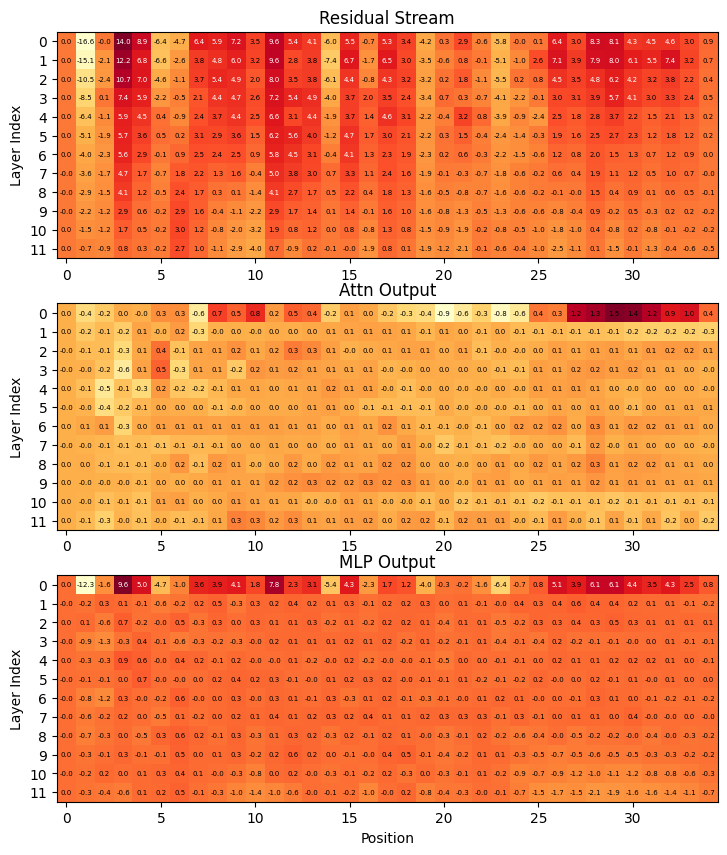

In [237]:
fig, axs = plt.subplots(3,1, figsize=(20,10))
eb_cropped = every_block_result[:,:,:35].cpu().numpy()
titles = ["Residual Stream", "Attn Output", "MLP Output"]
for i in range(len(axs)):
    im = axs[i].imshow(eb_cropped[i],cmap="YlOrRd")
    axs[i].set_yticks(range(12))
    axs[i].set_title(titles[i])
    for j in range(eb_cropped.shape[1]):
        for k in range(eb_cropped.shape[2]):
            im.axes.text(k, j, vfmt(eb_cropped[i][j][k]), fontsize=5, va="center", ha="center", color="black" if eb_cropped[i][j][k] < 0.04 else "white")
    axs[i].set_ylabel("Layer Index")
axs[2].set_xlabel("Position")
plt.savefig("../figures/every_block_across_position.pdf")